# **Facial Emotion Detection**

## **Problem Definition**

**The context:** Why is this problem important to solve?<br>
**The objectives:** What is the intended goal?<br>
**The key questions:** What are the key questions that need to be answered?<br>
**The problem formulation:** What are we trying to solve using data science?






**Why is this problem important to solve?**

Human emotion recognition is becoming increasingly vital in various industries as it enhances customer interactions, improves employee engagement, and drives better decision-making. By understanding emotional cues, businesses can tailor their services to meet client needs more effectively, fostering loyalty and satisfaction. In the workplace, recognizing employee emotions can lead to a more supportive environment, promoting well-being and productivity.

**What is the intended goal?**

The goal of this project is to investigate whether it is possible to design an automated solution for etion recognition.

**What are the key questions that need to be answered?**

The key question to be asked:
- how emotion recognition can be automated and handed over to computer system?
- how effient in terms of cost and recognition accuracy the solution can be?
- how and where to collect data for the recognition task

**What are we trying to solve using data science?**
Given a dataset of images with face emotion expression, we should use data science in the follwoing way:
- review the dataset and understand the data we have by means of EDA
- come up with idea of ML/AI model to train using face expression data, including in-depth model research
- evaluate the models and select the best one
- based on the best model specs (model size, preformance) give business values and provide recommendations

## **About the dataset**

The data set consists of 3 folders, i.e., 'test', 'train', and 'validation'.
Each of these folders has four subfolders:

**‘happy’**: Images of people who have happy facial expressions.<br>
**‘sad’**: Images of people with sad or upset facial expressions.<br>
**‘surprise’**: Images of people who have shocked or surprised facial expressions.<br>
**‘neutral’**: Images of people showing no prominent emotion in their facial expression at all.<br>

## **Mounting the Drive**

**NOTE:**  Please use Google Colab from your browser for this notebook. **Google.colab is NOT a library that can be downloaded locally on your device.**

In [2]:
# Mounting the drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/My Drive/MIT_PE/
%ls

/content/drive/My Drive/MIT_PE
allconv.py
assets/
augment_and_mix.py
augmentations.py
augmentations_.py
augmix-master.zip
cifar.py
dataset/
densenet.py
Facial_emotion_images/
Facial_emotion_images.zip
High_Code_SVHN_Digit_Recognition_copy.ipynb
High_Code_SVHN_Digit_Recognition.ipynb
imagenet.py
LICENSE
Low_Code_SVHN_Digit_Recognition.ipynb
model_configs/
model_results/
models/
__pycache__/
README.md
Reference_Notebook_Facial_Emotion_Detection_Full_Code_clear.ipynb
Reference_Notebook_Facial_Emotion_Detection_Full_Code.ipynb
Reference_Notebook_Facial_Emotion_Detection_Full_Code_Tarasenko2.ipynb
Reference_Notebook_Facial_Emotion_Detection_Full_Code_Tarasenko_final_draft.ipynb
Reference_Notebook_Facial_Emotion_Detection_Full_Code_Tarasenko_.ipynb
Reference_Notebook_Facial_Emotion_Detection_Low_Code.ipynb
requirements.txt
resnext.py
slice_layer.py
third_party/
trained_models/
vgg16d5_keras_slice.py
wideresnet.py


In [4]:
first_time_run = False

In [5]:
!pip install -U imbalanced-learn

## **Importing the Libraries**

In [6]:
import zipfile
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os
import random
import pickle
import h5py
import json

#import numpy
import numpy as np

#import PIL image
from PIL import Image


# Importing Deep Learning Libraries
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout, GlobalAveragePooling2D, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D, LeakyReLU
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adamax
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, Callback

from tensorflow.keras.saving import load_model
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.regularizers import L1L2, L1, L2, OrthogonalRegularizer
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

from tensorflow.keras import backend

#import routines for model evaluation
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


### **Let us load and unzip the data**

**Note:**
- You must download the dataset from the link provided on Olympus and upload the same on your Google drive before executing the code in the next cell.
- In case of any error, please make sure that the path of the file is correct as the path may be different for you.

During the first run, dataset was extructed from zip archive. Therefore it runs only ones.

In [7]:
if first_time_run:
  # Storing the path of the data file from the Google drive
  archive_path = 'Facial_emotion_images.zip'

  # The data is provided as a zip file so we need to extract the files from the zip file
  with zipfile.ZipFile(archive_path, 'r') as zip_ref:
      zip_ref.extractall()

In [8]:
%cd Facial_emotion_images
%ls

/content/drive/My Drive/MIT_PE/Facial_emotion_images
data/                       emotions_data.h5    __pycache__/    test/   validation/
emotion_dataset_pil.pickle  learning_curves.h5  slice_layer.py  train/  vgg16d5_keras_slice.py


In [9]:
%cd train
%ls
%cd ..

/content/drive/My Drive/MIT_PE/Facial_emotion_images/train
happy/  neutral/  sad/  surprise/
/content/drive/My Drive/MIT_PE/Facial_emotion_images


In [10]:
import os
dataset_list_tmp = os.listdir()
dataset_list = []
for item in dataset_list_tmp:
  #print(item)
  if '.' in item or '_' in item:
    #print(True)
    continue
  dataset_list.append(item)
dataset_list

['test', 'train', 'validation', 'data']

In [11]:
emotion_list = os.listdir('train')
emotion_list.sort()
emotion_list

['happy', 'neutral', 'sad', 'surprise']

**Create grayscale datasets from original image files**

during the training using dataloader with flow_from_directory, batch generation was extremely slow (about 25 sec per batch), nost likely due to network latency.
Therefore a single epoch was about to take 25 min. Since such time is not acceptable, original images were converted into a dataset and saved in h5 files.

In [12]:
import time

if first_time_run:

  start_time = time.time()

  datasets = {}
  datasets['Xtrain'] = []
  datasets['Ytrain'] = []
  datasets['Xtest'] = []
  datasets['Ytest'] = []
  datasets['Xvalidation'] = []
  datasets['Yvalidation'] = []
  #read dataset and store in NumpyArray

  for dataset_type in dataset_list[:1]:
    for i,emotion in enumerate(emotion_list[:1]):
      file_list = os.listdir(f'{dataset_type}/{emotion}/')
      for img_name in file_list:
        im = Image.open(f"{dataset_type}/{emotion}/{img_name}")
        numpydata = numpy.asarray(im)
        numpydata = numpy.expand_dims(numpydata,axis=-1)
        datasets[f'X{dataset_type}'].append(numpydata)
        datasets[f'Y{dataset_type}'].append(i)

    datasets[f'X{dataset_type}'] = numpy.array(datasets[f'X{dataset_type}']).astype(float)
    datasets[f'Y{dataset_type}'] = numpy.array(datasets[f'Y{dataset_type}']).astype(float)

  print(f'Takes {time.time() - start_time}')

**Dump grayscale Datasets into h5 file**

In [64]:
h5py_filename = "emotions_data.h5"

if first_time_run:
  #Writing data
  hf = h5py.File(h5py_filename, "w")

  for key in datasets.keys():
    dset1 = hf.create_dataset(key, data=datasets[key])
  hf.close()

**Load grayscale datasets h5 file**

for each now run, we only need to load dataset from h5 file.

In [13]:
#Reading data
h5py_filename = "emotions_data.h5"

if not first_time_run:
  datasets_data = {}

  hf1 = h5py.File(h5py_filename, "r")
  for name in hf1:
      datasets_data[name] = hf1[name][:]
      print(name,datasets_data[name].shape)

  #print(hf1.attrs.keys())
  hf1.close()

Xtest (128, 48, 48, 1)
Xtrain (15109, 48, 48, 1)
Xvalidation (4977, 48, 48, 1)
Ytest (128, 4)
Ytrain (15109, 4)
Yvalidation (4977, 4)


**Create RGB datasets from grayscale dataset**

Verify structure of grayscale PIL Image vs. RGB PIL Image

In [14]:
img = Image.open('train/happy/'+os.listdir("train/happy")[0])
img.mode
np_img_L = np.array(img)
print(f'Image mode: {img.mode} and dims of corresponding NumPy Array: {np_img_L.shape}')

Image mode: L and dims of corresponding NumPy Array: (48, 48)


In [15]:
img_rgb = img.copy()
if img.mode != 'RGB':
  img_rgb = img.convert('RGB')
np_img_rgb = np.array(img_rgb)
img_rgb.mode,np_img_rgb.shape
print(f'Image mode: {img_rgb.mode} and dims of corresponding NumPy Array: {np_img_rgb.shape}')

Image mode: RGB and dims of corresponding NumPy Array: (48, 48, 3)


Check content of NumPy arrays for GrayScake and RGB images

In [16]:
sample = np.array(datasets_data['Xtrain'][0]).astype(int)
sample.shape
for i in [0,1,2]:
  print(f'Channel {i}',np.all(np_img_rgb[:,:,0] == sample[:,:,0]))

Channel 0 True
Channel 1 True
Channel 2 True


Conclusion: to create RBG version of the GrayScale image, we can simple copy content of the single GrayScale channel into all RBG channels.

Implement GrayScale to RGB conversion using replication of channels

In [17]:
import time


if not first_time_run:
  start_time = time.time()

  datasets_rgb = {}
  datasets_rgb['Xtrain'] = []
  datasets_rgb['Ytrain'] = datasets_data['Ytrain']
  datasets_rgb['Xtest'] = []
  datasets_rgb['Ytest'] = datasets_data['Ytest']
  datasets_rgb['Xvalidation'] = []
  datasets_rgb['Yvalidation'] = datasets_data['Yvalidation']
  #read dataset and stor in NumpyArray

  for key in list(datasets_data.keys()):
    if 'X' in key:
      samples = []
      for sample in datasets_data[key]:
        img_rgb = np.zeros((sample.shape[0],sample.shape[1],3))
        sample = np.squeeze(sample, axis=-1)
        img_rgb[:,:,0] = sample
        img_rgb[:,:,1] = sample
        img_rgb[:,:,2] = sample
        datasets_rgb[key].append(img_rgb)

    datasets_rgb[key] = np.array(datasets_rgb[key]).astype(int)
    print(key,datasets_rgb[key].shape)

  print(f'Takes {time.time() - start_time}')

Xtest (128, 48, 48, 3)
Xtrain (15109, 48, 48, 3)
Xvalidation (4977, 48, 48, 3)
Ytest (128, 4)
Ytrain (15109, 4)
Yvalidation (4977, 4)
Takes 2.470522403717041


**Check whether train, validation and test datasets have the same set of classes**

In [18]:
#check whether train, test and validation datasets contain the same classes
temp_list = []
same_classes = True
for dataset_type in dataset_list:
  temp_var = os.listdir(dataset_type)
  temp_var.sort()
  temp_list.append(temp_var)
  print(f'{dataset_type} classes {temp_var}')
  if len(temp_list) > 2:
    try:
      assert temp_list[-2] == temp_list[-1]
    except:
      same_classes = False

print(f'train, test and validation dataset contain the same classes: {same_classes}')


test classes ['happy', 'neutral', 'sad', 'surprise']
train classes ['happy', 'neutral', 'sad', 'surprise']
validation classes ['happy', 'neutral', 'sad', 'surprise']
data classes ['cifar']
train, test and validation dataset contain the same classes: False


**Observations and Insights:__**

all three datasets, i.e., train, validation and test have the same number and same names for the classes.

In [19]:
datasets_data.keys()

dict_keys(['Xtest', 'Xtrain', 'Xvalidation', 'Ytest', 'Ytrain', 'Yvalidation'])

## **Visualizing our Classes**

Let's look at our classes.

**Write down your observation for each class. What do you think can be a unique feature of each emotion, that separates it from the remaining classes?**

### **Happy**

In [21]:
emo_labels = {emo:np.array(to_categorical(i,num_classes=4)) for i,emo in enumerate(emotion_list)}
emo_labels

{'happy': array([1., 0., 0., 0.]),
 'neutral': array([0., 1., 0., 0.]),
 'sad': array([0., 0., 1., 0.]),
 'surprise': array([0., 0., 0., 1.])}

Load images directly from image files

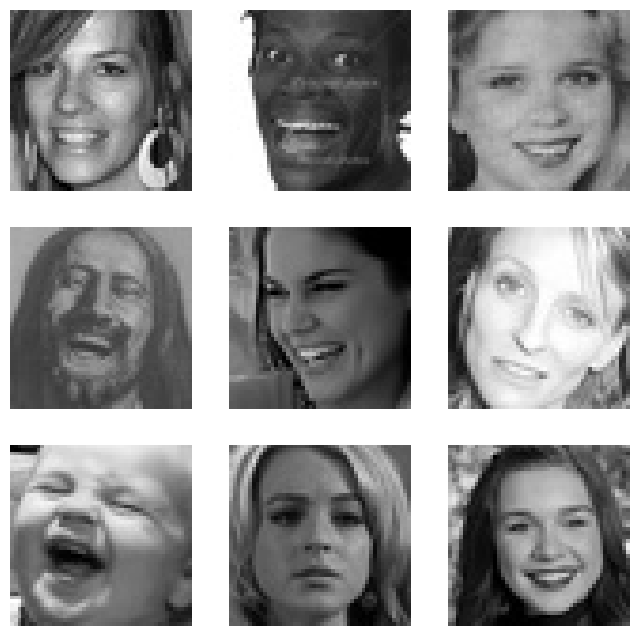

In [22]:
expression = 'happy'
folder_path= ''
picture_size = 48

files = os.listdir(folder_path + "train/" + expression)

plt.figure(figsize= (8,8))
for i in range(0, 9, 1):
    plt.subplot(3, 3, i+1)

    img = load_img(folder_path + "train/" + expression + "/" + files[i],
                   target_size = (picture_size, picture_size))
    plt.imshow(img)
    plt.axis('off')
plt.show()

Load images from numpy arrays

happy [1. 0. 0. 0.]


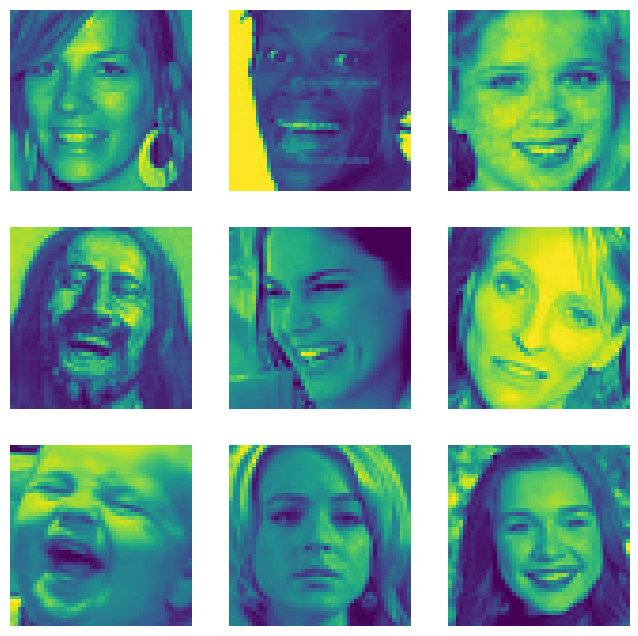

In [23]:
expression = 'happy'
print(expression,emo_labels[expression])
folder_path= ''
picture_size = 48

plt.figure(figsize= (8,8))
limit = 9
cnt = 0
for i,class_label in enumerate(datasets_data['Ytrain']):
  if cnt < limit and all(class_label == emo_labels[expression]):
    cnt += 1
    plt.subplot(3, 3, cnt)

    plt.imshow(datasets_data['Xtrain'][i])
    plt.axis('off')
plt.show()

**Observations and Insights:__**
This class contains faces of people of different age (children vs. adults), gender (men vs. women), and different ethnicities. Pictures of faces is taken under different angels and from different distances.

the key feature may include mouth/lips posture, shape of eyes, silhouette of muscles around the mouth and eyes. In most of the cases eyes are nearly closed, mouth is open showing the teeth.  

### **Sad**

Load images directly from image files

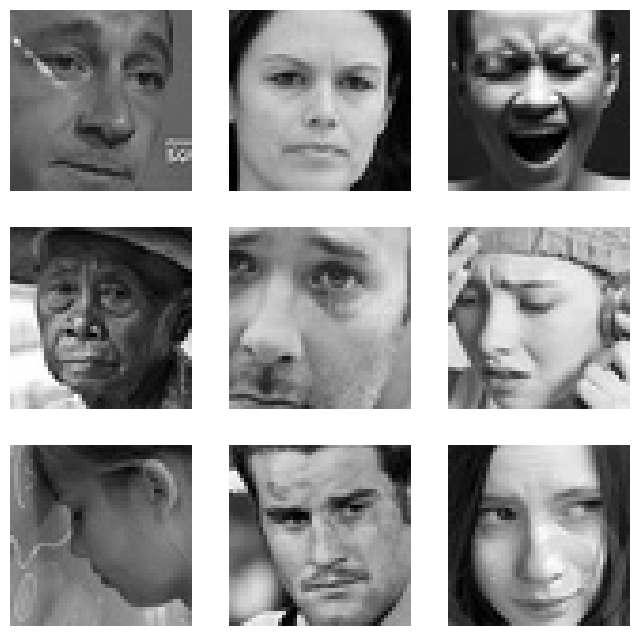

In [24]:
expression = 'sad'
folder_path= ''
picture_size = 48

files = os.listdir(folder_path + "train/" + expression)
plt.figure(figsize= (8,8))
for i in range(0, 9, 1):
    plt.subplot(3, 3, i+1)

    img = load_img(folder_path + "train/" + expression + "/" + files[i],
                   target_size = (picture_size, picture_size))

    plt.imshow(img)
    plt.axis('off')
plt.show()

Load images from numpy arrays

sad [0. 0. 1. 0.]


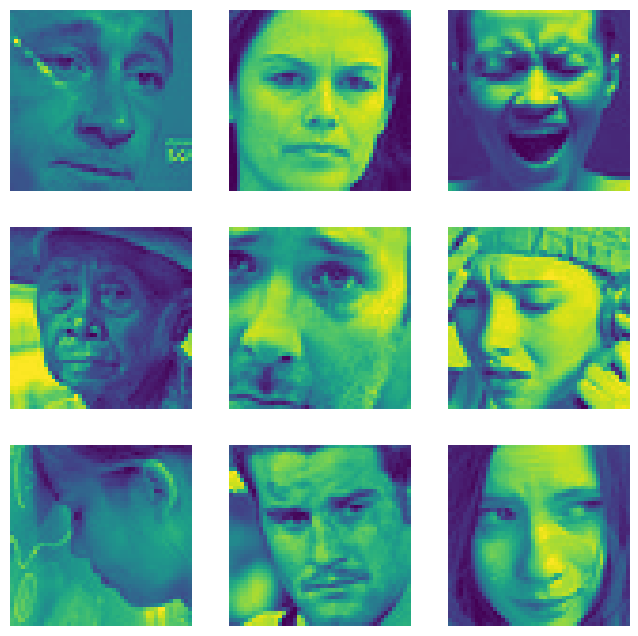

In [25]:
expression = 'sad'
print(expression,emo_labels[expression])
folder_path= ''
picture_size = 48

folder_path= ''
picture_size = 48

plt.figure(figsize= (8,8))
limit = 9
cnt = 0
for i,class_label in enumerate(datasets_data['Ytrain']):
  if cnt < limit and all(class_label == emo_labels[expression]):
    cnt += 1
    plt.subplot(3, 3, cnt)

    plt.imshow(datasets_data['Xtrain'][i])
    plt.axis('off')
plt.show()

**Observations and Insights:__**
This class contains faces of people of different age (children vs. adults), gender (men vs. women), and different ethnicities. Pictures of faces is taken under different angels and from different distances.

the key feature may include mouth/lips posture, shape of eyes, silhouette of muscles around the mouth, eyes and eyebrows.  

In particular, mouth is closed and lips are tightened. No teeths are visible. Eyes are of oval shape, eyebrows are shifted toward each other.

### **Neutral**

Load images directly from image files

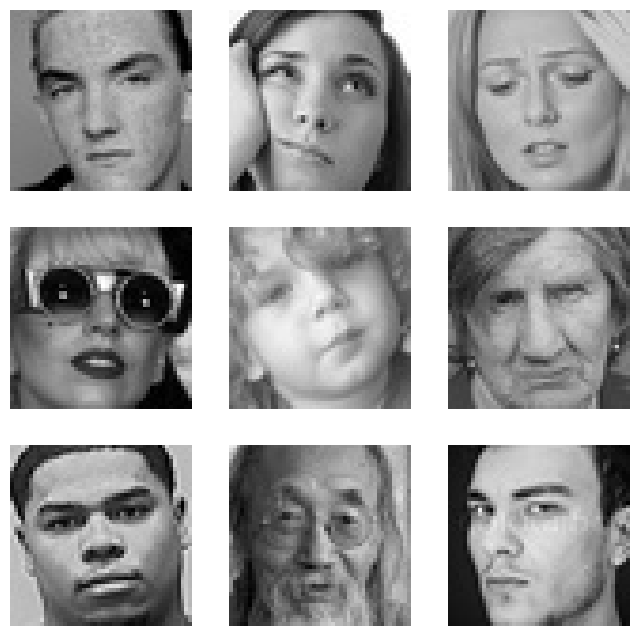

In [26]:
expression = 'neutral'
folder_path= ''
picture_size = 48

files = os.listdir(folder_path + "train/" + expression)

plt.figure(figsize= (8,8))
for i in range(0, 9, 1):
    plt.subplot(3, 3, i+1)

    img = load_img(folder_path + "train/" + expression + "/" + files[i],
                   target_size = (picture_size, picture_size))

    plt.imshow(img)
    plt.axis('off')
plt.show()

Load images from numpy arrays

neutral [0. 1. 0. 0.]


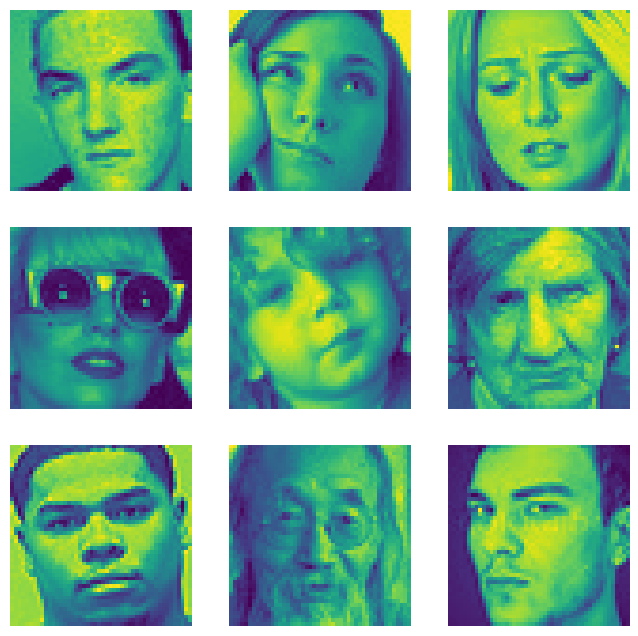

In [27]:
expression = 'neutral'
print(expression,emo_labels[expression])
folder_path= ''
picture_size = 48

folder_path= ''
picture_size = 48

plt.figure(figsize= (8,8))
limit = 9
cnt = 0
for i,class_label in enumerate(datasets_data['Ytrain']):
  if cnt < limit and all(class_label == emo_labels[expression]):
    cnt += 1
    plt.subplot(3, 3, cnt)

    plt.imshow(datasets_data['Xtrain'][i])
    plt.axis('off')
plt.show()

**Observations and Insights:__**
This class contains faces of people of different age (children vs. adults), gender (men vs. women), and different ethnicities. Pictures of faces is taken under different angels and from different distances.

the key feature may include mouth/lips posture, shape of eyes, silhouette of muscles around the mouth, eyes and eyebrows.

In constrast to other emotions, neural states is characterized by relaxed manner, showing no tention of face muscles.

In this class we can also observe glasses on the face, which creates a variability and serve as destructor especially in the case of non-transparent sun glasses.

### **Surprised**

Load images directly from image files

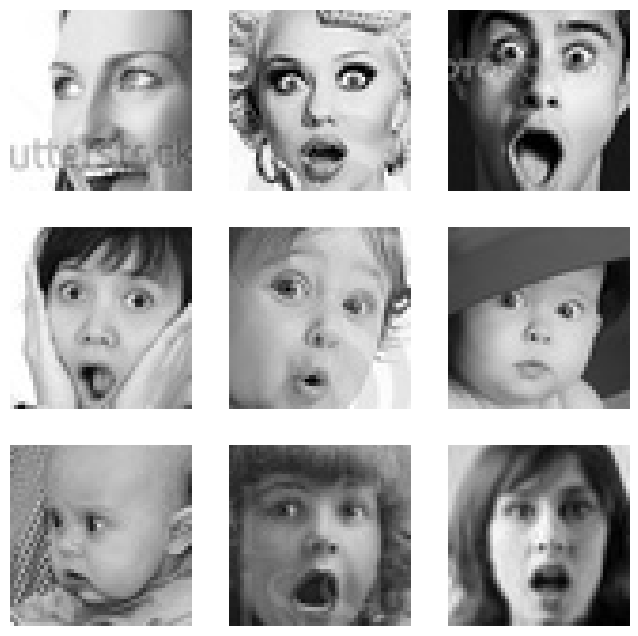

In [28]:
expression = 'surprise'
folder_path= ''
picture_size = 48

files = os.listdir(folder_path + "train/" + expression)

plt.figure(figsize= (8,8))
for i in range(0, 9, 1):
    plt.subplot(3, 3, i+1)

    img = load_img(folder_path + "train/" + expression + "/" + files[i],
                   target_size = (picture_size, picture_size))

    plt.imshow(img)
    plt.axis('off')
plt.show()

Load images from numpy arrays

surprise [0. 0. 0. 1.]


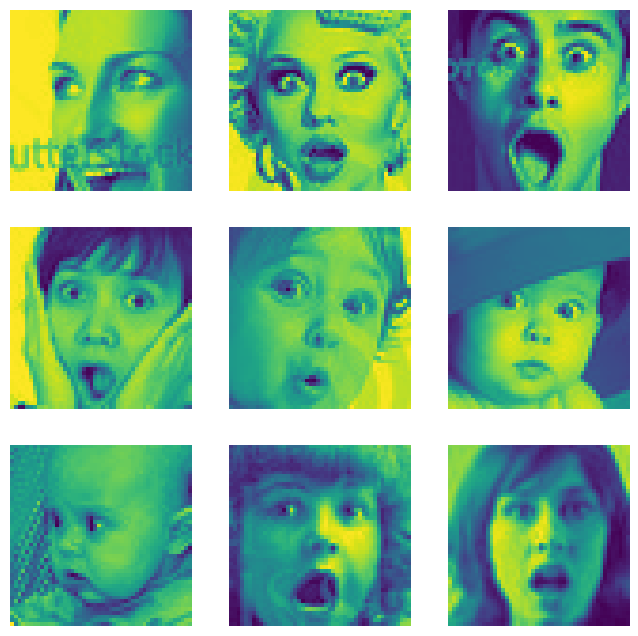

In [29]:
expression = 'surprise'
print(expression,emo_labels[expression])
folder_path= ''
picture_size = 48

folder_path= ''
picture_size = 48

plt.figure(figsize= (8,8))
limit = 9
cnt = 0
for i,class_label in enumerate(datasets_data['Ytrain']):
  if cnt < limit and all(class_label == emo_labels[expression]):
    cnt += 1
    plt.subplot(3, 3, cnt)

    plt.imshow(datasets_data['Xtrain'][i])
    plt.axis('off')
plt.show()

**Observations and Insights:__**
This class contains faces of people of different age (children vs. adults), gender (men vs. women), and different ethnicities. Pictures of faces is taken under different angels and from different distances.

the key feature may include mouth/lips posture, shape of eyes, silhouette of muscles around the mouth, eyes and eyebrows.

Suprised people look like sad and happy at the same time, with mouth and eyes widly open.

In this class we can also observe some watermark like text over the pitcure. This creates additional variability and serves as destructor, since this is irrelevant infomation regarding the emotions.

## **Checking Distribution of Classes**

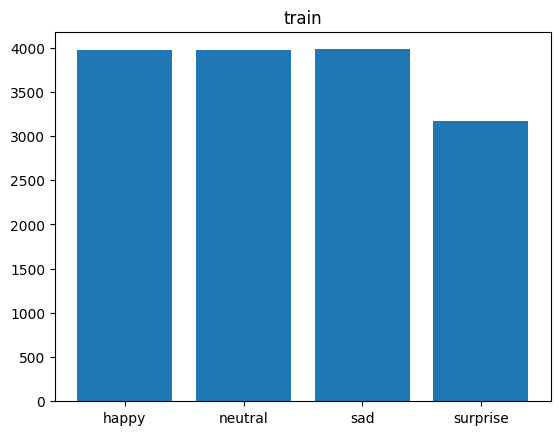

In [30]:
dataset_type = 'train'
freq = []
for emotion_type in emotion_list:
  #print(f"{dataset_type}/{emotion_type}")
  dir = f"{dataset_type}/{emotion_type}"
  freq.append(len(os.listdir(dir)))
plt.bar(emotion_list,freq)
plt.title(dataset_type)
plt.show()

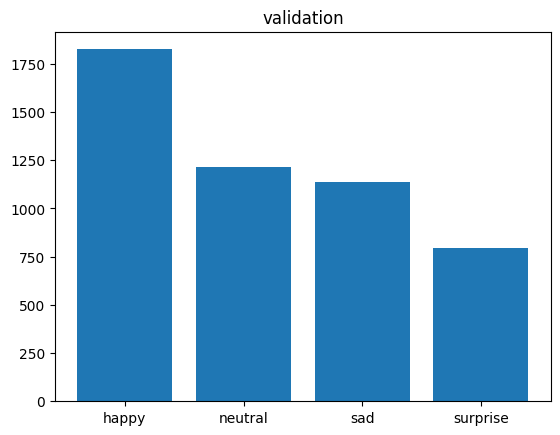

In [31]:
dataset_type = 'validation'
freq = []
for emotion_type in emotion_list:
  #print(f"{dataset_type}/{emotion_type}")
  dir = f"{dataset_type}/{emotion_type}"
  freq.append(len(os.listdir(dir)))
plt.bar(emotion_list,freq)
plt.title(dataset_type)
plt.show()

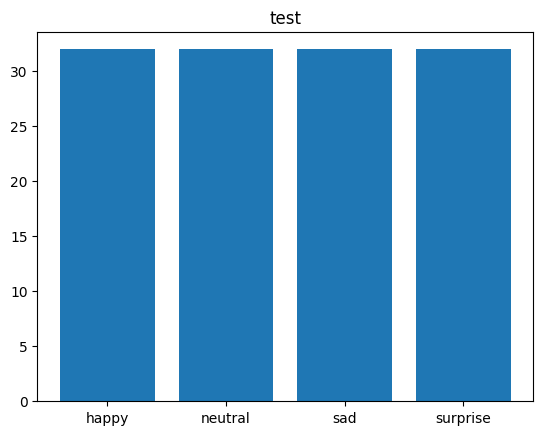

In [32]:
dataset_type = 'test'
freq = []
for emotion_type in emotion_list:
  #print(f"{dataset_type}/{emotion_type}")
  dir = f"{dataset_type}/{emotion_type}"
  freq.append(len(os.listdir(dir)))
plt.bar(emotion_list,freq)
plt.title(dataset_type)
plt.show()

**Think About It:**
* Are the classes equally distributed? If not, do you think the imbalance is too high? Will it be a problem as we progress?
* Are there any Exploratory Data Analysis tasks that we can do here? Would they provide any meaningful insights?

**Observations and Insights:__**
while test dataset is completely balanced, i.e., 32 samples for each emotion type, in the case of the train dataset, 'surprise' class contains about 21% less samples than other classes.

Even stronger contrast is observed in validation dataset, where 'happy' class contains most of the sample, neural class contains about 67% of samples of 'happy' class sample size. 'sad' class contains about 62% of samples of 'happy' class sample size. however, 'surprise' class contains only 43% of samples of 'happy' class sample size.

Therefore this dataset is heavely unbalanced in the case of validation dataset.
This requires special techniques to deal with such bias.

## **Creating our Data Loaders**

In this section, we are creating data loaders that we will use as inputs to our Neural Network.

**You have two options for the color_mode. You can set it to color_mode = 'rgb' or color_mode = 'grayscale'. You will need to try out both and see for yourself which one gives better performance.**

GrayScale loader

In [20]:
batch_size  = 32
img_size = 48
color_mode = 'grayscale'
folder_path = ''

datagen_train = ImageDataGenerator(rescale=1./255)

train_set = datagen_train.flow(x=datasets_data['Xtrain'],
                               y=datasets_data['Ytrain'],
                               batch_size=batch_size,
                               shuffle=True)


datagen_validation = ImageDataGenerator(rescale=1./255)

validation_set = datagen_validation.flow(x=datasets_data['Xvalidation'],
                                         y=datasets_data['Yvalidation'],
                                         batch_size=batch_size,
                                         shuffle=True)

datagen_test = ImageDataGenerator(rescale=1./255)

test_set = datagen_train.flow(x=datasets_data['Xtest'],
                               y=datasets_data['Ytest'],
                               batch_size=batch_size,
                               shuffle=True)

RBG Loader

In [21]:
batch_size  = 32
img_size = 48
color_mode = 'RGB'
folder_path = ''

datagen_train_rgb = ImageDataGenerator(rescale=1./255)

train_set_rgb = datagen_train_rgb.flow(x=datasets_rgb['Xtrain'],
                               y=datasets_rgb['Ytrain'],
                               batch_size=batch_size,
                               shuffle=True)


datagen_validation_rgb = ImageDataGenerator(rescale=1./255)

validation_set_rgb = datagen_validation_rgb.flow(x=datasets_rgb['Xvalidation'],
                                         y=datasets_rgb['Yvalidation'],
                                         batch_size=batch_size,
                                         shuffle=True)

datagen_test_rgb = ImageDataGenerator(rescale=1./255)

test_set_rgb = datagen_train_rgb.flow(x=datasets_rgb['Xtest'],
                               y=datasets_rgb['Ytest'],
                               batch_size=batch_size,
                               shuffle=True)

Helper Functions

In [22]:
gl_history = {}
gl_models = {}
gl_cm = {}
gl_clrep = {}
gl_model_def = {}
model_config = {}

opt_dict = {}
opt_dict['Adam'] = Adam
opt_dict['RMSprop'] = RMSprop
opt_dict['SGD'] = SGD
opt_dict['Adamax'] = Adamax

gl_best_model = {}

param_dict = {'k_reg':False,
              'a_reg':False,
              'cl_w': False,
              'aug': False,
              'bn': False,
              'dropout':False
              }

def get_model_name(base,
                   param_dict=None
                  ):
  model_name = base
  if param_dict is not None:
    for key,value in param_dict.items():
      if value:
        model_name += f'_{key}'

  return model_name

learning_curves = {}

In [23]:
def create_dfs(model_name,
               cl_rep,
               df_models):

  df_model = pd.DataFrame(cl_rep)
  index_tuple = [(model_name,item) for item in df_model.index]
  index = pd.MultiIndex.from_tuples(index_tuple, names=["Model", "Metric"])
  df_model.index = index
  df_model

  if df_models.empty:
    df_models = df_model.copy()
  else:
    df_models = pd.concat([df_models, df_model])
  df_models.head()
  df_models.to_csv('/content/drive/MyDrive/MIT_PE/model_results/model_results_metrics.csv')
  return df_models, df_model

In [24]:
def compute_test_stats(model_name,
                       dataset,
                       y_test,
                       font_size=15,
                       show_cm=True):
  #load best model
  best_model = load_model(f'/content/drive/MyDrive/MIT_PE/trained_models/{model_name}.keras')
  #predict label logits
  test_pred_logits = best_model.predict(dataset['Xtest'])
  #print(f'Logits {test_pred_logits[0]} should sum up to 1.0: {1.0 == test_pred_logits[0].sum()}')
  #convert logits into class labels
  test_pred_labels = np.argmax(test_pred_logits, axis = -1)

  # Printing the classification report
  cl_rep = classification_report(y_test,
                                test_pred_labels,
                                target_names=emotion_list,
                                output_dict=True
                                )
  df = pd.DataFrame(cl_rep)
  df.head()

  cm = confusion_matrix(y_test,
                        test_pred_labels)
  if show_cm:
    plt.figure(figsize = (8, 5))
    sns.heatmap(cm,
                xticklabels=emotion_list,
                yticklabels=emotion_list,
                annot = True,  fmt = '.0f',
                annot_kws={'size': font_size})
    plt.title(model_name)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

  return cl_rep, cm

In [25]:
def save_learning_data(model_name,
                       history,
                       clrep,
                       cm
                       ):
  learning_curves = {
                      'acc':history.history['accuracy'],
                      'val_acc':history.history['val_accuracy'],
                      'report':clrep,
                      'cm':cm
                    }

  #with open(f"/content/drive/MyDrive/MIT_PE/model_results/{model_name}.json", 'w') as fp:
  #    json.dump(learning_curves, fp)
  filehandler = open(f"/content/drive/MyDrive/MIT_PE/model_results/{model_name}.pickle","wb")
  pickle.dump(learning_curves,filehandler)
  filehandler.close()

In [26]:
early_stopping = EarlyStopping(monitor = 'val_loss',
                          min_delta = 0,
                          patience = 10,
                          verbose = 1,
                          restore_best_weights = True
                          )

reduce_learningrate = ReduceLROnPlateau(monitor = 'val_loss',
                                        factor = 0.2,
                                        patience = 10,
                                        verbose = 1,
                                        min_delta = 0.0001)

callback_dict = { "early_stopping":early_stopping,
                  "reduce_learningrate":reduce_learningrate}

In [27]:
y_test = np.argmax(datasets_data['Ytest'], axis = -1)
df_models = pd.read_csv('/content/drive/MyDrive/MIT_PE/model_results/model_results_metrics.csv')
df_models = df_models.drop_duplicates()
df_models = df_models.set_index(['Model', 'Metric'])
#df_models

## **Simple CNN**

## **Model Building**

**Think About It:**
* Are Convolutional Neural Networks the right approach? Should we have gone with Artificial Neural Networks instead?
* What are the advantages of CNNs over ANNs and are they applicable here?

Convolutional Neural Networks contain filters to account for spatial dependencies, shift-invariant recognition and trainable parameters’ sharing. These are the main advantages of CNN over ANN.


### **Creating the Base Neural Network**

In [40]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

In [41]:
#create simple CNN
def simple_cnn(input_shape=(48, 48, 1),
               kernel_size=(2,2),
               aug=False,
               kernel_reg = False,
               kernel_reg_rate = 0.01,
               activ_reg = False,
               activ_reg_rate = 0.01,
               ):
  inputs = keras.Input(shape=input_shape)

  x = inputs

  if aug:
    print('Aug enabled')
    x = data_augmentation(x)

  ker_reg = None
  if kernel_reg:
    ker_reg = keras.regularizers.L1(kernel_reg_rate)

  act_reg = None
  if activ_reg:
    act_reg = keras.regularizers.L2(activ_reg_rate)


  for filters in [64,32,32]:
    x = layers.Conv2D(filters=filters,
                      kernel_size=kernel_size,
                      padding='same',
                      kernel_regularizer = ker_reg,
                      activity_regularizer = act_reg,
                      activation='relu')(x)

    x = layers.MaxPooling2D(pool_size=(2,2))(x)
    x = layers.Dropout(0.2)(x)

  x = layers.Flatten()(x)

  x = layers.Dense(512,activation='relu')(x)
  x = layers.Dropout(0.4)(x)

  outputs = layers.Dense(4, activation="softmax")(x)
  model = keras.Model(inputs=inputs, outputs=outputs)
  return model

In [42]:
def simple_cnn_run_config(mode_config_local):
  local_model = simple_cnn(
                          input_shape = mode_config_local['input_shape'],
                          kernel_size = mode_config_local['kernel_size'],
                          aug = mode_config_local['aug'],
                          kernel_reg = mode_config_local['kernel_reg'],
                          kernel_reg_rate = mode_config_local['kernel_reg_rate'],
                          activ_reg = mode_config_local['activ_reg'],
                          activ_reg_rate = mode_config_local['activ_reg_rate'],
                          )

  local_model.compile(loss="categorical_crossentropy",
                                optimizer=opt_dict[mode_config_local['opt']](learning_rate=mode_config_local['lr']),
                                metrics=["accuracy"])

  return local_model

### **Compiling and Training the Model**

In [ ]:
model_name = Convolutional Neural Networks as they are contain filters to account for spatial dependencies, shift-invariant recognition and trainable parameters’ sharing.


print(f'>>>> Model name: {model_name}')

model_config_local = {
                    'batch_size':batch_size,
                    'model_name':model_name,
                    'input_shape':(48, 48, 1),
                    'kernel_size':(2,2),
                    'lr':0.001,
                    'epochs':100,
                    'steps_per_epoch':500,
                    'validation_steps':150,
                    'kernel_reg':False,
                    'kernel_reg_rate':0.01,
                    'activ_reg':False,
                    'activ_reg_rate':0.01,
                    'cl_w': None,
                    'aug': False,
                    'bn': False,
                    'dropout':False,
                    'opt':'Adam',
                    'callback_list':['checkpoint']
                    }

with open(f"/content/drive/MyDrive/MIT_PE/model_configs/{model_name}.json", 'w') as fp:
    json.dump(model_config_local, fp)

>>>> Model name: simple_cnn_grayscale


In [ ]:
gl_models[model_name] = simple_cnn_run_config(model_config_local)

checkpoint = ModelCheckpoint(f"/content/drive/MyDrive/MIT_PE/trained_models/{model_config_local['model_name']}.keras",
                            monitor='val_accuracy',
                            verbose=1,
                            save_best_only=True,
                            mode='max')

callback_dict["checkpoint"] = checkpoint
callback_list = [callback_dict[item] for item in model_config_local['callback_list']]

np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

gl_history[model_name] = gl_models[model_name] .fit(train_set,
                                                    steps_per_epoch=model_config_local['steps_per_epoch'],
                                                    epochs=model_config_local['epochs'],
                                                    validation_data=validation_set,
                                                    validation_steps=model_config_local['validation_steps'],
                                                    callbacks=callback_list,
                                                    class_weight=model_config_local['cl_w']
                                                   )

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


473/500 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.3249 - loss: 1.3427

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 1: val_accuracy improved from -inf to 0.52708, saving model to /content/drive/MyDrive/MIT_PE/trained_models/simple_cnn_grayscale.keras
500/500 ━━━━━━━━━━━━━━━━━━━━ 27s 25ms/step - accuracy: 0.3285 - loss: 1.3388 - val_accuracy: 0.5271 - val_loss: 1.0962
Epoch 2/100
471/500 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5317 - loss: 1.0859
Epoch 2: val_accuracy improved from 0.52708 to 0.57627, saving model to /content/drive/MyDrive/MIT_PE/trained_models/simple_cnn_grayscale.keras
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.5320 - loss: 1.0849 - val_accuracy: 0.5763 - val_loss: 1.0340
Epoch 3/100
473/500 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5824 - loss: 0.9791
Epoch 3: val_accuracy improved from 0.57627 to 0.62313, saving model to /content/drive/MyDrive/MIT_PE/trained_models/simple_cnn_grayscale.keras
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.5824 - loss: 0.9793 - val_accuracy: 0.6231 - val_loss: 0.9036
Epoch 4/100
468/500 ━━━━━━━━━━━━━━━━━━━━ 0

Text(0.5, 1.0, 'simple_cnn_grayscale')

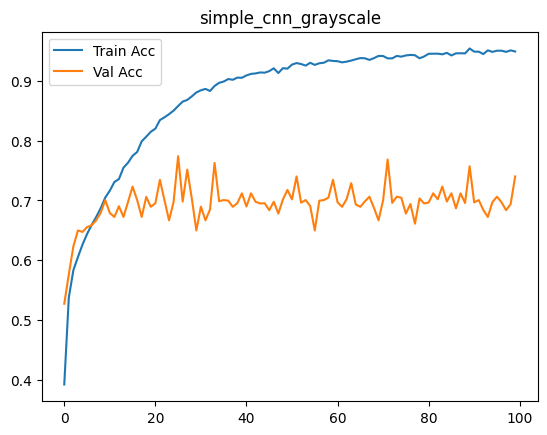

In [ ]:
plt.plot(gl_history[model_name].history['accuracy'])
plt.plot(gl_history[model_name].history['val_accuracy'])
plt.legend(['Train Acc','Val Acc'])
plt.title(model_name)

## **Evaluating Simple CNN Grayscale Model**

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step  
Logits [1. 0. 0. 0.] should sum up to 1.0: True


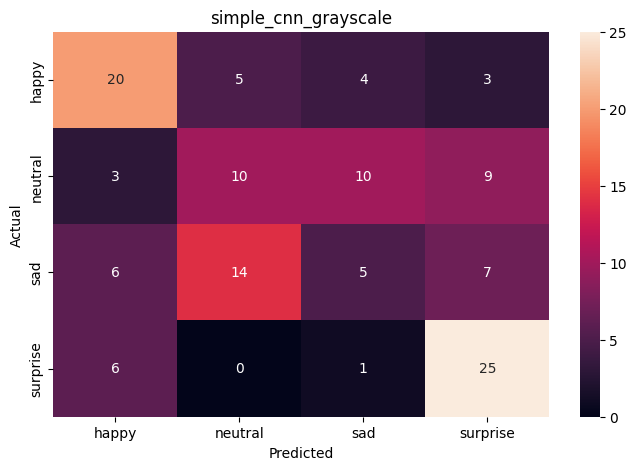

In [ ]:
gl_clrep[model_name], gl_cm[model_name] = compute_test_stats(model_name,
                                                             datasets_data,
                                                             y_test
                                                             )

In [ ]:
df_models, df_model = create_dfs(model_name,
                                gl_clrep[model_name],
                                df_models)
df_model

happy    neutral        sad   surprise  \
Model                Metric                                                  
simple_cnn_grayscale precision   0.571429   0.344828   0.250000   0.568182   
                     recall      0.625000   0.312500   0.156250   0.781250   
                     f1-score    0.597015   0.327869   0.192308   0.657895   
                     support    32.000000  32.000000  32.000000  32.000000   

                                accuracy   macro avg  weighted avg  
Model                Metric                                         
simple_cnn_grayscale precision   0.46875    0.433609      0.433609  
                     recall      0.46875    0.468750      0.468750  
                     f1-score    0.46875    0.443772      0.443772  
                     support     0.46875  128.000000    128.000000

In [ ]:
save_learning_data(model_name,
                   gl_history[model_name],
                   gl_clrep[model_name],
                   gl_cm[model_name]
                  )

backend.clear_session()

In [ ]:
np.array(gl_history[model_name].history['val_accuracy']).mean(), np.array(gl_history[model_name].history['accuracy']).max()

(0.6937228834629059, 0.954199492931366)

**Observations and Insights:__**

<b>Model Structure</b>

Simple CNN model consists of 3 consecutive blocks of layers.
Each block includes Conv2D, MaxPooling and DropOut layers.
Conv2D layers have ReLU activation.
These 3 blocks contains 64, 64 and 64 number of filters.
Sequence of blocks is then followed by flatten layer.

Three blocks and flatten layer constitute feature extraction part
of the Simple CNN.

Feature extraction part is followed by a classifier.

In this case, classifier consists for 3 layers:
- Dense fully connected layer with 512 neurons and ReLU activations
- DropOut
- Dense fully connected layer with 4 neurons and SoftMax activations.

<b>Training results</b>

In this section, we test GrayScale version of Simple CNN.
This means that input shape is (48,48,1).

According to the learning curves, until around 12th epoch,
train accuracy and validation accuracy are very simular.

During the learning the best model is defined in terms of max validation accuracy. This best model is then evaluated using test dataset.

After this epoch, training accuracy increases rapidly reaching max value of 0.957. While validation accuracy oscillates around mean value of 0.694.

This indicates strong overfitting of the model.

The overall performance on test data result in low value of precision, recall and f1-score, i.e., weighted average for these metrics are 0.434, 0.469 and 0.443 respectively.

We can also observe low recall and precision values of 0.156 and 0.250, respectively.

### **Simple CNN RBG**

### **Compiling and Training the Model**

In [ ]:
model_name = 'simple_cnn_rgb'

print(f'>>>> Model name: {model_name}')

model_config_local['model_name'] = model_name
model_config_local['input_shape'] = (48, 48, 3)

with open(f"/content/drive/MyDrive/MIT_PE/model_configs/{model_name}.json", 'w') as fp:
    json.dump(model_config_local, fp)

>>>> Model name: simple_cnn_rgb


In [ ]:
gl_models[model_name] = simple_cnn_run_config(model_config_local)

checkpoint = ModelCheckpoint(f"/content/drive/MyDrive/MIT_PE/trained_models/{model_config_local['model_name']}.keras",
                            monitor='val_accuracy',
                            verbose=1,
                            save_best_only=True,
                            mode='max')

callback_dict["checkpoint"] = checkpoint
callback_list = [callback_dict[item] for item in model_config_local['callback_list']]

np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

gl_history[model_name] = gl_models[model_name] .fit(train_set_rgb,
                                                    steps_per_epoch=model_config_local['steps_per_epoch'],
                                                    epochs=model_config_local['epochs'],
                                                    validation_data=validation_set_rgb,
                                                    validation_steps=model_config_local['validation_steps'],
                                                    callbacks=callback_list,
                                                    class_weight=model_config_local['cl_w']
                                                    )

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


465/500 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.3219 - loss: 1.3495

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 1: val_accuracy improved from -inf to 0.54917, saving model to /content/drive/MyDrive/MIT_PE/trained_models/simple_cnn_rgb.keras
500/500 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - accuracy: 0.3269 - loss: 1.3441 - val_accuracy: 0.5492 - val_loss: 1.0817
Epoch 2/100
473/500 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5452 - loss: 1.0629
Epoch 2: val_accuracy improved from 0.54917 to 0.62712, saving model to /content/drive/MyDrive/MIT_PE/trained_models/simple_cnn_rgb.keras
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.5456 - loss: 1.0617 - val_accuracy: 0.6271 - val_loss: 0.9356
Epoch 3/100
473/500 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5873 - loss: 0.9823
Epoch 3: val_accuracy improved from 0.62712 to 0.63604, saving model to /content/drive/MyDrive/MIT_PE/trained_models/simple_cnn_rgb.keras
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.5877 - loss: 0.9808 - val_accuracy: 0.6360 - val_loss: 0.8802
Epoch 4/100
468/500 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - acc

Text(0.5, 1.0, 'simple_cnn_rgb')

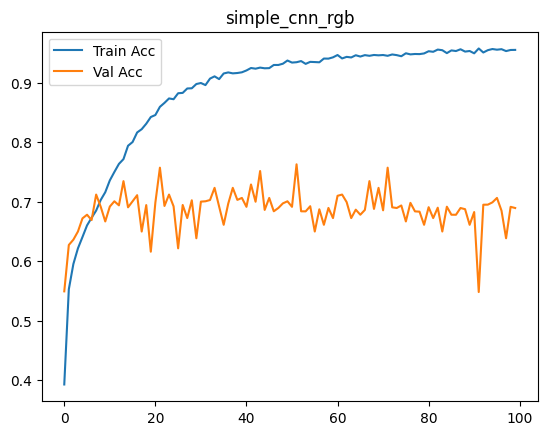

In [ ]:
plt.plot(gl_history[model_name].history['accuracy'])
plt.plot(gl_history[model_name].history['val_accuracy'])
plt.legend(['Train Acc','Val Acc'])
plt.title(model_name)

In [ ]:
## **Evaluating Simple CNN RGB Model**

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step  
Logits [1. 0. 0. 0.] should sum up to 1.0: True


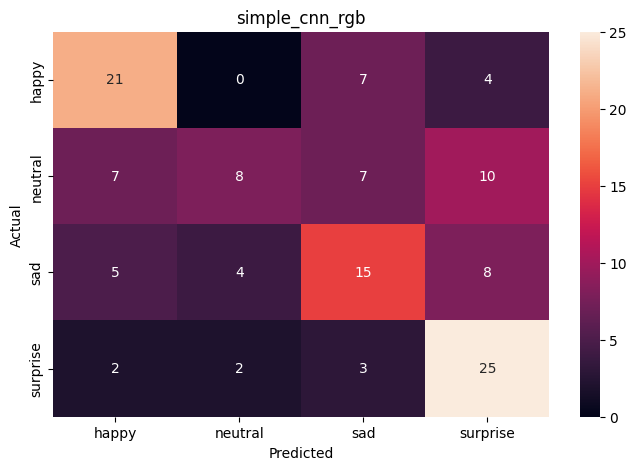

In [ ]:
gl_clrep[model_name], gl_cm[model_name] = compute_test_stats(model_name,
                                                             datasets_rgb,
                                                             y_test)

In [ ]:
df_models, df_model = create_dfs(model_name,
                                gl_clrep[model_name],
                                df_models)
df_model

happy    neutral       sad   surprise  accuracy  \
Model          Metric                                                           
simple_cnn_rgb precision   0.600000   0.571429   0.46875   0.531915  0.539062   
               recall      0.656250   0.250000   0.46875   0.781250  0.539062   
               f1-score    0.626866   0.347826   0.46875   0.632911  0.539062   
               support    32.000000  32.000000  32.00000  32.000000  0.539062   

                           macro avg  weighted avg  
Model          Metric                               
simple_cnn_rgb precision    0.543023      0.543023  
               recall       0.539062      0.539062  
               f1-score     0.519088      0.519088  
               support    128.000000    128.000000

In [ ]:
save_learning_data(model_name,
                   gl_history[model_name],
                   gl_clrep[model_name],
                   gl_cm[model_name]
                  )

backend.clear_session()

In [ ]:
np.array(gl_history[model_name].history['val_accuracy']).mean(), np.array(gl_history[model_name].history['accuracy']).max()

(0.6864238703250884, 0.957442581653595)

Text(0.5, 1.0, 'GrayScale vs. RGB Simple CNN performance')

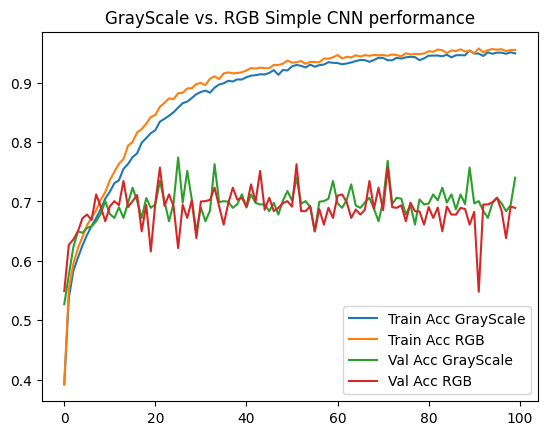

In [ ]:
plt.plot(gl_history['simple_cnn_grayscale'].history['accuracy'])
plt.plot(gl_history['simple_cnn_rgb'].history['accuracy'])
plt.plot(gl_history['simple_cnn_grayscale'].history['val_accuracy'])
plt.plot(gl_history['simple_cnn_rgb'].history['val_accuracy'])
plt.legend(['Train Acc GrayScale','Train Acc RGB', 'Val Acc GrayScale', 'Val Acc RGB'])

plt.title('GrayScale vs. RGB Simple CNN performance')

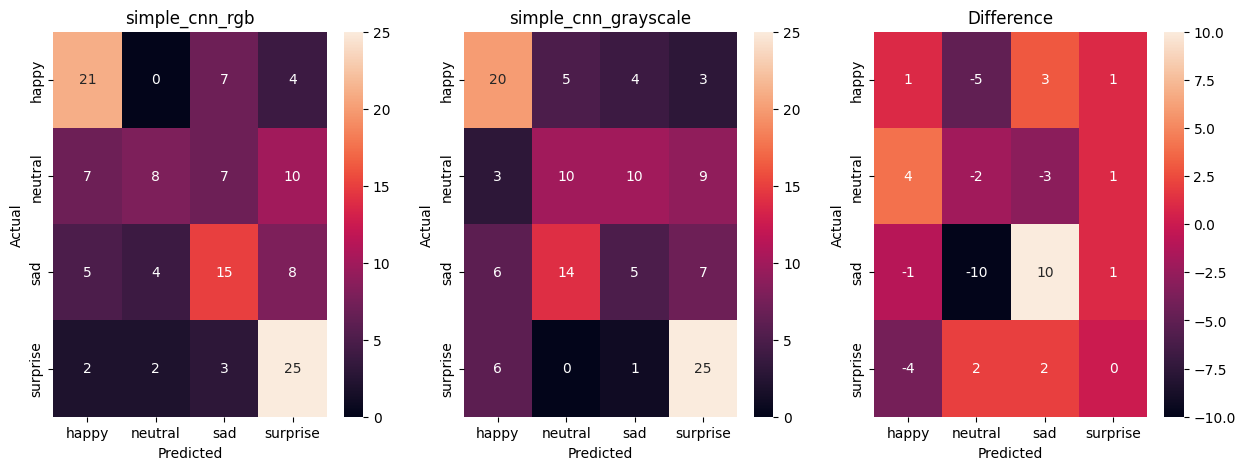

In [ ]:
plt.figure(figsize = (15, 5))
plt.subplot(1,3,1)
cm_delta = gl_cm['simple_cnn_rgb']
sns.heatmap(cm_delta,
            xticklabels=emotion_list,
            yticklabels=emotion_list,
            annot = True,  fmt = '.0f')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('simple_cnn_rgb')

plt.subplot(1,3,2)
cm_delta = gl_cm['simple_cnn_grayscale']
sns.heatmap(cm_delta, annot = True,
            xticklabels=emotion_list,
            yticklabels=emotion_list,
            fmt = '.0f')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('simple_cnn_grayscale')

plt.subplot(1,3,3)
cm_delta = gl_cm['simple_cnn_rgb'] - gl_cm['simple_cnn_grayscale']
sns.heatmap(cm_delta,
            xticklabels=emotion_list,
            yticklabels=emotion_list,
            annot = True,  fmt = '.0f')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Difference')
plt.show()

**Observations and Insights:__**

<b>Model Structure</b>

The structure is the same as described in the previous section.

<b>Training results</b>

In this section, we test RGB version of Simple CNN.
This means that input shape is (48,48,3).

According to the learning curves, until around 12th epoch,
train accuracy and validation accuracy are very simular.

During the learning the best model is defined in terms of max validation accuracy. This best model is then evaluated using test dataset.

After this epoch, training accuracy increases rapidly reaching max value of 0.957. While validation accuracy oscillates around mean value of 0.686.

This indicates strong overfitting of the model.

The overall performance on test data result in low value of precision, recall and f1-score, i.e., weighted average for these metrics are 0.543, 0.539 and 0.519 respectively.

However, these values are 6-11% higher than  weighted average for the same metrics (0.434, 0.469 and 0.443) in the case of Grayscale version.

We can also observe low recall value of 0.250 for neural class.

We can see the difference between confusion matracies in the figure above as well. We can see that Greyscale version veavily underperformes for sad class correct recognition (diagonal value 5).

<b>GreyScale vs. RBG: conclusion</b>

Apparently RBG version exhibits much better performance in terms of test dataset metrics values than Grayscale one.

The reasoning behind is that in the case of RBG images, filters are applied to 3 channels and the result of convolutions are then summed-up. This give higher values for activation and thus strong signal propagation through the network.

However, the oscillations validation accuracy for RBG version have higher variance, which indicates less stability of the network during training.

## **Simple CNN RGB kernel size 3x3**

In [ ]:
model_name = get_model_name('simple_cnn_rgb_filter3x3')

print(f'>>>> Model name: {model_name}')
model_config_local['model_name'] = model_name
model_config_local['input_shape'] = (48, 48, 3)
model_config_local['kernel_size'] = (3, 3)

with open(f"/content/drive/MyDrive/MIT_PE/model_configs/{model_name}.json", 'w') as fp:
    json.dump(model_config_local, fp)

>>>> Model name: simple_cnn_rgb_filter3x3


### **Compiling and Training the Model**

In [ ]:
np.random.seed(42)
import random
random.seed(42)
tf.random.set_seed(42)

checkpoint = ModelCheckpoint(f"/content/drive/MyDrive/MIT_PE/trained_models/{model_name}.keras",
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True,
                             mode='max')

callback_dict["checkpoint"] = checkpoint
callback_list = [callback_dict[item] for item in model_config_local['callback_list']]

np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

gl_models[model_name] = simple_cnn_run_config(model_config_local)

gl_history[model_name] = gl_models[model_name] .fit(train_set_rgb,
                                                    steps_per_epoch=model_config_local['steps_per_epoch'],
                                                    epochs=model_config_local['epochs'],
                                                    validation_data=validation_set_rgb,
                                                    validation_steps=model_config_local['validation_steps'],
                                                    callbacks=callback_list,
                                                    class_weight=model_config_local['cl_w']
                                                    )

Epoch 1/100
468/500 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.3114 - loss: 1.3534

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 1: val_accuracy improved from -inf to 0.53583, saving model to /content/drive/MyDrive/MIT_PE/trained_models/simple_cnn_rgb_filter3x3.keras
500/500 ━━━━━━━━━━━━━━━━━━━━ 18s 19ms/step - accuracy: 0.3159 - loss: 1.3486 - val_accuracy: 0.5358 - val_loss: 1.1035
Epoch 2/100
465/500 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5149 - loss: 1.0998
Epoch 2: val_accuracy did not improve from 0.53583
500/500 ━━━━━━━━━━━━━━━━━━━━ 18s 27ms/step - accuracy: 0.5159 - loss: 1.0979 - val_accuracy: 0.5198 - val_loss: 1.1043
Epoch 3/100
472/500 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5675 - loss: 1.0006
Epoch 3: val_accuracy improved from 0.53583 to 0.61354, saving model to /content/drive/MyDrive/MIT_PE/trained_models/simple_cnn_rgb_filter3x3.keras
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.5681 - loss: 0.9992 - val_accuracy: 0.6135 - val_loss: 0.9247
Epoch 4/100
470/500 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6138 - loss: 0.9163
Epoch 4: val_accuracy improved from 0.

Text(0.5, 1.0, 'simple_cnn_rgb_filter3x3')

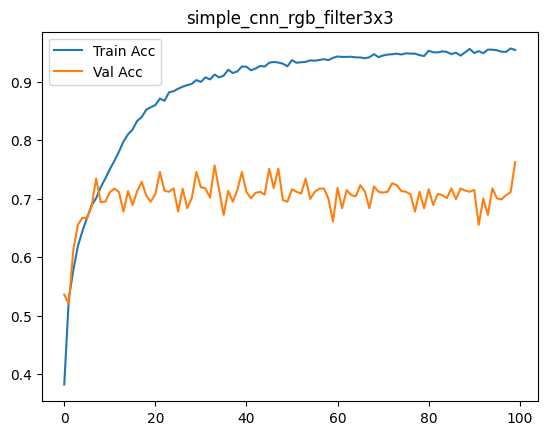

In [ ]:
plt.plot(gl_history[model_name].history['accuracy'])
plt.plot(gl_history[model_name].history['val_accuracy'])
plt.legend(['Train Acc','Val Acc'])
plt.title(model_name)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step  
Logits [1. 0. 0. 0.] should sum up to 1.0: True


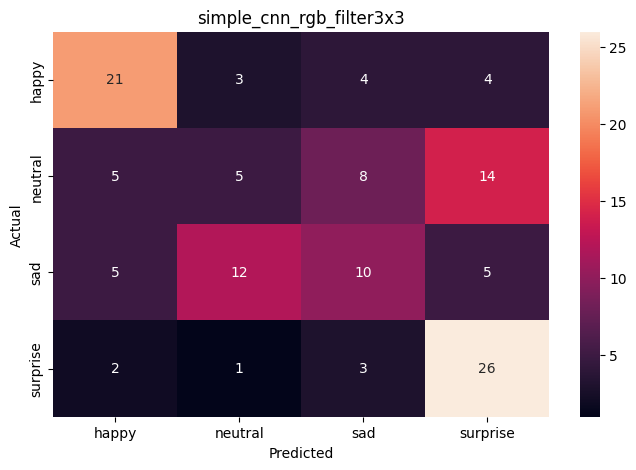

In [ ]:
gl_clrep[model_name], gl_cm[model_name] = compute_test_stats(model_name,
                                                             datasets_rgb,
                                                             y_test)

In [ ]:
df_models, df_model = create_dfs(model_name,
                                gl_clrep[model_name],
                                df_models)
df_model

happy    neutral        sad   surprise  \
Model                    Metric                                                 
simple_cnn_rgb_2x2_under precision   0.55814   0.545455   0.333333   0.446154   
                         recall      0.75000   0.187500   0.093750   0.906250   
                         f1-score    0.64000   0.279070   0.146341   0.597938   
                         support    32.00000  32.000000  32.000000  32.000000   

                                    accuracy   macro avg  weighted avg  
Model                    Metric                                         
simple_cnn_rgb_2x2_under precision  0.484375    0.470770      0.470770  
                         recall     0.484375    0.484375      0.484375  
                         f1-score   0.484375    0.415837      0.415837  
                         support    0.484375  128.000000    128.000000

In [ ]:
save_learning_data(model_name,
                   gl_history[model_name],
                   gl_clrep[model_name],
                   gl_cm[model_name]
                  )

backend.clear_session()

Text(0.5, 1.0, 'RGB 2x2 vs. RGB 3x3 Simple CNN performance')

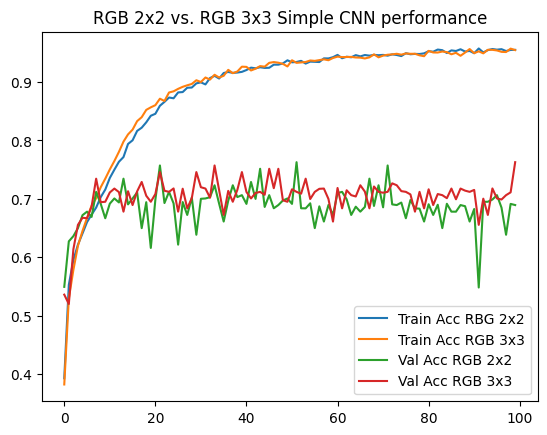

In [ ]:
plt.plot(gl_history['simple_cnn_rgb'].history['accuracy'])
plt.plot(gl_history['simple_cnn_rgb_filter3x3'].history['accuracy'])
plt.plot(gl_history['simple_cnn_rgb'].history['val_accuracy'])
plt.plot(gl_history['simple_cnn_rgb_filter3x3'].history['val_accuracy'])
plt.legend(['Train Acc RBG 2x2','Train Acc RGB 3x3', 'Val Acc RGB 2x2', 'Val Acc RGB 3x3'])

plt.title('RGB 2x2 vs. RGB 3x3 Simple CNN performance')

**Observations and Insights:__**

<b>Model Structure</b>

The structure is the same as described in the previous section.
We only change a kernel size to 3.

<b>Training results</b>

In this section, we test RGB version of Simple CNN.
This means that input shape is (48,48,3).

According to the learning curves, until around 12th epoch,
train accuracy and validation accuracy are very simular.

During the learning the best model is defined in terms of max validation accuracy. This best model is then evaluated using test dataset.

After this epoch, training accuracy increases rapidly reaching max value of 0.957. While validation accuracy oscillates around mean value of 0.703.

This indicates strong overfitting of the model.

The overall performance on test data result in low value of precision, recall and f1-score, i.e., weighted average for these metrics are 0.451, 0.484 and 0.457 respectively.

This values are essentially lower than corresponding valus for precision, recall and f1-score in the case of RBG version with kernel size 2: 0.543, 0.539 and 0.519 respectively.

<b>2x2 vs. 3x3 kernel size: conclusion</b>

Apparently RBG version with kernel size 2 exhibits much better performance over the RGB version with kernel size 3.

However, the oscillations validation accuracy for RBG version with kernel 2 has higher variance, which indicates less stability of the network during training.

## **Simple CNN RGB kernel size 2x2 and Under-sampling**

Under-sample original validation dataset

In [ ]:
from imblearn.under_sampling import RandomUnderSampler
X_train_rgb = datasets_rgb['Xtrain']
X_train_bw = datasets_data['Xtrain']

X_train_rgb = X_train_rgb.reshape(X_train_rgb.shape[0],-1)
X_train_bw = X_train_bw.reshape(X_train_bw.shape[0],-1)

Y_train = np.array(datasets_data['Ytrain'])

# define undersample strategy
undersample = RandomUnderSampler(sampling_strategy='majority')
# fit and apply the transform
X_train_rgb_under, Y_train_rgb_under = undersample.fit_resample(X_train_rgb, Y_train)
X_train_bw_under, Y_train_bw_under = undersample.fit_resample(X_train_bw, Y_train)

Confirm sample disribution after down sample

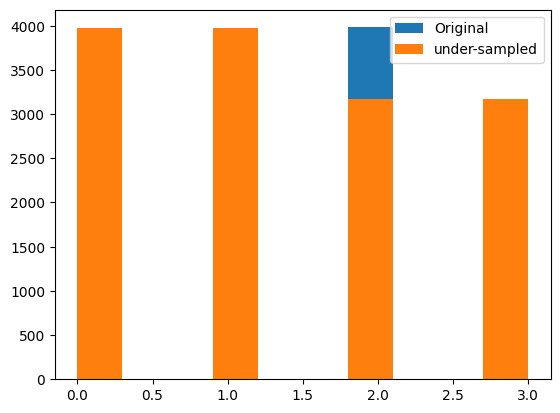

In [ ]:
plt.hist(np.argmax(Y_train, axis=-1))
plt.hist(np.argmax(Y_train_rgb_under, axis=-1))

plt.legend(['Original','under-sampled'])

In [ ]:
datasets_rgb['Xtrain_under'] = X_train_rgb_under.reshape(X_train_rgb_under.shape[0],48,48,3)
datasets_rgb['Ytrain_under'] = Y_train_rgb_under

datasets_data['Xtrain_under'] = X_train_bw_under.reshape(X_train_bw_under.shape[0],48,48,1)
datasets_data['Ytrain_under'] = Y_train_bw_under

Create Dataloaders for undersampled data

In [ ]:
batch_size  = 32
img_size = 48
color_mode = 'grayscale'
folder_path = ''

datagen_train_rgb_under = ImageDataGenerator(rescale=1./255)
train_set_rgb_under = datagen_train_rgb_under.flow(x=datasets_rgb['Xtrain_under'],
                                                   y=datasets_rgb['Ytrain_under'],
                                                   batch_size=batch_size,
                                                   shuffle=True)

datagen_train_bw_under = ImageDataGenerator(rescale=1./255)
train_set_bw_under = datagen_train_bw_under.flow(x=datasets_data['Xtrain_under'],
                                                   y=datasets_data['Ytrain_under'],
                                                   batch_size=batch_size,
                                                   shuffle=True)


In [ ]:
model_name = get_model_name('simple_cnn_rgb_2x2_under')

print(f'>>>> Model name: {model_name}')
model_config_local['model_name'] = model_name
model_config_local['input_shape'] = (48, 48, 3)
model_config_local['kernel_size'] = (2, 2)

with open(f"/content/drive/MyDrive/MIT_PE/model_configs/{model_name}.json", 'w') as fp:
    json.dump(model_config_local, fp)

>>>> Model name: simple_cnn_rgb_2x2_under


### **Compiling and Training the Model**

In [ ]:
np.random.seed(42)
import random
random.seed(42)
tf.random.set_seed(42)

checkpoint = ModelCheckpoint(f"/content/drive/MyDrive/MIT_PE/trained_models/{model_name}.keras",
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True,
                             mode='max')

callback_dict["checkpoint"] = checkpoint
callback_list = [callback_dict[item] for item in model_config_local['callback_list']]

np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

gl_models[model_name] = simple_cnn_run_config(model_config_local)

gl_history[model_name] = gl_models[model_name] .fit(train_set_rgb_under,
                                                    steps_per_epoch=model_config_local['steps_per_epoch'],
                                                    epochs=model_config_local['epochs'],
                                                    validation_data=validation_set_rgb,
                                                    validation_steps=model_config_local['validation_steps'],
                                                    callbacks=callback_list,
                                                    class_weight=model_config_local['cl_w']
                                                    )

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


447/500 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.3253 - loss: 1.3430

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 1: val_accuracy improved from -inf to 0.53667, saving model to /content/drive/MyDrive/MIT_PE/trained_models/simple_cnn_rgb_2x2_under.keras
500/500 ━━━━━━━━━━━━━━━━━━━━ 21s 25ms/step - accuracy: 0.3328 - loss: 1.3348 - val_accuracy: 0.5367 - val_loss: 1.0749
Epoch 2/100
444/500 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5562 - loss: 1.0465
Epoch 2: val_accuracy improved from 0.53667 to 0.63277, saving model to /content/drive/MyDrive/MIT_PE/trained_models/simple_cnn_rgb_2x2_under.keras
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.5571 - loss: 1.0436 - val_accuracy: 0.6328 - val_loss: 0.9334
Epoch 3/100
440/500 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6050 - loss: 0.9481
Epoch 3: val_accuracy improved from 0.63277 to 0.64438, saving model to /content/drive/MyDrive/MIT_PE/trained_models/simple_cnn_rgb_2x2_under.keras
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.6054 - loss: 0.9470 - val_accuracy: 0.6444 - val_loss: 0.8647
Epoch 4/100
447/500 ━━━━━━━━━━━

Text(0.5, 1.0, 'simple_cnn_rgb_2x2_under')

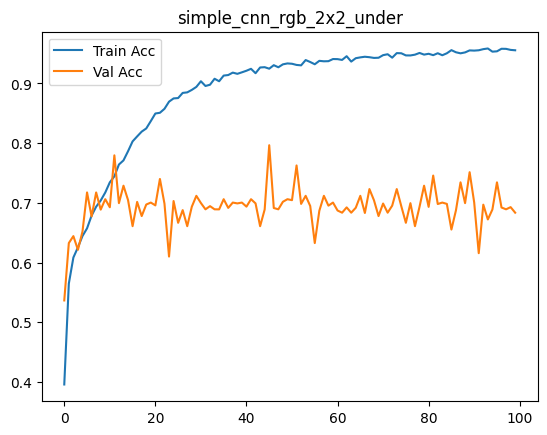

In [ ]:
plt.plot(gl_history[model_name].history['accuracy'])
plt.plot(gl_history[model_name].history['val_accuracy'])
plt.legend(['Train Acc','Val Acc'])
plt.title(model_name)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step  
Logits [1. 0. 0. 0.] should sum up to 1.0: True


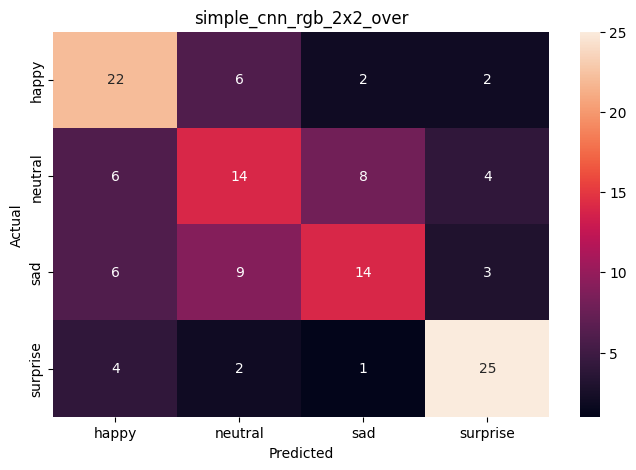

In [ ]:
gl_clrep[model_name], gl_cm[model_name] = compute_test_stats(model_name,
                                                             datasets_rgb,
                                                             y_test)

In [ ]:
df_models, df_model = create_dfs(model_name,
                                gl_clrep[model_name],
                                df_models)
df_model

happy    neutral        sad   surprise  \
Model                    Metric                                                 
simple_cnn_rgb_2x2_under precision   0.55814   0.545455   0.333333   0.446154   
                         recall      0.75000   0.187500   0.093750   0.906250   
                         f1-score    0.64000   0.279070   0.146341   0.597938   
                         support    32.00000  32.000000  32.000000  32.000000   

                                    accuracy   macro avg  weighted avg  
Model                    Metric                                         
simple_cnn_rgb_2x2_under precision  0.484375    0.470770      0.470770  
                         recall     0.484375    0.484375      0.484375  
                         f1-score   0.484375    0.415837      0.415837  
                         support    0.484375  128.000000    128.000000

In [ ]:
save_learning_data(model_name,
                   gl_history[model_name],
                   gl_clrep[model_name],
                   gl_cm[model_name]
                  )

backend.clear_session()

Over-sampling

In [28]:
from imblearn.over_sampling import SMOTE

In [29]:
X_train_rgb = datasets_rgb['Xtrain']
X_train_rgb = X_train_rgb.reshape(X_train_rgb.shape[0],-1)

X_train_bw = datasets_data['Xtrain']
X_train_bw = X_train_bw.reshape(X_train_bw.shape[0],-1)

Y_train = np.array(datasets_data['Ytrain'])

# fit and apply the transform
sm = SMOTE(random_state=42)
X_train_rgb_over, Y_train_rgb_over = sm.fit_resample(X_train_rgb, Y_train)
sm = SMOTE(random_state=42)
X_train_bw_over, Y_train_bw_over = sm.fit_resample(X_train_bw, Y_train)

Confirm distribution of samples after over-sampling using SMOTE

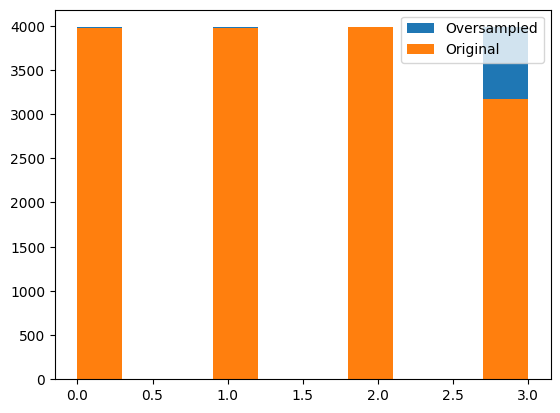

In [30]:
plt.hist(np.argmax(Y_train_rgb_over, axis=-1))
plt.hist(np.argmax(Y_train, axis=-1))
plt.legend(['Oversampled','Original'])

In [31]:
datasets_rgb['Xtrain_over'] = X_train_rgb_over.reshape(X_train_rgb_over.shape[0],48,48,3)
datasets_rgb['Ytrain_over'] = Y_train_rgb_over

datasets_data['Xtrain_over'] = X_train_bw_over.reshape(X_train_bw_over.shape[0],48,48,1)
datasets_data['Ytrain_over'] = Y_train_bw_over

In [32]:
batch_size  = 32

datagen_train_rgb_over = ImageDataGenerator(rescale=1./255)
train_set_rgb_over = datagen_train_rgb_over.flow(x=datasets_rgb['Xtrain_over'],
                                                          y=datasets_rgb['Ytrain_over'],
                                                          batch_size=batch_size,
                                                          shuffle=True)

In [ ]:
model_name = get_model_name('simple_cnn_rgb_2x2_over')

print(f'>>>> Model name: {model_name}')
model_config_local['model_name'] = model_name
model_config_local['input_shape'] = (48, 48, 3)
model_config_local['kernel_size'] = (2, 2)

with open(f"/content/drive/MyDrive/MIT_PE/model_configs/{model_name}.json", 'w') as fp:
    json.dump(model_config_local, fp)

>>>> Model name: simple_cnn_rgb_2x2_over


### **Compiling and Training the Model**

In [ ]:
checkpoint = ModelCheckpoint(f"/content/drive/MyDrive/MIT_PE/trained_models/{model_name}.keras",
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True,
                             mode='max')

callback_dict["checkpoint"] = checkpoint
callback_list = [callback_dict[item] for item in model_config_local['callback_list']]

np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

gl_models[model_name] = simple_cnn_run_config(model_config_local)

gl_history[model_name] = gl_models[model_name] .fit(train_set_rgb_over,
                                                    steps_per_epoch=model_config_local['steps_per_epoch'],
                                                    epochs=model_config_local['epochs'],
                                                    validation_data=validation_set_rgb,
                                                    validation_steps=model_config_local['validation_steps'],
                                                    callbacks=callback_list,
                                                    class_weight=model_config_local['cl_w']
                                                    )

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


491/500 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.3257 - loss: 1.3434

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 1: val_accuracy improved from -inf to 0.52896, saving model to /content/drive/MyDrive/MIT_PE/trained_models/simple_cnn_rgb_2x2_over.keras
500/500 ━━━━━━━━━━━━━━━━━━━━ 21s 17ms/step - accuracy: 0.3270 - loss: 1.3420 - val_accuracy: 0.5290 - val_loss: 1.1136
Epoch 2/100
495/500 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5246 - loss: 1.0864
Epoch 2: val_accuracy improved from 0.52896 to 0.58757, saving model to /content/drive/MyDrive/MIT_PE/trained_models/simple_cnn_rgb_2x2_over.keras
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.5248 - loss: 1.0860 - val_accuracy: 0.5876 - val_loss: 0.9778
Epoch 3/100
496/500 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5894 - loss: 0.9587
Epoch 3: val_accuracy improved from 0.58757 to 0.63896, saving model to /content/drive/MyDrive/MIT_PE/trained_models/simple_cnn_rgb_2x2_over.keras
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.5895 - loss: 0.9587 - val_accuracy: 0.6390 - val_loss: 0.8998
Epoch 4/100
491/500 ━━━━━━━━━━━━━━

Text(0.5, 1.0, 'simple_cnn_rgb_2x2_over')

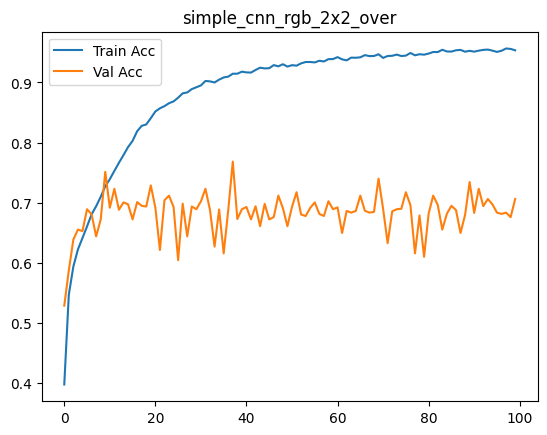

In [ ]:
plt.plot(gl_history[model_name].history['accuracy'])
plt.plot(gl_history[model_name].history['val_accuracy'])
plt.legend(['Train Acc','Val Acc'])
plt.title(model_name)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  
Logits [1. 0. 0. 0.] should sum up to 1.0: True


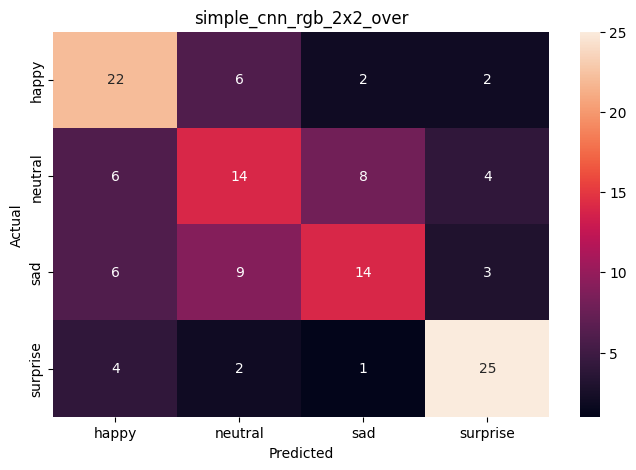

In [ ]:
gl_clrep[model_name], gl_cm[model_name] = compute_test_stats(model_name,
                                                             datasets_rgb,
                                                             y_test)

In [ ]:
df_models, df_model = create_dfs(model_name,
                                gl_clrep[model_name],
                                df_models)
df_model

happy    neutral        sad   surprise  \
Model                   Metric                                                  
simple_cnn_rgb_2x2_over precision   0.578947   0.451613   0.560000   0.735294   
                        recall      0.687500   0.437500   0.437500   0.781250   
                        f1-score    0.628571   0.444444   0.491228   0.757576   
                        support    32.000000  32.000000  32.000000  32.000000   

                                   accuracy   macro avg  weighted avg  
Model                   Metric                                         
simple_cnn_rgb_2x2_over precision  0.585938    0.581464      0.581464  
                        recall     0.585938    0.585938      0.585938  
                        f1-score   0.585938    0.580455      0.580455  
                        support    0.585938  128.000000    128.000000

In [ ]:
save_learning_data(model_name,
                   gl_history[model_name],
                   gl_clrep[model_name],
                   gl_cm[model_name]
                  )

backend.clear_session()

In [ ]:
df_models = df_models.drop_duplicates()
df_models


happy    neutral        sad  \
Model                    Metric                                       
simple_cnn_grayscale     precision   0.571429   0.344828   0.250000   
                         recall      0.625000   0.312500   0.156250   
                         f1-score    0.597015   0.327869   0.192308   
                         support    32.000000  32.000000  32.000000   
simple_cnn_rgb           precision   0.600000   0.571429   0.468750   
                         recall      0.656250   0.250000   0.468750   
                         f1-score    0.626866   0.347826   0.468750   
                         support    32.000000  32.000000  32.000000   
simple_cnn_rgb_filter3x3 precision   0.636364   0.238095   0.400000   
                         recall      0.656250   0.156250   0.312500   
                         f1-score    0.646154   0.188679   0.350877   
                         support    32.000000  32.000000  32.000000   
simple_cnn_rgb_2x2_under precision   0.558140   0.545455   0.333333   
                         recall      0.750000   0.187500   0.093750   
                         f1-score    0.640000   0.279070   0.146341   
simple_cnn_rgb_2x2_over  precision   0.578947   0.451613   0.560000   
                         recall      0.687500   0.437500   0.437500   
                         f1-score    0.628571   0.444444   0.491228   
                         support    32.000000  32.000000  32.000000   

                                     surprise  accuracy   macro avg  \
Model                    Metric                                       
simple_cnn_grayscale     precision   0.568182  0.468750    0.433609   
                         recall      0.781250  0.468750    0.468750   
                         f1-score    0.657895  0.468750    0.443772   
                         support    32.000000  0.468750  128.000000   
simple_cnn_rgb           precision   0.531915  0.539062    0.543023   
                         recall      0.781250  0.539062    0.539062   
                         f1-score    0.632911  0.539062    0.519088   
                         support    32.000000  0.539062  128.000000   
simple_cnn_rgb_filter3x3 precision   0.530612  0.484375    0.451268   
                         recall      0.812500  0.484375    0.484375   
                         f1-score    0.641975  0.484375    0.456921   
                         support    32.000000  0.484375  128.000000   
simple_cnn_rgb_2x2_under precision   0.446154  0.484375    0.470770   
                         recall      0.906250  0.484375    0.484375   
                         f1-score    0.597938  0.484375    0.415837   
simple_cnn_rgb_2x2_over  precision   0.735294  0.585938    0.581464   
                         recall      0.781250  0.585938    0.585938   
                         f1-score    0.757576  0.585938    0.580455   
                         support    32.000000  0.585938  128.000000   

                                    weighted avg  
Model                    Metric                   
simple_cnn_grayscale     precision      0.433609  
                         recall         0.468750  
                         f1-score       0.443772  
                         support      128.000000  
simple_cnn_rgb           precision      0.543023  
                         recall         0.539062  
                         f1-score       0.519088  
                         support      128.000000  
simple_cnn_rgb_filter3x3 precision      0.451268  
                         recall         0.484375  
                         f1-score       0.456921  
                         support      128.000000  
simple_cnn_rgb_2x2_under precision      0.470770  
                         recall         0.484375  
                         f1-score       0.415837  
simple_cnn_rgb_2x2_over  precision      0.581464  
                         recall         0.585938  
                         f1-score       0.580455  
                         support    

**Observations and Insights:__**

<b>Dataset</b>
In this case, we experimented with dataset sampling.
We have observed that for train set, surprise class is about 20% under-sampled.
while validation dataset is heavily unbalance across all the classes.

There 2 way how to modify train dataset:
- reduce number of samples in classes to the number of samples in class with minimum number of samples

- increase number of samples in under-sampled classes.

<b>Model Structure</b>

The structure is the same as described in the previous section.
We only change a kernel size to 2.

<b>Training results</b>

During the learning the best model is defined in terms of max validation accuracy. This best model is then evaluated using test dataset.

According to the overal table,
model train on undersampled data (simple_cnn_rgb_2x2_under), shows results better than simple_cnn_grayscale and simple_cnn_rgb_filter3x3.

However, this model has lower performance than simple_cnn_rgb_2x2 and simple_cnn_rgb_2x2_over.

Moreover, simple_cnn_rgb_2x2_over model has so far the highers performance having precision, recall and f1-score as 0.581, 0.586 and 0.580.


<b>Overall conclusion</b>

So far RBG version of simple CNN with kernel size 2 trained on oversampled data exhibits the best performance.

## **Test various batch sizes**

## **Simple CNN RGB Oversampling batch_size=64**

In [ ]:
model_config_local['model_name'] = model_name
model_config_local['input_shape'] = (48, 48, 3)
model_config_local['kernel_size'] = (2, 2)
model_config_local['batch_size'] = 64

with open(f"/content/drive/MyDrive/MIT_PE/model_configs/{model_name}.json", 'w') as fp:
    json.dump(model_config_local, fp)

model_name = f"simple_cnn_rgb_2x2_over_{model_config_local['batch_size']}"
print(f'>>>> Model name: {model_name}')

>>>> Model name: simple_cnn_rgb_2x2_over_64


### **Compiling and Training the Model**

In [ ]:
checkpoint = ModelCheckpoint(f"/content/drive/MyDrive/MIT_PE/trained_models/{model_name}.keras",
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True,
                             mode='max')

callback_dict["checkpoint"] = checkpoint
callback_list = [callback_dict[item] for item in model_config_local['callback_list']]

np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

gl_models[model_name] = simple_cnn_run_config(model_config_local)

train_set_rgb_over_64 = datagen_train_rgb_over.flow(x=datasets_rgb['Xtrain_over'],
                                                          y=datasets_rgb['Ytrain_over'],
                                                          batch_size=model_config_local['batch_size'],
                                                          shuffle=True)

gl_history[model_name] = gl_models[model_name].fit(train_set_rgb_over_64,
                                                    steps_per_epoch=model_config_local['steps_per_epoch'],
                                                    epochs=model_config_local['epochs'],
                                                    validation_data=validation_set_rgb,
                                                    validation_steps=model_config_local['validation_steps'],
                                                    callbacks=callback_list,
                                                    class_weight=model_config_local['cl_w']
                                                    )

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


247/500 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - accuracy: 0.3197 - loss: 1.3512

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 1: val_accuracy improved from -inf to 0.54813, saving model to /content/drive/MyDrive/MIT_PE/trained_models/simple_cnn_rgb_2x2_over_64.keras
500/500 ━━━━━━━━━━━━━━━━━━━━ 19s 21ms/step - accuracy: 0.3552 - loss: 1.3146 - val_accuracy: 0.5481 - val_loss: 1.0822
Epoch 2/100
245/500 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.5283 - loss: 1.0936
Epoch 2: val_accuracy improved from 0.54813 to 0.57062, saving model to /content/drive/MyDrive/MIT_PE/trained_models/simple_cnn_rgb_2x2_over_64.keras
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.5385 - loss: 1.0747 - val_accuracy: 0.5706 - val_loss: 0.9991
Epoch 3/100
245/500 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.5896 - loss: 0.9701
Epoch 3: val_accuracy improved from 0.57062 to 0.63833, saving model to /content/drive/MyDrive/MIT_PE/trained_models/simple_cnn_rgb_2x2_over_64.keras
500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.5913 - loss: 0.9643 - val_accuracy: 0.6383 - val_loss: 0.8747
Epoch 4/100
242/500 ━━━

Text(0.5, 1.0, 'simple_cnn_rgb_2x2_over_64')

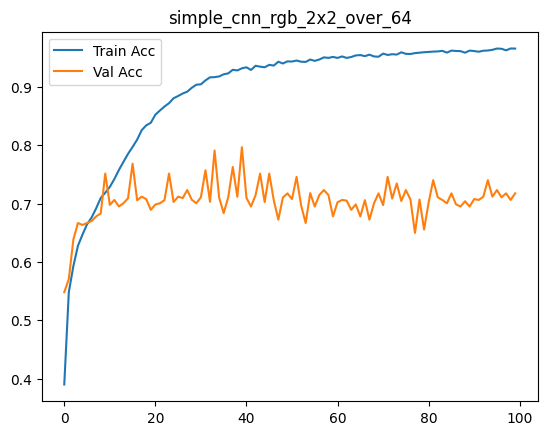

In [ ]:
plt.plot(gl_history[model_name].history['accuracy'])
plt.plot(gl_history[model_name].history['val_accuracy'])
plt.legend(['Train Acc','Val Acc'])
plt.title(model_name)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step  
Logits [1. 0. 0. 0.] should sum up to 1.0: True


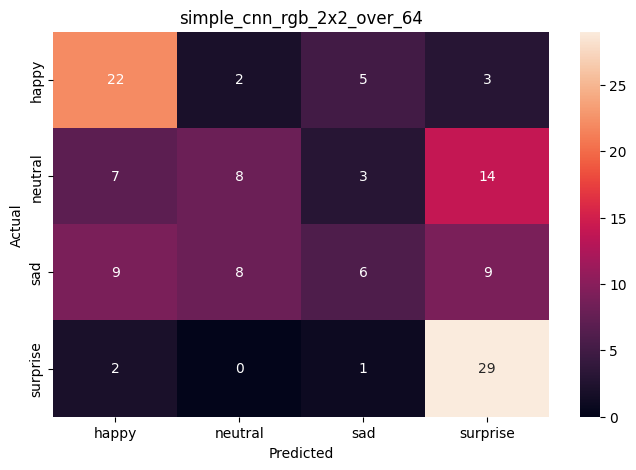

In [ ]:
gl_clrep[model_name], gl_cm[model_name] = compute_test_stats(model_name,
                                                             datasets_rgb,
                                                             y_test)

In [ ]:
df_models, df_model = create_dfs(model_name,
                                gl_clrep[model_name],
                                df_models)
df_model

happy    neutral        sad  \
Model                      Metric                                       
simple_cnn_rgb_2x2_over_64 precision   0.550000   0.444444   0.400000   
                           recall      0.687500   0.250000   0.187500   
                           f1-score    0.611111   0.320000   0.255319   
                           support    32.000000  32.000000  32.000000   

                                       surprise  accuracy   macro avg  \
Model                      Metric                                       
simple_cnn_rgb_2x2_over_64 precision   0.527273  0.507812    0.480429   
                           recall      0.906250  0.507812    0.507812   
                           f1-score    0.666667  0.507812    0.463274   
                           support    32.000000  0.507812  128.000000   

                                      weighted avg  
Model                      Metric                   
simple_cnn_rgb_2x2_over_64 precision      0.480429  
                           recall         0.507812  
                           f1-score       0.463274  
                           support      128.000000

In [ ]:
save_learning_data(model_name,
                   gl_history[model_name],
                   gl_clrep[model_name],
                   gl_cm[model_name]
                  )

backend.clear_session()

RGB Oversampling batch_size=128

In [ ]:
model_name = get_model_name('simple_cnn_rgb_2x2_over_128')

print(f'>>>> Model name: {model_name}')
model_config_local['model_name'] = model_name
model_config_local['input_shape'] = (48, 48, 3)
model_config_local['kernel_size'] = (2, 2)
model_config_local['batch_size'] = 128

with open(f"/content/drive/MyDrive/MIT_PE/model_configs/{model_name}.json", 'w') as fp:
    json.dump(model_config_local, fp)

>>>> Model name: simple_cnn_rgb_2x2_over_128


### **Compiling and Training the Model**

In [ ]:
checkpoint = ModelCheckpoint(f"/content/drive/MyDrive/MIT_PE/trained_models/{model_name}.keras",
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True,
                             mode='max')

callback_dict["checkpoint"] = checkpoint
callback_list = [callback_dict[item] for item in model_config_local['callback_list']]

np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

gl_models[model_name] = simple_cnn_run_config(model_config_local)

train_set_rgb_over_128 = datagen_train_rgb_over.flow(x=datasets_rgb['Xtrain_over'],
                                                          y=datasets_rgb['Ytrain_over'],
                                                          batch_size=model_config_local['batch_size'],
                                                          shuffle=True)

gl_history[model_name] = gl_models[model_name].fit(train_set_rgb_over_128,
                                                    steps_per_epoch=model_config_local['steps_per_epoch'],
                                                    epochs=model_config_local['epochs'],
                                                    validation_data=validation_set_rgb,
                                                    validation_steps=model_config_local['validation_steps'],
                                                    callbacks=callback_list,
                                                    class_weight=model_config_local['cl_w']
                                                    )

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


122/500 ━━━━━━━━━━━━━━━━━━━━ 20s 54ms/step - accuracy: 0.2873 - loss: 1.3864

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 1: val_accuracy improved from -inf to 0.43292, saving model to /content/drive/MyDrive/MIT_PE/trained_models/simple_cnn_rgb_2x2_over_128.keras
500/500 ━━━━━━━━━━━━━━━━━━━━ 14s 16ms/step - accuracy: 0.3129 - loss: 1.3610 - val_accuracy: 0.4329 - val_loss: 1.2564
Epoch 2/100
122/500 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.4553 - loss: 1.2061
Epoch 2: val_accuracy improved from 0.43292 to 0.56497, saving model to /content/drive/MyDrive/MIT_PE/trained_models/simple_cnn_rgb_2x2_over_128.keras
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.4740 - loss: 1.1801 - val_accuracy: 0.5650 - val_loss: 1.0861
Epoch 3/100
124/500 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.5402 - loss: 1.0714
Epoch 3: val_accuracy improved from 0.56497 to 0.60458, saving model to /content/drive/MyDrive/MIT_PE/trained_models/simple_cnn_rgb_2x2_over_128.keras
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5491 - loss: 1.0566 - val_accuracy: 0.6046 - val_loss: 0.9551
Epoch 4/100
125/500 

Text(0.5, 1.0, 'simple_cnn_rgb_2x2_over_128')

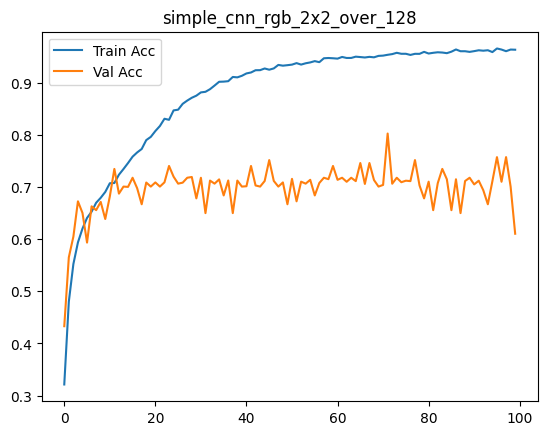

In [ ]:
plt.plot(gl_history[model_name].history['accuracy'])
plt.plot(gl_history[model_name].history['val_accuracy'])
plt.legend(['Train Acc','Val Acc'])
plt.title(model_name)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step  
Logits [1.000000e+00 0.000000e+00 0.000000e+00 2.537681e-39] should sum up to 1.0: True


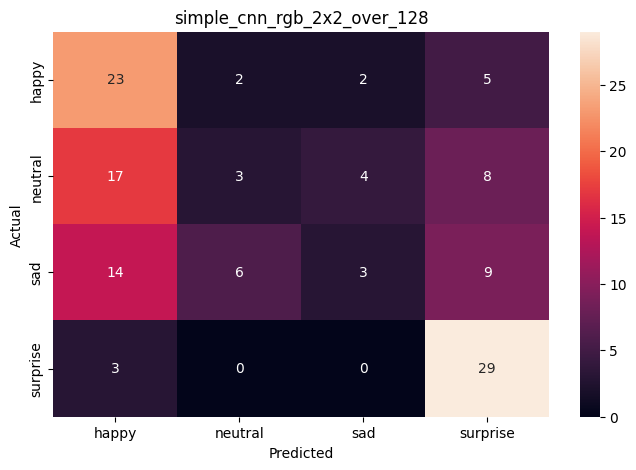

In [ ]:
gl_clrep[model_name], gl_cm[model_name] = compute_test_stats(model_name,
                                                             datasets_rgb,
                                                             y_test)

In [ ]:
df_models, df_model = create_dfs(model_name,
                                gl_clrep[model_name],
                                df_models)
df_model

happy    neutral        sad  \
Model                       Metric                                       
simple_cnn_rgb_2x2_over_128 precision   0.403509   0.272727   0.333333   
                            recall      0.718750   0.093750   0.093750   
                            f1-score    0.516854   0.139535   0.146341   
                            support    32.000000  32.000000  32.000000   

                                        surprise  accuracy   macro avg  \
Model                       Metric                                       
simple_cnn_rgb_2x2_over_128 precision   0.568627  0.453125    0.394549   
                            recall      0.906250  0.453125    0.453125   
                            f1-score    0.698795  0.453125    0.375381   
                            support    32.000000  0.453125  128.000000   

                                       weighted avg  
Model                       Metric                   
simple_cnn_rgb_2x2_over_128 precision      0.394549  
                            recall         0.453125  
                            f1-score       0.375381  
                            support      128.000000

In [ ]:
save_learning_data(model_name,
                   gl_history[model_name],
                   gl_clrep[model_name],
                   gl_cm[model_name]
                  )

backend.clear_session()

RGB Oversampling batch_size=256

In [ ]:
model_name = get_model_name('simple_cnn_rgb_2x2_over_256')

print(f'>>>> Model name: {model_name}')
model_config_local['model_name'] = model_name
model_config_local['input_shape'] = (48, 48, 3)
model_config_local['kernel_size'] = (2, 2)
model_config_local['batch_size'] = 256

with open(f"/content/drive/MyDrive/MIT_PE/model_configs/{model_name}.json", 'w') as fp:
    json.dump(model_config_local, fp)

>>>> Model name: simple_cnn_rgb_2x2_over_256


### **Compiling and Training the Model**

In [ ]:
checkpoint = ModelCheckpoint(f"/content/drive/MyDrive/MIT_PE/trained_models/{model_name}.keras",
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True,
                             mode='max')

callback_dict["checkpoint"] = checkpoint
callback_list = [callback_dict[item] for item in model_config_local['callback_list']]

np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

gl_models[model_name] = simple_cnn_run_config(model_config_local)

train_set_rgb_over_256 = datagen_train_rgb_over.flow(x=datasets_rgb['Xtrain_over'],
                                                          y=datasets_rgb['Ytrain_over'],
                                                          batch_size=model_config_local['batch_size'],
                                                          shuffle=True)

gl_history[model_name] = gl_models[model_name].fit(train_set_rgb_over_256,
                                                    steps_per_epoch=model_config_local['steps_per_epoch'],
                                                    epochs=model_config_local['epochs'],
                                                    validation_data=validation_set_rgb,
                                                    validation_steps=model_config_local['validation_steps'],
                                                    callbacks=callback_list,
                                                    class_weight=model_config_local['cl_w']
                                                    )

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 62/500 ━━━━━━━━━━━━━━━━━━━━ 56s 129ms/step - accuracy: 0.2817 - loss: 1.3847

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 1: val_accuracy improved from -inf to 0.32792, saving model to /content/drive/MyDrive/MIT_PE/trained_models/simple_cnn_rgb_2x2_over_256.keras
500/500 ━━━━━━━━━━━━━━━━━━━━ 18s 19ms/step - accuracy: 0.3043 - loss: 1.3715 - val_accuracy: 0.3279 - val_loss: 1.3489
Epoch 2/100
 62/500 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.3838 - loss: 1.3086
Epoch 2: val_accuracy improved from 0.32792 to 0.56497, saving model to /content/drive/MyDrive/MIT_PE/trained_models/simple_cnn_rgb_2x2_over_256.keras
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.4115 - loss: 1.2707 - val_accuracy: 0.5650 - val_loss: 1.0643
Epoch 3/100
 61/500 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.5111 - loss: 1.1401
Epoch 3: val_accuracy improved from 0.56497 to 0.56833, saving model to /content/drive/MyDrive/MIT_PE/trained_models/simple_cnn_rgb_2x2_over_256.keras
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5221 - loss: 1.1123 - val_accuracy: 0.5683 - val_loss: 1.0475
Epoch 4/100
 63/50

Text(0.5, 1.0, 'simple_cnn_rgb_2x2_over_256')

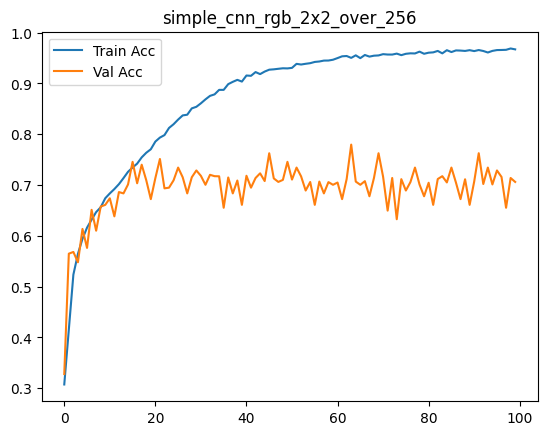

In [ ]:
model_name = 'simple_cnn_rgb_2x2_over_256'
plt.plot(gl_history[model_name].history['accuracy'])
plt.plot(gl_history[model_name].history['val_accuracy'])
plt.legend(['Train Acc','Val Acc'])
plt.title(model_name)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step  
Logits [1. 0. 0. 0.] should sum up to 1.0: True


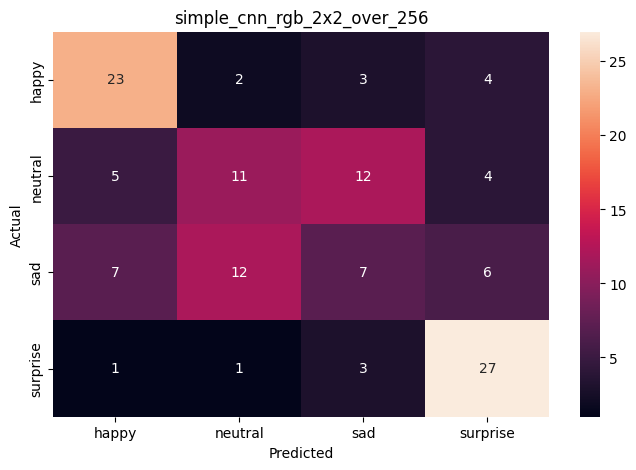

In [ ]:
gl_clrep[model_name], gl_cm[model_name] = compute_test_stats(model_name,
                                                             datasets_rgb,
                                                             y_test)

In [ ]:
df_models, df_model = create_dfs(model_name,
                                gl_clrep[model_name],
                                df_models)
df_model

happy    neutral        sad  \
Model                       Metric                                       
simple_cnn_rgb_2x2_over_256 precision   0.638889   0.423077   0.280000   
                            recall      0.718750   0.343750   0.218750   
                            f1-score    0.676471   0.379310   0.245614   
                            support    32.000000  32.000000  32.000000   

                                        surprise  accuracy   macro avg  \
Model                       Metric                                       
simple_cnn_rgb_2x2_over_256 precision   0.658537   0.53125    0.500126   
                            recall      0.843750   0.53125    0.531250   
                            f1-score    0.739726   0.53125    0.510280   
                            support    32.000000   0.53125  128.000000   

                                       weighted avg  
Model                       Metric                   
simple_cnn_rgb_2x2_over_256 precision      0.500126  
                            recall         0.531250  
                            f1-score       0.510280  
                            support      128.000000

In [ ]:
save_learning_data(model_name,
                   gl_history[model_name],
                   gl_clrep[model_name],
                   gl_cm[model_name]
                  )

backend.clear_session()

**Observations and Insights:__**

<b>Dataset</b>
In this case, we experimented with batch size.
In addition batch size 32 which was used until now, we test model performance for batch size 64, 128 and 256 for training data.

Batch size for validation data and test data remains the same, i.e., 32, since batch size for these datasets does not impact training.

<b>Model Structure</b>

<b>Training results</b>

We have obtained resutls for 4 models:
- simple cnn rgb 2x2 (kernel) and batch size 32
- simple cnn rgb 2x2 (kernel) and batch size 64
- simple cnn rgb 2x2 (kernel) and batch size 128
- simple cnn rgb 2x2 (kernel) and batch size 256

Precision:
32 - 0.543, 64 - 0.480, 128 - 0.395, 256 - 0.500

Recall:
32 - 0.539, 64 - 0.507, 128 - 0.453, 256 - 0.531

f1 score:
32 - 0.519, 64 - 0.469, 128 - 0.350, 256 - 0.510

test acc:
32 - 0.539, 64 - 0.509, 128 - 0.453, 256 - 0.531

We can see that all four metrics are reducing until batch size 256, where all this values spike, but this spike is still smaller that the value for batch size 32.

Furthermore, when inspecting learning curves, no pricipal difference is observed, i.e., all 4 models exhibit heavy overfitting. Therefore is this case there is no obvious regularization effect of batch size

<b>Overall conclusion</b>

Among four values of the batch size, a model with batch size 32 for over sampled data shows the best results.

## **Simple CNN RGB with Oversampling + Regularization**

### **Compiling and Training the Model**

In [ ]:
model_name = 'simple_cnn_rgb_2x2_over_32_active_reg'

print(f'>>>> Model name: {model_name}')
model_config_local['model_name'] = model_name
model_config_local['input_shape'] = (48, 48, 3)
model_config_local['kernel_size'] = (2, 2)
model_config_local['batch_size'] = 32
model_config_local['activ_reg'] = True
model_config_local['callback_list'] = ['checkpoint','early_stopping','reduce_learningrate']

with open(f"/content/drive/MyDrive/MIT_PE/model_configs/{model_name}.json", 'w') as fp:
    json.dump(model_config_local, fp)


checkpoint = ModelCheckpoint(f"/content/drive/MyDrive/MIT_PE/trained_models/{model_name}.keras",
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True,
                             mode='max')

callback_dict["checkpoint"] = checkpoint
callback_list = [callback_dict[item] for item in model_config_local['callback_list']]

gl_models[model_name] = simple_cnn_run_config(model_config_local)

gl_history[model_name] = gl_models[model_name].fit(train_set_rgb_over,
                                                    steps_per_epoch=model_config_local['steps_per_epoch'],
                                                    epochs=model_config_local['epochs'],
                                                    validation_data=validation_set_rgb,
                                                    validation_steps=model_config_local['validation_steps'],
                                                    callbacks=callback_list,
                                                    class_weight=model_config_local['cl_w']
                                                    )

>>>> Model name: simple_cnn_rgb_2x2_over_32_active_reg
Epoch 1/100
493/500 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2603 - loss: 55.3223
Epoch 1: val_accuracy improved from -inf to 0.22688, saving model to /content/drive/MyDrive/MIT_PE/trained_models/simple_cnn_rgb_2x2_over_32_active_reg.keras
500/500 ━━━━━━━━━━━━━━━━━━━━ 25s 21ms/step - accuracy: 0.2602 - loss: 54.7471 - val_accuracy: 0.2269 - val_loss: 1.4647 - learning_rate: 0.0010
Epoch 2/100
491/500 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2463 - loss: 1.4448
Epoch 2: val_accuracy did not improve from 0.22688
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.2463 - loss: 1.4445 - val_accuracy: 0.2260 - val_loss: 1.4087 - learning_rate: 0.0010
Epoch 3/100
488/500 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2461 - loss: 1.4063
Epoch 3: val_accuracy improved from 0.22688 to 0.24417, saving model to /content/drive/MyDrive/MIT_PE/trained_models/simple_cnn_rgb_2x2_over_32_active_reg.keras
500/500 ━━━━━━━━━━━━━━━━━━━

Text(0.5, 1.0, 'simple_cnn_rgb_2x2_over_32_active_reg')

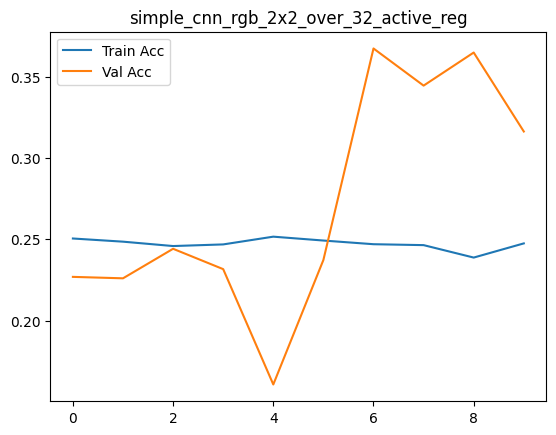

In [ ]:
plt.plot(gl_history[model_name].history['accuracy'])
plt.plot(gl_history[model_name].history['val_accuracy'])
plt.legend(['Train Acc','Val Acc'])
plt.title(model_name)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step  
Logits [0.20443678 0.16758783 0.14771016 0.4802652 ] should sum up to 1.0: False


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


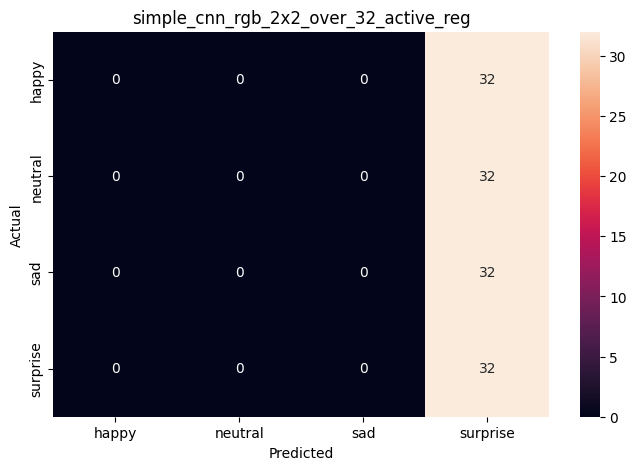

In [ ]:
gl_clrep[model_name], gl_cm[model_name] = compute_test_stats(model_name,
                                                             datasets_rgb,
                                                             y_test)

In [ ]:
df_models, df_model = create_dfs(model_name,
                                gl_clrep[model_name],
                                df_models)
df_model

happy  neutral   sad  \
Model                                 Metric                            
simple_cnn_rgb_2x2_over_32_active_reg precision    0.0      0.0   0.0   
                                      recall       0.0      0.0   0.0   
                                      f1-score     0.0      0.0   0.0   
                                      support     32.0     32.0  32.0   

                                                 surprise  accuracy  \
Model                                 Metric                          
simple_cnn_rgb_2x2_over_32_active_reg precision      0.25      0.25   
                                      recall         1.00      0.25   
                                      f1-score       0.40      0.25   
                                      support       32.00      0.25   

                                                 macro avg  weighted avg  
Model                                 Metric                              
simple_cnn_rgb_2x2_over_32_active_reg precision     0.0625        0.0625  
                                      recall        0.2500        0.2500  
                                      f1-score      0.1000        0.1000  
                                      support     128.0000      128.0000

In [ ]:
save_learning_data(model_name,
                   gl_history[model_name],
                   gl_clrep[model_name],
                   gl_cm[model_name]
                  )

backend.clear_session()

## **Smiple CNN RGB with Oversampling + Aug**

### **Compiling and Training the Model**

In [ ]:
model_name = 'simple_cnn_rgb_2x2_over_32_aug'

print(f'>>>> Model name: {model_name}')
model_config_local['model_name'] = model_name
model_config_local['input_shape'] = (48, 48, 3)
model_config_local['kernel_size'] = (2, 2)
model_config_local['batch_size'] = 32
model_config_local['activ_reg'] = False
model_config_local['aug'] = True
model_config_local['callback_list'] = ['checkpoint','early_stopping','reduce_learningrate']

with open(f"/content/drive/MyDrive/MIT_PE/model_configs/{model_name}.json", 'w') as fp:
    json.dump(model_config_local, fp)


checkpoint = ModelCheckpoint(f"/content/drive/MyDrive/MIT_PE/trained_models/{model_name}.keras",
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True,
                             mode='max')

callback_dict["checkpoint"] = checkpoint
callback_list = [callback_dict[item] for item in model_config_local['callback_list']]

gl_models[model_name] = simple_cnn_run_config(model_config_local)

gl_history[model_name] = gl_models[model_name].fit(train_set_rgb_over,
                                                    steps_per_epoch=model_config_local['steps_per_epoch'],
                                                    epochs=model_config_local['epochs'],
                                                    validation_data=validation_set_rgb,
                                                    validation_steps=model_config_local['validation_steps'],
                                                    callbacks=callback_list,
                                                    class_weight=model_config_local['cl_w']
                                                    )

>>>> Model name: simple_cnn_rgb_2x2_over_32_aug
Aug enabled
Epoch 1/100
498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.3076 - loss: 1.3756

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 1: val_accuracy improved from -inf to 0.42208, saving model to /content/drive/MyDrive/MIT_PE/trained_models/simple_cnn_rgb_2x2_over_32_aug.keras
500/500 ━━━━━━━━━━━━━━━━━━━━ 20s 18ms/step - accuracy: 0.3077 - loss: 1.3754 - val_accuracy: 0.4221 - val_loss: 1.2364 - learning_rate: 0.0010
Epoch 2/100
498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.3861 - loss: 1.2819
Epoch 2: val_accuracy did not improve from 0.42208
500/500 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.3861 - loss: 1.2818 - val_accuracy: 0.3729 - val_loss: 1.2737 - learning_rate: 0.0010
Epoch 3/100
498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4269 - loss: 1.2273
Epoch 3: val_accuracy improved from 0.42208 to 0.44750, saving model to /content/drive/MyDrive/MIT_PE/trained_models/simple_cnn_rgb_2x2_over_32_aug.keras
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.4269 - loss: 1.2273 - val_accuracy: 0.4475 - val_loss: 1.1871 - learning_rate: 0.0010
Epoch 4/100
498/500 ━━━━━━━━━━━━━━━━━━━━

Text(0.5, 1.0, 'simple_cnn_rgb_2x2_over_32_aug')

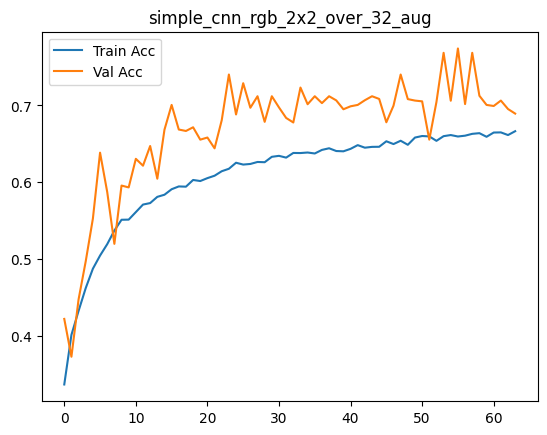

In [ ]:
plt.plot(gl_history[model_name].history['accuracy'])
plt.plot(gl_history[model_name].history['val_accuracy'])
plt.legend(['Train Acc','Val Acc'])
plt.title(model_name)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step  
Logits [1. 0. 0. 0.] should sum up to 1.0: True


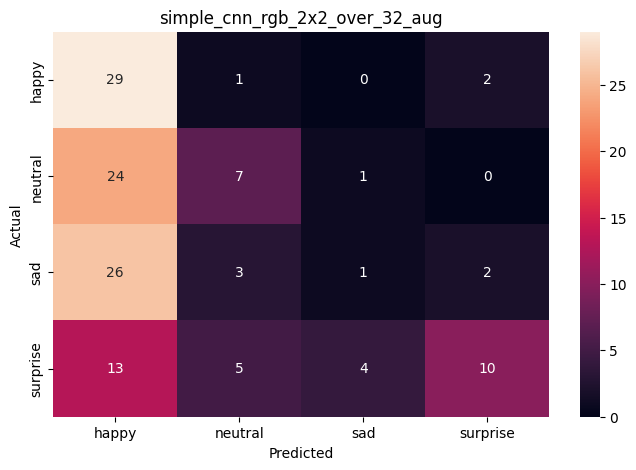

In [ ]:
gl_clrep[model_name], gl_cm[model_name] = compute_test_stats(model_name,
                                                             datasets_rgb,
                                                             y_test)

In [ ]:
df_models, df_model = create_dfs(model_name,
                                gl_clrep[model_name],
                                df_models)
df_model

happy    neutral        sad  \
Model                          Metric                                       
simple_cnn_rgb_2x2_over_32_aug precision   0.315217   0.437500   0.166667   
                               recall      0.906250   0.218750   0.031250   
                               f1-score    0.467742   0.291667   0.052632   
                               support    32.000000  32.000000  32.000000   

                                           surprise  accuracy   macro avg  \
Model                          Metric                                       
simple_cnn_rgb_2x2_over_32_aug precision   0.714286  0.367188    0.408417   
                               recall      0.312500  0.367188    0.367188   
                               f1-score    0.434783  0.367188    0.311706   
                               support    32.000000  0.367188  128.000000   

                                          weighted avg  
Model                          Metric                   
simple_cnn_rgb_2x2_over_32_aug precision      0.408417  
                               recall         0.367188  
                               f1-score       0.311706  
                               support      128.000000

In [ ]:
save_learning_data(model_name,
                   gl_history[model_name],
                   gl_clrep[model_name],
                   gl_cm[model_name]
                  )

backend.clear_session()

**Observations and Insights:__**

<b>Dataset</b>

In this case, we experimented with image augmentation.
We apply 3 trnaformation to generate augmented images: Random flip, ramdom rotation and random zoom.

<b>Training results</b>

Network performance is very poor:
weighted avg for recall is 0.367, precision is 0.408 and f1 0.311.

<b>Overall conclusion</b>

Augmentation did not effect in positive way, however, it is possible to do more experiments with augmentation tranformation and more advanced techniques like AugMix.

**Observations and Insights:__**

Overall conclusion for Simple CNN:
- model performs better with RBG rather than grayscale input
- out of 2x2 and 3x3 kernel size, 2x2 size results in better performance.
- the best batch size value for training data is 32
- regularization does reduced the performance
- data augmentation reduces the performance

### **Creating the second Convolutional Neural Network**

- Try out a slightly larger architecture

In [ ]:
#create simple CNN
def larger_cnn(input_shape=(48, 48, 1),
               kernel_size=(2,2),
               aug=False,
               kernel_reg = False,
               kernel_reg_rate = 0.01,
               activ_reg = False,
               activ_reg_rate = 0.01,
               ):
  inputs = keras.Input(shape=input_shape)

  x = inputs

  if aug:
    print('Aug enabled')
    x = data_augmentation(x)

  ker_reg = None
  if kernel_reg:
    ker_reg = keras.regularizers.L1(kernel_reg_rate)

  act_reg = None
  if activ_reg:
    act_reg = keras.regularizers.L2(activ_reg_rate)


  for filters in [256,128,64,32]:
    x = layers.Conv2D(filters=filters,
                      kernel_size=kernel_size,
                      padding='same',
                      kernel_regularizer = ker_reg,
                      activity_regularizer = act_reg,
                      activation='relu')(x)

    x = layers.MaxPooling2D(pool_size=(2,2))(x)
    x = layers.Dropout(0.2)(x)

  x = layers.Flatten()(x)

  x = layers.Dense(512,activation='relu')(x)
  x = layers.Dropout(0.4)(x)

  outputs = layers.Dense(4, activation="softmax")(x)
  model = keras.Model(inputs=inputs, outputs=outputs)
  return model

In [ ]:
def larger_cnn_run_config(mode_config_local):
  local_model = simple_cnn(
                          input_shape = mode_config_local['input_shape'],
                          kernel_size = mode_config_local['kernel_size'],
                          aug = mode_config_local['aug'],
                          kernel_reg = mode_config_local['kernel_reg'],
                          kernel_reg_rate = mode_config_local['kernel_reg_rate'],
                          activ_reg = mode_config_local['activ_reg'],
                          activ_reg_rate = mode_config_local['activ_reg_rate'],
                          )

  local_model.compile(loss="categorical_crossentropy",
                                optimizer=opt_dict[mode_config_local['opt']](learning_rate=mode_config_local['lr']),
                                metrics=["accuracy"])

  return local_model

### **Compiling and Training the Model**

In [ ]:
model_name = 'larger_cnn_rgb'

print(f'>>>> Model name: {model_name}')

model_config_local = {
                    'batch_size':batch_size,
                    'model_name':model_name,
                    'input_shape':(48, 48, 3),
                    'kernel_size':(2,2),
                    'lr':0.001,
                    'epochs':100,
                    'steps_per_epoch':500,
                    'validation_steps':150,
                    'kernel_reg':False,
                    'kernel_reg_rate':0.01,
                    'activ_reg':False,
                    'activ_reg_rate':0.01,
                    'cl_w': None,
                    'aug': False,
                    'bn': False,
                    'dropout':False,
                    'opt':'Adam',
                    'callback_list':['checkpoint']
                    }

with open(f"/content/drive/MyDrive/MIT_PE/model_configs/{model_name}.json", 'w') as fp:
    json.dump(model_config_local, fp)

>>>> Model name: larger_cnn_rgb


In [ ]:
checkpoint = ModelCheckpoint(f"/content/drive/MyDrive/MIT_PE/trained_models/{model_name}.keras",
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True,
                             mode='max')

callback_dict["checkpoint"] = checkpoint
callback_list = [callback_dict[item] for item in model_config_local['callback_list']]

gl_models[model_name] = larger_cnn_run_config(model_config_local)

gl_history[model_name] = gl_models[model_name].fit(train_set_rgb_over,
                                                    steps_per_epoch=model_config_local['steps_per_epoch'],
                                                    epochs=model_config_local['epochs'],
                                                    validation_data=validation_set_rgb,
                                                    validation_steps=model_config_local['validation_steps'],
                                                    callbacks=callback_list,
                                                    class_weight=model_config_local['cl_w']
                                                    )

Epoch 1/100
497/500 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.3127 - loss: 1.3598

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 1: val_accuracy improved from -inf to 0.44396, saving model to /content/drive/MyDrive/MIT_PE/trained_models/larger_cnn_rgb.keras
500/500 ━━━━━━━━━━━━━━━━━━━━ 15s 18ms/step - accuracy: 0.3131 - loss: 1.3594 - val_accuracy: 0.4440 - val_loss: 1.2111
Epoch 2/100
492/500 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5013 - loss: 1.1244
Epoch 2: val_accuracy improved from 0.44396 to 0.58757, saving model to /content/drive/MyDrive/MIT_PE/trained_models/larger_cnn_rgb.keras
500/500 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.5016 - loss: 1.1240 - val_accuracy: 0.5876 - val_loss: 0.9554
Epoch 3/100
489/500 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5673 - loss: 1.0240
Epoch 3: val_accuracy improved from 0.58757 to 0.61146, saving model to /content/drive/MyDrive/MIT_PE/trained_models/larger_cnn_rgb.keras
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.5674 - loss: 1.0236 - val_accuracy: 0.6115 - val_loss: 0.9249
Epoch 4/100
491/500 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accur

Text(0.5, 1.0, 'larger_cnn_rgb')

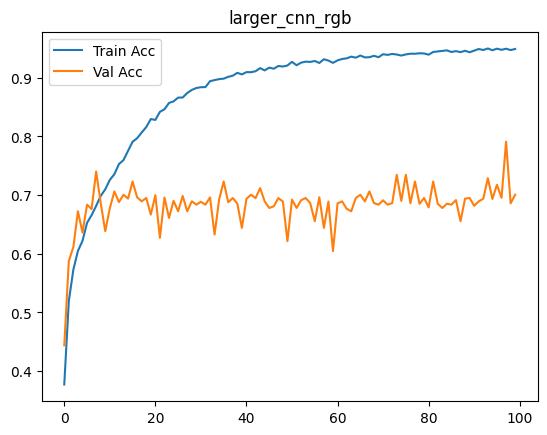

In [ ]:
plt.plot(gl_history[model_name].history['accuracy'])
plt.plot(gl_history[model_name].history['val_accuracy'])
plt.legend(['Train Acc','Val Acc'])
plt.title(model_name)

### **Evaluating the Model on the Test Set**

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  
Logits [1. 0. 0. 0.] should sum up to 1.0: True


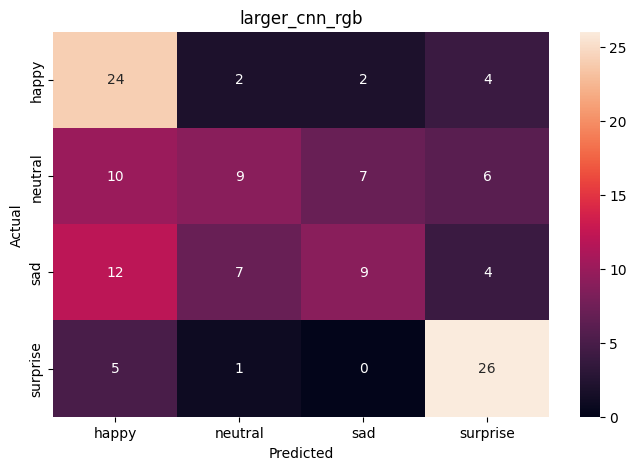

In [ ]:
gl_clrep[model_name], gl_cm[model_name] = compute_test_stats(model_name,
                                                             datasets_rgb,
                                                             y_test)

In [ ]:
df_models, df_model = create_dfs(model_name,
                                gl_clrep[model_name],
                                df_models)
df_model

happy    neutral       sad   surprise  accuracy  \
Model          Metric                                                           
larger_cnn_rgb precision   0.470588   0.473684   0.50000   0.650000   0.53125   
               recall      0.750000   0.281250   0.28125   0.812500   0.53125   
               f1-score    0.578313   0.352941   0.36000   0.722222   0.53125   
               support    32.000000  32.000000  32.00000  32.000000   0.53125   

                           macro avg  weighted avg  
Model          Metric                               
larger_cnn_rgb precision    0.523568      0.523568  
               recall       0.531250      0.531250  
               f1-score     0.503369      0.503369  
               support    128.000000    128.000000

In [ ]:
save_learning_data(model_name,
                   gl_history[model_name],
                   gl_clrep[model_name],
                   gl_cm[model_name]
                  )

backend.clear_session()

**Observations and Insights:__**

## **Think About It:**

* Did the models have a satisfactory performance? If not, then what are the possible reasons?
* Which Color mode showed better overall performance? What are the possible reasons? Do you think having 'rgb' color mode is needed because the images are already black and white?

**Observations and Insights:__**

<b>Model Structure</b>

Here we employ larger CNN with 4 consecutive convolution blocks containing 256, 128, 64 and 32 filters, respectively.

Classifier is the same as in Simple CNN.

<b>Training results</b>

To train the network we use best practicies from Simple CNN, i.e.,
RBG input, batch size 32, oversampled training data.

The learning curves for training and valudation accuracies exhibit strong overfitting of the model.

The overall performance on test data results in low value of precision, recall and f1-score, i.e., weighted average for these metrics are 0.523, 0.531 and 0.503, respectively.

However, these values are 2-3% lower than  weighted average for the same metrics (0.543, 0.539 and 0.519) in the case of Simple CNN.

The test accuracy is 0.531 for Larger CNN vs. 0.539 for Simple CNN.

<b>Simple CNN RGB vs. Larger RBG: conclusion</b>

Simple CNN outperforms Larger CNN.

although introducing more conv layers, introduces more feature inside the network, it appears that just adding features in not enough. To control the increased capacity of the model more 'techniques' like BatchNormalization or LayerNormalization maybe required.


## **Transfer Learning Architectures**

In this section, we will create several Transfer Learning architectures. For the pre-trained models, we will select three popular architectures namely, VGG16, ResNet v2, and Efficient Net. The difference between these architectures and the previous architectures is that these will require 3 input channels while the earlier ones worked on 'grayscale' images. Therefore, we need to create new DataLoaders.

### **Creating our Data Loaders for Transfer Learning Architectures**

In this section, we are creating data loaders that we will use as inputs to our Neural Network. We will have to go with color_mode = 'rgb' as this is the required format for the transfer learning architectures.

RGB dataloaders are created previously.

Also dataloaders for oversampling traing data have been created.

## **VGG16 Model**

### **Importing the VGG16 Architecture**

In [ ]:
from keras.applications import VGG16
conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(48,48,3))

In [ ]:
conv_base.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 48, 48, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 48, 48, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 48, 48, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 24, 24, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 24, 24, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 12, 12, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 12, 12, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 12, 12, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 6, 6, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 6, 6, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 6, 6, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 3, 3, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 3, 3, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 3, 3, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 3, 3, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 1, 1, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

### **Model Building**

- Import VGG16 upto the layer of your choice and add Fully Connected layers on top of it.

In [ ]:
def vgg16_tl(input_shape,
             trainable=False):

  conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=input_shape)

  transfer_layer = conv_base.get_layer('block5_pool')
  conv_base.trainable = trainable

  x = Flatten()(transfer_layer.output)
  x = Dense(256, activation = 'relu')(x)
  x = Dense(128, activation = 'relu')(x)
  x = Dropout(0.3)(x)
  x = Dense(64, activation = 'relu')(x)
  x = BatchNormalization()(x)
  pred = Dense(4, activation='softmax')(x)

  return Model(conv_base.input, pred)

### **Compiling and Training the VGG16 Model**

In [ ]:
model_name = get_model_name('vgg16_tl')
model_config_local = {
                    'batch_size':batch_size,
                    'model_name':model_name,
                    'input_shape':(48, 48, 3),
                    'kernel_size':(3,3),
                    'lr':0.001,
                    'epochs':100,
                    'steps_per_epoch':500,
                    'validation_steps':150,
                    'cl_w': None,
                    'aug': False,
                    'bn': False,
                    'dropout':False,
                    'opt':'Adam',
                    'callback_list':['checkpoint','reduce_learningrate','early_stopping'],
                    'trainable':False
                    }

In [ ]:
np.random.seed(42)
import random
random.seed(42)
tf.random.set_seed(42)

model_name = get_model_name('vgg16_tl')
print(f'>>>> Model name: {model_name}')

mode_config_local = {
                    'batch_size':batch_size,
                    'model_name':model_name,
                    'input_shape':(48, 48, 3),
                    'kernel_size':(3,3),
                    'lr':0.001,
                    'epochs':100,
                    'steps_per_epoch':500,
                    'validation_steps':150,
                    'cl_w': None,
                    'aug': False,
                    'bn': False,
                    'dropout':False,
                    'opt':'Adam',
                    'callback_list':['checkpoint','reduce_learningrate','early_stopping'],
                    'trainable': False
                    }

checkpoint = ModelCheckpoint(f"/content/drive/MyDrive/MIT_PE/trained_models/{model_name}.keras",
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True,
                             mode='max')

early_stopping = EarlyStopping(monitor = 'val_loss',
                              min_delta = 0,
                              patience = 10,
                              verbose = 1,
                              restore_best_weights = True
                              )

reduce_learningrate = ReduceLROnPlateau(monitor = 'val_loss',
                                        factor = 0.1,
                                        patience = 5,
                                        verbose = 1,
                                        min_delta = 0.0001)

callback_dict = {"checkpoint":checkpoint,
                 "early_stopping":early_stopping,
                 "reduce_learningrate":reduce_learningrate}


with open(f"/content/drive/MyDrive/MIT_PE/model_configs/{model_name}.json", 'w') as fp:
    json.dump(mode_config_local, fp)


callback_list = [callback_dict[item] for item in mode_config_local['callback_list']]

gl_models[model_name] = vgg16_tl(input_shape=mode_config_local['input_shape'],
                                 trainable=mode_config_local['trainable'])

gl_models[model_name].compile(loss="categorical_crossentropy",
                              optimizer=opt_dict[mode_config_local['opt']](learning_rate=mode_config_local['lr']),
                              metrics=["accuracy"])

gl_history[model_name] = gl_models[model_name] .fit(train_set_rgb_over,
                                                    steps_per_epoch=mode_config_local['steps_per_epoch'],
                                                    epochs=mode_config_local['epochs'],
                                                    validation_data=validation_set_rgb,
                                                    validation_steps=mode_config_local['validation_steps'],
                                                    callbacks=callback_list,
                                                    class_weight=mode_config_local['cl_w']
                                                    )

>>>> Model name: vgg16_tl
Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


495/500 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.4124 - loss: 1.3355

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 1: val_accuracy improved from -inf to 0.46729, saving model to /content/drive/MyDrive/MIT_PE/trained_models/vgg16_tl.keras
500/500 ━━━━━━━━━━━━━━━━━━━━ 31s 51ms/step - accuracy: 0.4128 - loss: 1.3345 - val_accuracy: 0.4673 - val_loss: 1.1915 - learning_rate: 0.0010
Epoch 2/100
498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5145 - loss: 1.1069
Epoch 2: val_accuracy did not improve from 0.46729
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.5145 - loss: 1.1069 - val_accuracy: 0.4350 - val_loss: 1.1990 - learning_rate: 0.0010
Epoch 3/100
494/500 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5388 - loss: 1.0805
Epoch 3: val_accuracy improved from 0.46729 to 0.50250, saving model to /content/drive/MyDrive/MIT_PE/trained_models/vgg16_tl.keras
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - accuracy: 0.5389 - loss: 1.0805 - val_accuracy: 0.5025 - val_loss: 1.1239 - learning_rate: 0.0010
Epoch 4/100
496/500 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5603 - loss: 1.

Text(0.5, 1.0, 'vgg16_tl')

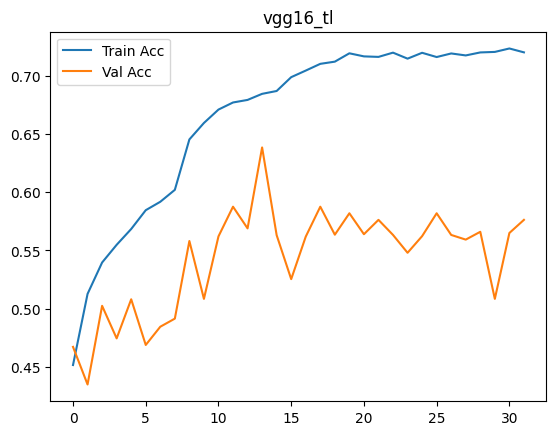

In [ ]:
plt.plot(gl_history[model_name].history['accuracy'])
plt.plot(gl_history[model_name].history['val_accuracy'])
plt.legend(['Train Acc','Val Acc'])
plt.title(model_name)

### **Evaluating the VGG16 model**

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step 
Logits [1.6988413e-13 1.0000000e+00 1.4242321e-17 0.0000000e+00] should sum up to 1.0: True


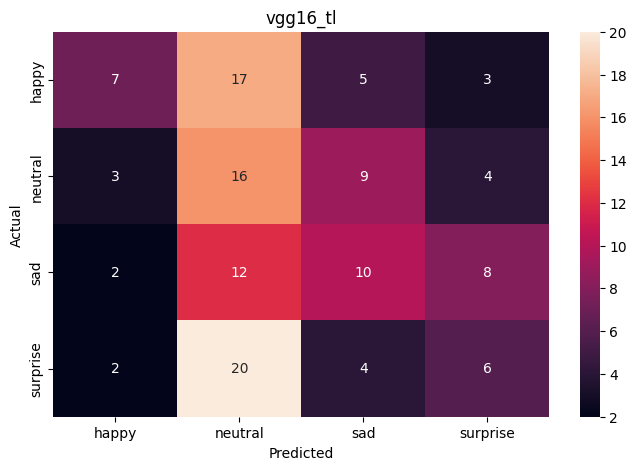

In [ ]:
gl_clrep[model_name], gl_cm[model_name] = compute_test_stats(model_name,
                                                             datasets_rgb,
                                                             y_test)

In [ ]:
df_models, df_model = create_dfs(model_name,
                                gl_clrep[model_name],
                                df_models)
df_model

happy    neutral        sad   surprise  accuracy  \
Model    Metric                                                            
vgg16_tl precision   0.500000   0.246154   0.357143   0.285714  0.304688   
         recall      0.218750   0.500000   0.312500   0.187500  0.304688   
         f1-score    0.304348   0.329897   0.333333   0.226415  0.304688   
         support    32.000000  32.000000  32.000000  32.000000  0.304688   

                     macro avg  weighted avg  
Model    Metric                               
vgg16_tl precision    0.347253      0.347253  
         recall       0.304688      0.304688  
         f1-score     0.298498      0.298498  
         support    128.000000    128.000000

In [ ]:
save_learning_data(model_name,
                   gl_history[model_name],
                   gl_clrep[model_name],
                   gl_cm[model_name]
                  )

backend.clear_session()

### **Compiling and Training the VGG16 Fully Trainable Model**

In [ ]:
model_name = get_model_name('vgg16_tl_trainable')
model_config_local = {
                    'batch_size':batch_size,
                    'model_name':model_name,
                    'input_shape':(48, 48, 3),
                    'kernel_size':(3,3),
                    'lr':0.001,
                    'epochs':100,
                    'steps_per_epoch':500,
                    'validation_steps':150,
                    'cl_w': None,
                    'aug': False,
                    'bn': False,
                    'dropout':False,
                    'opt':'Adam',
                    'callback_list':['checkpoint','reduce_learningrate','early_stopping'],
                    'trainable':True
                    }

In [ ]:
np.random.seed(42)
import random
random.seed(42)
tf.random.set_seed(42)

print(f'>>>> Model name: {model_name}')

checkpoint = ModelCheckpoint(f"/content/drive/MyDrive/MIT_PE/trained_models/{model_name}.keras",
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True,
                             mode='max')

early_stopping = EarlyStopping(monitor = 'val_loss',
                              min_delta = 0,
                              patience = 10,
                              verbose = 1,
                              restore_best_weights = True
                              )

reduce_learningrate = ReduceLROnPlateau(monitor = 'val_loss',
                                        factor = 0.1,
                                        patience = 5,
                                        verbose = 1,
                                        min_delta = 0.0001)

callback_dict = {"checkpoint":checkpoint,
                 "early_stopping":early_stopping,
                 "reduce_learningrate":reduce_learningrate}

with open(f"/content/drive/MyDrive/MIT_PE/model_configs/{model_name}.json", 'w') as fp:
    json.dump(mode_config_local, fp)


callback_list = [callback_dict[item] for item in model_config_local['callback_list']]

gl_models[model_name] = vgg16_tl(input_shape=model_config_local['input_shape'],
                                 trainable=model_config_local['trainable'])

gl_models[model_name].compile(loss="categorical_crossentropy",
                              optimizer=opt_dict[model_config_local['opt']](learning_rate=model_config_local['lr']),
                              metrics=["accuracy"])

gl_history[model_name] = gl_models[model_name] .fit(train_set_rgb_over,
                                                    steps_per_epoch=model_config_local['steps_per_epoch'],
                                                    epochs=mode_config_local['epochs'],
                                                    validation_data=validation_set_rgb,
                                                    validation_steps=model_config_local['validation_steps'],
                                                    callbacks=callback_list,
                                                    class_weight=model_config_local['cl_w']
                                                    )

>>>> Model name: vgg16_tl_trainable
Epoch 1/100
498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.3081 - loss: 1.4805
Epoch 1: val_accuracy improved from -inf to 0.41583, saving model to /content/drive/MyDrive/MIT_PE/trained_models/vgg16_tl_trainable.keras
500/500 ━━━━━━━━━━━━━━━━━━━━ 55s 80ms/step - accuracy: 0.3083 - loss: 1.4798 - val_accuracy: 0.4158 - val_loss: 1.2459 - learning_rate: 0.0010
Epoch 2/100
498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.4321 - loss: 1.1304
Epoch 2: val_accuracy did not improve from 0.41583
500/500 ━━━━━━━━━━━━━━━━━━━━ 65s 54ms/step - accuracy: 0.4321 - loss: 1.1303 - val_accuracy: 0.3164 - val_loss: 1.2466 - learning_rate: 0.0010
Epoch 3/100
497/500 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.4585 - loss: 1.0706
Epoch 3: val_accuracy improved from 0.41583 to 0.46750, saving model to /content/drive/MyDrive/MIT_PE/trained_models/vgg16_tl_trainable.keras
500/500 ━━━━━━━━━━━━━━━━━━━━ 40s 80ms/step - accuracy: 0.4585 - loss: 1.0706 - val

Text(0.5, 1.0, 'vgg16_tl_trainable')

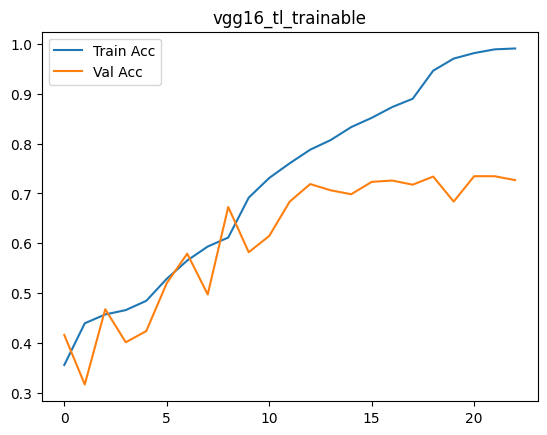

In [ ]:
plt.plot(gl_history[model_name].history['accuracy'])
plt.plot(gl_history[model_name].history['val_accuracy'])
plt.legend(['Train Acc','Val Acc'])
plt.title(model_name)

### **Evaluating the Model**

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step 
Logits [0. 0. 0. 1.] should sum up to 1.0: True


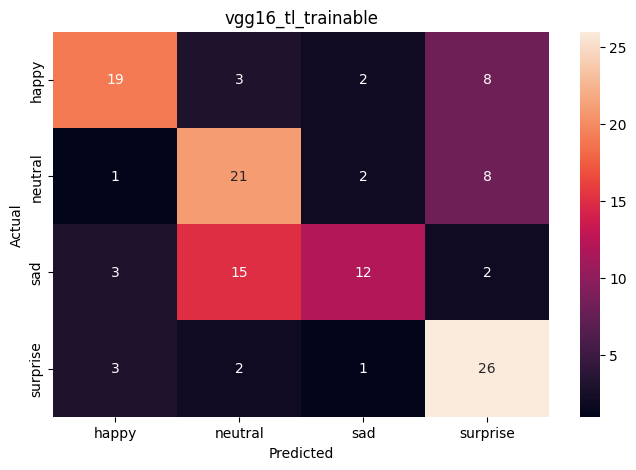

In [ ]:
gl_clrep[model_name], gl_cm[model_name] = compute_test_stats(model_name,
                                                             datasets_rgb,
                                                             y_test)

In [ ]:
df_models, df_model = create_dfs(model_name,
                                gl_clrep[model_name],
                                df_models)
df_model

happy    neutral        sad   surprise  \
Model              Metric                                                  
vgg16_tl_trainable precision   0.730769   0.512195   0.705882   0.590909   
                   recall      0.593750   0.656250   0.375000   0.812500   
                   f1-score    0.655172   0.575342   0.489796   0.684211   
                   support    32.000000  32.000000  32.000000  32.000000   

                              accuracy   macro avg  weighted avg  
Model              Metric                                         
vgg16_tl_trainable precision  0.609375    0.634939      0.634939  
                   recall     0.609375    0.609375      0.609375  
                   f1-score   0.609375    0.601130      0.601130  
                   support    0.609375  128.000000    128.000000

In [ ]:
save_learning_data(model_name,
                   gl_history[model_name],
                   gl_clrep[model_name],
                   gl_cm[model_name]
                  )

backend.clear_session()

**Think About It:**

- What do you infer from the general trend in the training performance?
- Is the training accuracy consistently improving?
- Is the validation accuracy also improving similarly?

**Observations and Insights:__**

<b>Model Structure</b><br>
In this section, we investigate ability of transfer learning to achieve the goal of emotion classification.

In general, transfer learnig is a technique, when weights are taken from pretrained models, while we connect new classifier. It is possible to train only classifier or entire network.

In this case, we select VGG16 model pretrained on ImageNet dataset as our base network.  ImageNet dataset contains millions of images (actual number veries and depends on a particular version of ImageNet) and 1000 classes. In our case, we only have 4 classes.

<b>Training Results</b><br>

We have performed training of Vgg16-based model in 2 modes:
- Non-trainable, i.e, only classifier weights are trained
- trainable, i.e., the whole set of weights is updated.

So far, Simple CNN network has exhibited the best performance with
precision, recall and f1score weighted avg values being 0.543, 0.539 and 0.519, respectively.

- Non-trainable mode

The results in non-trainable mode are as follows for precision, recall and f1-score 0.347, 0.305, 0.298, respectively.


- Trainable

The results in trainable mode are as follows
0.634, 0.609, 0.601 respectively.

VGG16 is very deep version of the Simple CNN and Larger CNN. This seems to be controversial result because, deeper Larger CNN (4 conv blocks) should outperform shallower Simple CNN (3 conv blocks), but training results showed opposite.

So why very deep VGG16 outperforms Simple CNN? The principle difference is that in Simple CNN number of filters is the same (64 in each block)*, while Larger CNN has conv blocks with decreasing number of filters (from 256 to 32).
In contrast, VGG16 has multiple block with the same number of filters, like Simple CNN, but as we go deeper in the network structure number of filters grows: 64 -> 128 -> 256 -> 512.

*Simple CNN considered as a one block inside VGG16.

<b>Overall conclusion</b><br>
VGG16-based model in non-trainable mode was not able to outperform Simple CNN network. The main reason is that only classifier was trained and ImageNet dataset is very different from our dataset at hands.

However, in trainable mode, our training data set of ~15k images was enough to fin-tine entire VGG16-based network to show moderate performance higher than Simple CNN network.

Finally, network still exhibits overfitting and jitter manner of validation accuracy learning curve. It is possible to try lower learning rates to prevent such a behavior.

**Note: You can even go back and build your own architecture on top of the VGG16 Transfer layer and see if you can improve the performance**

## **ResNet V2 Model**

In [ ]:
import tensorflow as tf
from tensorflow.keras import Model

Resnet_base = keras.applications.ResNet101(include_top = False,
                                           weights = "imagenet",
                                           input_shape=(48,48,3))
Resnet_base.summary()

171446536/171446536 ━━━━━━━━━━━━━━━━━━━━ 9s 0us/step


Model: "resnet101"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 48, 48, 3)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 54, 54, 3)      │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 24, 24, 64)     │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 24, 24, 64)     │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 24, 24, 64)     │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 26, 26, 64)     │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 12, 12, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 12, 12, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 12, 12, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 12, 12, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 12, 12, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 12, 12, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 12, 12, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 12, 12, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 12, 12, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 42,658,176 (162.73 MB)

 Trainable params: 42,552,832 (162.33 MB)

 Non-trainable params: 105,344 (411.50 KB)

### **Model Building**

- Import Resnet v2 upto the layer of your choice and add Fully Connected layers on top of it.

In [ ]:
def resnetV2_tl(input_shape,
               trainable=False):

  Resnet_base = keras.applications.ResNet101(include_top = False,
                                              weights = "imagenet",
                                              input_shape=input_shape)
  transfer_layer_Resnet = Resnet_base.get_layer('conv5_block3_add')
  Resnet_base.trainable=False

  # Flattenning the output from the 3rd block of the VGG16 model
  x = Flatten()(transfer_layer_Resnet.output)

  # Add a Dense layer with 256 neurons
  x = Dense(256, activation = 'relu')(x)

  # Add a Dense Layer with 128 neurons
  x = Dense(128, activation = 'relu')(x)

  # Add a DropOut layer with Drop out ratio of 0.3
  x = Dropout(0.3)(x)

  # Add a Dense Layer with 64 neurons
  x = Dense(64, activation = 'relu')(x)

  # Add a Batch Normalization layer
  x = BatchNormalization()(x)

  # Add the final dense layer with 4 neurons and use a 'softmax' activation
  pred = Dense(4, activation = 'softmax')(x)

  return Model(Resnet_base.input, pred) # Initializing the model

### **Compiling and Training the Model**

In [ ]:
model_name = get_model_name('resnetV2_tl')
mode_config_local = {
                    'batch_size':batch_size,
                    'model_name':model_name,
                    'input_shape':(48, 48, 3),
                    'kernel_size':(3,3),
                    'lr':0.001,
                    'epochs':100,
                    'steps_per_epoch':500,
                    'validation_steps':150,
                    'cl_w': None,
                    'aug': False,
                    'bn': False,
                    'dropout':False,
                    'opt':'Adam',
                    'callback_list':['checkpoint','reduce_learningrate','early_stopping'],
                    'trainable':False
                    }

In [ ]:
np.random.seed(42)
import random
random.seed(42)
tf.random.set_seed(42)

print(f'>>>> Model name: {model_name}')

checkpoint = ModelCheckpoint(f"/content/drive/MyDrive/MIT_PE/trained_models/{model_name}.keras",
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True,
                             mode='max')

early_stopping = EarlyStopping(monitor = 'val_loss',
                              min_delta = 0,
                              patience = 10,
                              verbose = 1,
                              restore_best_weights = True
                              )

reduce_learningrate = ReduceLROnPlateau(monitor = 'val_loss',
                                        factor = 0.1,
                                        patience = 5,
                                        verbose = 1,
                                        min_delta = 0.0001)

callback_dict = {"checkpoint":checkpoint,
                 "early_stopping":early_stopping,
                 "reduce_learningrate":reduce_learningrate}




with open(f"/content/drive/MyDrive/MIT_PE/model_configs/{model_name}.json", 'w') as fp:
    json.dump(mode_config_local, fp)


callback_list = [callback_dict[item] for item in mode_config_local['callback_list']]

gl_models[model_name] = resnetV2_tl(input_shape=mode_config_local['input_shape'],
                                    trainable=mode_config_local['trainable'])

gl_models[model_name].compile(loss="categorical_crossentropy",
                              optimizer=opt_dict[mode_config_local['opt']](learning_rate=mode_config_local['lr']),
                              metrics=["accuracy"])

gl_history[model_name] = gl_models[model_name] .fit(train_set_rgb_over,
                                                    steps_per_epoch=mode_config_local['steps_per_epoch'],
                                                    epochs=mode_config_local['epochs'],
                                                    validation_data=validation_set_rgb,
                                                    validation_steps=mode_config_local['validation_steps'],
                                                    callbacks=callback_list,
                                                    class_weight=mode_config_local['cl_w']
                                                    )

>>>> Model name: resnetV2_tl
Epoch 1/100
497/500 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.2521 - loss: 1.5550

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 1: val_accuracy improved from -inf to 0.36792, saving model to /content/drive/MyDrive/MIT_PE/trained_models/resnetV2_tl.keras
500/500 ━━━━━━━━━━━━━━━━━━━━ 89s 124ms/step - accuracy: 0.2520 - loss: 1.5546 - val_accuracy: 0.3679 - val_loss: 1.3680 - learning_rate: 0.0010
Epoch 2/100
496/500 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.2568 - loss: 1.4108
Epoch 2: val_accuracy did not improve from 0.36792
500/500 ━━━━━━━━━━━━━━━━━━━━ 18s 36ms/step - accuracy: 0.2568 - loss: 1.4108 - val_accuracy: 0.1638 - val_loss: 1.4181 - learning_rate: 0.0010
Epoch 3/100
497/500 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.2510 - loss: 1.4023
Epoch 3: val_accuracy did not improve from 0.36792
500/500 ━━━━━━━━━━━━━━━━━━━━ 18s 30ms/step - accuracy: 0.2510 - loss: 1.4023 - val_accuracy: 0.3648 - val_loss: 1.3840 - learning_rate: 0.0010
Epoch 4/100
496/500 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.2502 - loss: 1.3985
Epoch 4: val_accuracy did not improve from 0.36792
500/500 ━━━━━━━━━━━━

Text(0.5, 1.0, 'resnetV2_tl')

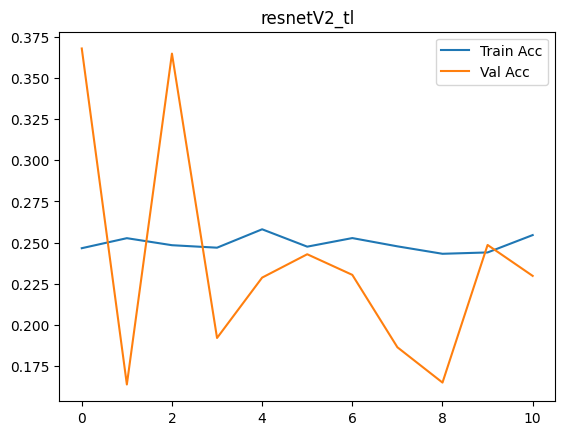

In [ ]:
plt.plot(gl_history[model_name].history['accuracy'])
plt.plot(gl_history[model_name].history['val_accuracy'])
plt.legend(['Train Acc','Val Acc'])
plt.title(model_name)

### **Evaluating the ResNet Model**

4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step
Logits [0.19338153 0.23416406 0.24971479 0.3227396 ] should sum up to 1.0: True


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


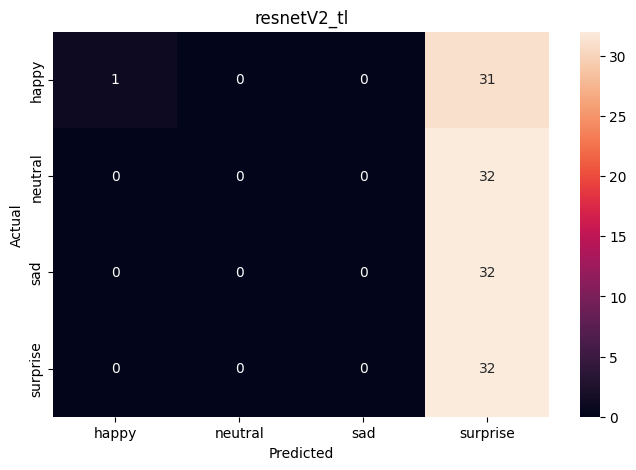

In [ ]:
gl_clrep[model_name], gl_cm[model_name] = compute_test_stats(model_name,
                                                             datasets_rgb,
                                                             y_test)

In [ ]:
df_models, df_model = create_dfs(model_name,
                                gl_clrep[model_name],
                                df_models)
df_model

happy  neutral   sad   surprise  accuracy  \
Model       Metric                                                     
resnetV2_tl precision   1.000000      0.0   0.0   0.251969  0.257812   
            recall      0.031250      0.0   0.0   1.000000  0.257812   
            f1-score    0.060606      0.0   0.0   0.402516  0.257812   
            support    32.000000     32.0  32.0  32.000000  0.257812   

                        macro avg  weighted avg  
Model       Metric                               
resnetV2_tl precision    0.312992      0.312992  
            recall       0.257812      0.257812  
            f1-score     0.115780      0.115780  
            support    128.000000    128.000000

In [ ]:
save_learning_data(model_name,
                   gl_history[model_name],
                   gl_clrep[model_name],
                   gl_cm[model_name]
                  )

backend.clear_session()

In [ ]:
model_name = get_model_name('resnetV2_tl_trainable')
mode_config_local = {
                    'batch_size':batch_size,
                    'model_name':model_name,
                    'input_shape':(48, 48, 3),
                    'kernel_size':(3,3),
                    'lr':0.001,
                    'epochs':100,
                    'steps_per_epoch':500,
                    'validation_steps':150,
                    'cl_w': None,
                    'aug': False,
                    'bn': False,
                    'dropout':False,
                    'opt':'Adamax',
                    'callback_list':['checkpoint','reduce_learningrate','early_stopping'],
                    'trainable':True
                    }

In [ ]:
np.random.seed(42)
import random
random.seed(42)
tf.random.set_seed(42)

print(f'>>>> Model name: {model_name}')

checkpoint = ModelCheckpoint(f"/content/drive/MyDrive/MIT_PE/trained_models/{model_name}.keras",
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True,
                             mode='max')

early_stopping = EarlyStopping(monitor = 'val_loss',
                              min_delta = 0,
                              patience = 10,
                              verbose = 1,
                              restore_best_weights = True
                              )

reduce_learningrate = ReduceLROnPlateau(monitor = 'val_loss',
                                        factor = 0.1,
                                        patience = 5,
                                        verbose = 1,
                                        min_delta = 0.0001)

callback_dict = {"checkpoint":checkpoint,
                 "early_stopping":early_stopping,
                 "reduce_learningrate":reduce_learningrate}




with open(f"/content/drive/MyDrive/MIT_PE/model_configs/{model_name}.json", 'w') as fp:
    json.dump(mode_config_local, fp)


callback_list = [callback_dict[item] for item in mode_config_local['callback_list']]

gl_models[model_name] = resnetV2_tl(input_shape=mode_config_local['input_shape'],
                                    trainable=mode_config_local['trainable'])

gl_models[model_name].compile(loss="categorical_crossentropy",
                              optimizer=opt_dict[mode_config_local['opt']](learning_rate=mode_config_local['lr']),
                              metrics=["accuracy"])

gl_history[model_name] = gl_models[model_name] .fit(train_set_rgb_over,
                                                    steps_per_epoch=mode_config_local['steps_per_epoch'],
                                                    epochs=mode_config_local['epochs'],
                                                    validation_data=validation_set_rgb,
                                                    validation_steps=mode_config_local['validation_steps'],
                                                    callbacks=callback_list,
                                                    class_weight=mode_config_local['cl_w']
                                                    )

>>>> Model name: resnetV2_tl_trainable
Epoch 1/100
498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.2531 - loss: 1.6303

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 1: val_accuracy improved from -inf to 0.16104, saving model to /content/drive/MyDrive/MIT_PE/trained_models/resnetV2_tl_trainable.keras
500/500 ━━━━━━━━━━━━━━━━━━━━ 85s 129ms/step - accuracy: 0.2531 - loss: 1.6299 - val_accuracy: 0.1610 - val_loss: 1.4146 - learning_rate: 0.0010
Epoch 2/100
497/500 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.2499 - loss: 1.4332
Epoch 2: val_accuracy improved from 0.16104 to 0.18079, saving model to /content/drive/MyDrive/MIT_PE/trained_models/resnetV2_tl_trainable.keras
500/500 ━━━━━━━━━━━━━━━━━━━━ 54s 84ms/step - accuracy: 0.2499 - loss: 1.4332 - val_accuracy: 0.1808 - val_loss: 1.4781 - learning_rate: 0.0010
Epoch 3/100
497/500 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.2489 - loss: 1.4121
Epoch 3: val_accuracy improved from 0.18079 to 0.22958, saving model to /content/drive/MyDrive/MIT_PE/trained_models/resnetV2_tl_trainable.keras
500/500 ━━━━━━━━━━━━━━━━━━━━ 50s 100ms/step - accuracy: 0.2489 - loss: 1.4121 - val_accuracy: 0.2296 - v

Text(0.5, 1.0, 'resnetV2_tl_trainable')

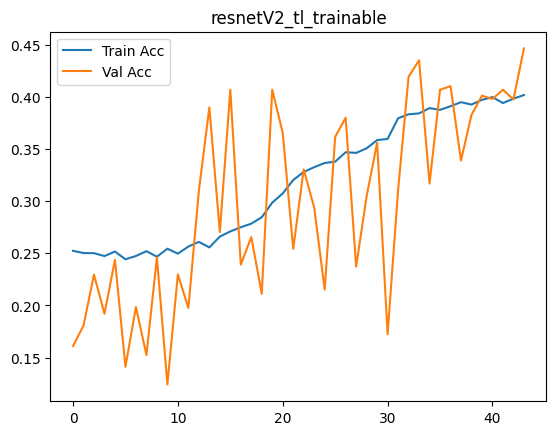

In [ ]:
plt.plot(gl_history[model_name].history['accuracy'])
plt.plot(gl_history[model_name].history['val_accuracy'])
plt.legend(['Train Acc','Val Acc'])
plt.title(model_name)

### **Evaluating the ResNet Model**

4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step
Logits [1.9828646e-04 3.7451056e-04 3.9933488e-04 9.9902785e-01] should sum up to 1.0: True


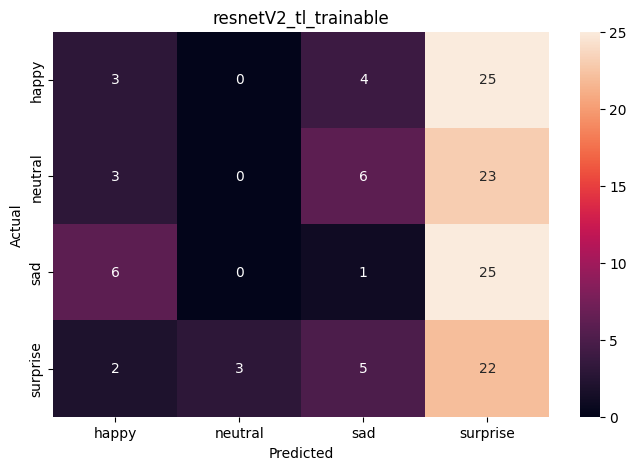

In [ ]:
gl_clrep[model_name], gl_cm[model_name] = compute_test_stats(model_name,
                                                             datasets_rgb,
                                                             y_test)

In [ ]:
df_models, df_model = create_dfs(model_name,
                                gl_clrep[model_name],
                                df_models)
df_model

happy  neutral        sad   surprise  \
Model                 Metric                                                
resnetV2_tl_trainable precision   0.214286      0.0   0.062500   0.231579   
                      recall      0.093750      0.0   0.031250   0.687500   
                      f1-score    0.130435      0.0   0.041667   0.346457   
                      support    32.000000     32.0  32.000000  32.000000   

                                 accuracy   macro avg  weighted avg  
Model                 Metric                                         
resnetV2_tl_trainable precision  0.203125    0.127091      0.127091  
                      recall     0.203125    0.203125      0.203125  
                      f1-score   0.203125    0.129640      0.129640  
                      support    0.203125  128.000000    128.000000

In [ ]:
save_learning_data(model_name,
                   gl_history[model_name],
                   gl_clrep[model_name],
                   gl_cm[model_name]
                  )

backend.clear_session()

**Observations and Insights:__**

<b>Model Structure</b><br>
In this section, we investigate ability of transfer learning to achieve the goal of emotion classification.

In general, transfer learnig is a technique, when weights are taken from pretrained models, while we connect new classifier. It is possible to train only classifier or entire network.

In this case, we select ResNetV2 model pretrained on ImageNet dataset as our base network.  ImageNet dataset contains millions of images (actual number veries and depends on a particular version of ImageNet) and 1000 classes. In our case, we only have 4 classes.

<b>Training Results</b><br>

We have performed training of ResNetV2-based model in 2 modes:
- Non-trainable, i.e, only classifier weights are trained
- trainable, i.e., the whole set of weights is updated.

The results in non-trainable mode are as follows for precision, recall and f1-score 0.313, 0.257, 0.116, respectively.

The results in trainable mode are as follows for precision, recall and f1-score
0.127, 0.203, 0.130 respectively.

In both cases, all the metrics are lower than the ones for Simple CNN model.

Interesting observation is metrics for non-trainable case are higher for trainable mode. This can be a result of that ResNet has more complex structure in comparison with VGG16, i.e., ResNetV2 employes skip connection and this require more samples and longer training. Thus, once we start to train the entire network it is not enough new information to fit network accurately.

<b>Overall conclusion</b><br>
ResNetV2-based model was not able to outperform either Simple CNN network or VGG16 in either non-trainbled vs. trainable modes.

Finally, network still exhibits overfitting and jitter manner of validation accuracy learning curve. It is possible to try lower learning rates to prevent such a behavior.

## **EfficientNet Model**

In [ ]:
import tensorflow as tf
from tensorflow.keras import Model

EfficientNet = keras.applications.EfficientNetV2B2(include_top=False,
                                                   weights="imagenet",
                                                   input_shape= (48, 48, 3))

EfficientNet.summary()

35839040/35839040 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "efficientnetv2-b2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 48, 48, 3)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 48, 48, 3)      │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, 48, 48, 3)      │              0 │ rescaling[0][0]        │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 24, 24, 32)     │            864 │ normalization[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 24, 24, 32)     │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 24, 24, 32)     │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_project_conv      │ (None, 24, 24, 16)     │          4,608 │ stem_activation[0][0]  │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_project_bn        │ (None, 24, 24, 16)     │             64 │ block1a_project_conv[… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_project_activati… │ (None, 24, 24, 16)     │              0 │ block1a_project_bn[0]… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1b_project_conv      │ (None, 24, 24, 16)     │          2,304 │ block1a_project_activ… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1b_project_bn        │ (None, 24, 24, 16)     │             64 │ block1b_project_conv[… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1b_project_activati… │ (None, 24, 24, 16)     │              0 │ block1b_project_bn[0]… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1b_drop (Dropout)    │ (None, 24, 24, 16)     │              0 │ block1b_project_activ… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1b_add (Add)         │ (None, 24, 24, 16)     │              0 │ block1b_drop[0][0],    │
│                           │                        │                │ block1a_project_activ… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2a_expand_conv  

 Total params: 8,769,374 (33.45 MB)

 Trainable params: 8,687,086 (33.14 MB)

 Non-trainable params: 82,288 (321.44 KB)

### **Model Building**

- Import EfficientNet upto the layer of your choice and add Fully Connected layers on top of it.

In [ ]:
def effnet_tl(input_shape,
              trainable=False):

  EfficientNet = keras.applications.EfficientNetV2B2(include_top=False,
                                                     weights="imagenet",
                                                     input_shape=input_shape)

  transfer_layer_EfficientNet = EfficientNet.get_layer('block6e_expand_activation')
  EfficientNet.trainable = False

  # Add your Flatten layer.
  x = Flatten()(transfer_layer_EfficientNet.output)

  # Add your Dense layers and/or BatchNormalization and Dropout layers
  x = Dense(128, activation='relu')(x)
  x = BatchNormalization()(x)

  # Add your final Dense layer with 4 neurons and softmax activation function.
  pred = Dense(4, activation='softmax')(x)

  return Model(EfficientNet.input, pred)

### **Compiling and Training the Model**

In [ ]:
model_name = get_model_name('efficientnet_tl')
model_config_local = {
                    'batch_size':batch_size,
                    'model_name':model_name,
                    'input_shape':(48, 48, 3),
                    'kernel_size':(3,3),
                    'lr':0.001,
                    'epochs':100,
                    'steps_per_epoch':500,
                    'validation_steps':150,
                    'cl_w': None,
                    'aug': False,
                    'bn': False,
                    'dropout':False,
                    'opt':'Adamax',
                    'callback_list':['checkpoint','reduce_learningrate','early_stopping'],
                    'trainable':False
                    }

In [ ]:
np.random.seed(42)
import random
random.seed(42)
tf.random.set_seed(42)

print(f'>>>> Model name: {model_name}')

checkpoint = ModelCheckpoint(f"/content/drive/MyDrive/MIT_PE/trained_models/{model_name}.keras",
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True,
                             mode='max')

early_stopping = EarlyStopping(monitor = 'val_loss',
                              min_delta = 0,
                              patience = 10,
                              verbose = 1,
                              restore_best_weights = True
                              )

reduce_learningrate = ReduceLROnPlateau(monitor = 'val_loss',
                                        factor = 0.1,
                                        patience = 5,
                                        verbose = 1,
                                        min_delta = 0.0001)

callback_dict = {"checkpoint":checkpoint,
                 "early_stopping":early_stopping,
                 "reduce_learningrate":reduce_learningrate}




with open(f"/content/drive/MyDrive/MIT_PE/model_configs/{model_name}.json", 'w') as fp:
    json.dump(mode_config_local, fp)


callback_list = [callback_dict[item] for item in mode_config_local['callback_list']]

gl_models[model_name] = effnet_tl(input_shape=mode_config_local['input_shape'],
                                    trainable=mode_config_local['trainable'])

gl_models[model_name].compile(loss="categorical_crossentropy",
                              optimizer=opt_dict[mode_config_local['opt']](learning_rate=mode_config_local['lr']),
                              metrics=["accuracy"])

gl_history[model_name] = gl_models[model_name] .fit(train_set_rgb_over,
                                                    steps_per_epoch=mode_config_local['steps_per_epoch'],
                                                    epochs=mode_config_local['epochs'],
                                                    validation_data=validation_set_rgb,
                                                    validation_steps=mode_config_local['validation_steps'],
                                                    callbacks=callback_list,
                                                    class_weight=mode_config_local['cl_w']
                                                    )

>>>> Model name: efficientnet_tl
Epoch 1/100
498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.2508 - loss: 1.4452

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 1: val_accuracy improved from -inf to 0.24646, saving model to /content/drive/MyDrive/MIT_PE/trained_models/efficientnet_tl.keras
500/500 ━━━━━━━━━━━━━━━━━━━━ 54s 57ms/step - accuracy: 0.2508 - loss: 1.4451 - val_accuracy: 0.2465 - val_loss: 1.4404 - learning_rate: 0.0010
Epoch 2/100
494/500 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.2565 - loss: 1.3936
Epoch 2: val_accuracy did not improve from 0.24646
500/500 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - accuracy: 0.2565 - loss: 1.3936 - val_accuracy: 0.2373 - val_loss: 2.4571 - learning_rate: 0.0010
Epoch 3/100
493/500 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.2740 - loss: 1.3883
Epoch 3: val_accuracy improved from 0.24646 to 0.36521, saving model to /content/drive/MyDrive/MIT_PE/trained_models/efficientnet_tl.keras
500/500 ━━━━━━━━━━━━━━━━━━━━ 17s 17ms/step - accuracy: 0.2740 - loss: 1.3883 - val_accuracy: 0.3652 - val_loss: 1.4016 - learning_rate: 0.0010
Epoch 4/100
493/500 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.2

Text(0.5, 1.0, 'efficientnet_tl')

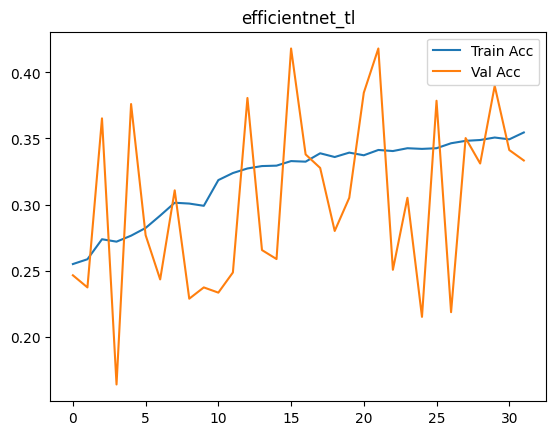

In [ ]:
plt.plot(gl_history[model_name].history['accuracy'])
plt.plot(gl_history[model_name].history['val_accuracy'])
plt.legend(['Train Acc','Val Acc'])
plt.title(model_name)

### **Evaluating the EfficientnetNet Model**

4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step
Logits [9.9469884e-04 2.7398337e-02 3.8885619e-04 9.7121811e-01] should sum up to 1.0: True


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


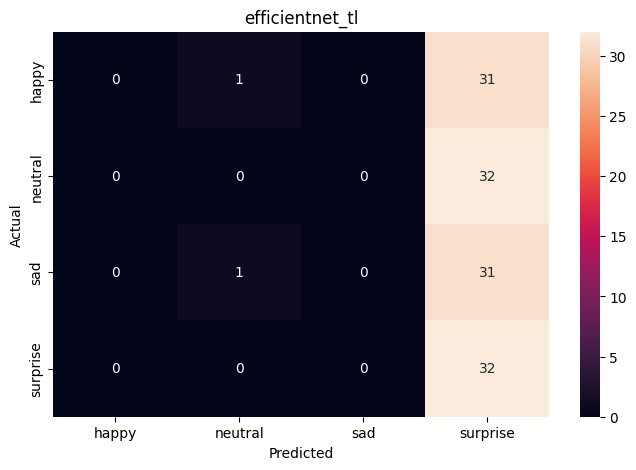

In [ ]:
gl_clrep[model_name], gl_cm[model_name] = compute_test_stats(model_name,
                                                             datasets_rgb,
                                                             y_test)

In [ ]:
df_models, df_model = create_dfs(model_name,
                                gl_clrep[model_name],
                                df_models)
df_model

happy  neutral   sad   surprise  accuracy  \
Model           Metric                                                 
efficientnet_tl precision    0.0      0.0   0.0   0.253968      0.25   
                recall       0.0      0.0   0.0   1.000000      0.25   
                f1-score     0.0      0.0   0.0   0.405063      0.25   
                support     32.0     32.0  32.0  32.000000      0.25   

                            macro avg  weighted avg  
Model           Metric                               
efficientnet_tl precision    0.063492      0.063492  
                recall       0.250000      0.250000  
                f1-score     0.101266      0.101266  
                support    128.000000    128.000000

In [ ]:
save_learning_data(model_name,
                   gl_history[model_name],
                   gl_clrep[model_name],
                   gl_cm[model_name]
                  )

backend.clear_session()

**Observations and Insights:__**

<b>Model Structure</b><br>
In this section, we investigate ability of transfer learning to achieve the goal of emotion classification.

In general, transfer learnig is a technique, when weights are taken from pretrained models, while we connect new classifier. It is possible to train only classifier or entire network.

In this case, we select EfficientNet model pretrained on ImageNet dataset as our base network.  ImageNet dataset contains millions of images (actual number veries and depends on a particular version of ImageNet) and 1000 classes. In our case, we only have 4 classes.

<b>Training Results</b><br>

We have performed training of ResNetV2-based model only in non-trainable mode.

The results in non-trainable mode are as follows for precision, recall and f1-score 0.063, 0.250, 0.101, respectively.

<b>Overall conclusion</b><br>
ResNetV2-based model was not able to outperform Simple CNN network in either non-trainbled vs. trainable modes.

**Think About It:**

* What is your overall performance of these Transfer Learning Architectures? Can we draw a comparison of these models' performances. Are we satisfied with the accuracies that we have received?
* Do you think our issue lies with 'rgb' color_mode?

**Observations and Insights:__**

In general,all pretrained networks are trained on a very huge variety of color images. Therefore, regularities encoded in the pretrained weights are very different from regularities in original grayscale images.

Takking into account complexity of the networks (depth, size, skip connections, ect.) it is not possible to fit models based of these networks nice to the original data.

Having dataset of color images for emotion recognition should definitely help, as it will provide a unique information for each of RBG channels and thus increase diversity of patterns.

Now that we have tried multiple pre-trained models, let's build a complex CNN architecture and see if we can get better performance.

## **Building a Complex Neural Network Architecture**

In this section, we will build a more complex Convolutional Neural Network Model that has close to as many parameters as we had in our Transfer Learning Models. However, we will have only 1 input channel for our input images.

**Observations and Insights:__**

We have observed that transfer lerning in the case of sofisticated model like ResNet and Efficient Net was not helpful.

However, in particular ResNet architecture has promising feature of skip connection, which is trying to preserve affinity of the input.

Therefore, it is promising to try to train such architecture from scratch.

As a setup for the final model, we select
- Increase number of filters as we go deeping into the layers
- Use RGB input
- Use Batch size 32
- No regularization
- No augmentation
- Use skip connection

In contrast to finding that CNNs with 2x2 kernel size perform better, we will use 3x3 kernel size as it is commonly used size in well trained architectures like ResNet and VGG15.

## **Creating our Data Loaders**

In this section, we are creating data loaders which we will use as inputs to the more Complicated Convolutional Neural Network. We will go ahead with color_mode = 'grayscale'.

In [46]:
X_train_bw = datasets_data['Xtrain']
X_train_bw = X_train_bw.reshape(X_train_bw.shape[0],-1)
Y_train = np.array(datasets_data['Ytrain'])

# fit and apply the transform
sm = SMOTE(random_state=42)
X_train_bw_over, Y_train_bw_over = sm.fit_resample(X_train_bw, Y_train)

datasets_data['Xtrain_over'] = X_train_bw_over.reshape(X_train_bw_over.shape[0],48,48,1)
datasets_data['Ytrain_over'] = Y_train_bw_over

batch_size  = 32

datagen_train_bw_over = ImageDataGenerator(rescale=1./255)
train_set_bw_over = datagen_train_bw_over.flow(x=datasets_data['Xtrain_over'],
                                                y=datasets_data['Ytrain_over'],
                                                batch_size=batch_size,
                                                shuffle=True)

### **Model Building**

- Try building a layer with 5 Convolutional Blocks and see if performance increases.

Create ResNet-like models with 3 and 5 convolutional blocks.

In [115]:
def res_cnn(input_shape=(48, 48, 1),
            kernel_size=(3,3),
            activation='relu',
            aug=False):
  inputs = keras.Input(shape=input_shape)
  #x = layers.Rescaling(1./255)(inputs)
  x = inputs

  if aug:
    print('Aug Enabled')
    x = data_augmentation(x)

  def residual_block(x, filters, kernel_size=kernel_size, pooling=False):
      residual = x
      x = layers.Conv2D(filters,
                        kernel_size,
                        activation=activation,
                        padding="same")(x)

      x = layers.Conv2D(filters,
                        kernel_size,
                        activation=activation,
                        padding="same")(x)
      if pooling:
          x = layers.MaxPooling2D(2, padding="same")(x)
          residual = layers.Conv2D(filters, 1, strides=2)(residual)
      elif filters != residual.shape[-1]:
          residual = layers.Conv2D(filters, 1)(residual)
      x = layers.add([x, residual])
      return x

  x = residual_block(inputs, filters=32, pooling=True)
  x = residual_block(x, filters=64, pooling=True)
  x = residual_block(x, filters=128, pooling=False)

  x = layers.GlobalAveragePooling2D()(x)
  outputs = layers.Dense(4, activation="softmax")(x)
  model = keras.Model(inputs=inputs, outputs=outputs)
  return model

In [56]:
def res_cnn_5(input_shape=(48, 48, 1),
            kernel_size=(3,3),
            activation='relu',
            aug=False):
  inputs = keras.Input(shape=input_shape)
  #x = layers.Rescaling(1./255)(inputs)
  x = inputs

  if aug:
    print('Aug Enabled')
    x = data_augmentation(x)

  def residual_block(x, filters, kernel_size=kernel_size, pooling=False):
      residual = x
      x = layers.Conv2D(filters,
                        kernel_size,
                        activation=activation,
                        padding="same")(x)

      x = layers.Conv2D(filters,
                        kernel_size,
                        activation=activation,
                        padding="same")(x)
      if pooling:
          x = layers.MaxPooling2D(2, padding="same")(x)
          residual = layers.Conv2D(filters, 1, strides=2)(residual)
      elif filters != residual.shape[-1]:
          residual = layers.Conv2D(filters, 1)(residual)
      x = layers.add([x, residual])
      return x

  x = residual_block(inputs, filters=32, pooling=True)
  x = residual_block(x, filters=64, pooling=True)
  x = residual_block(x, filters=128, pooling=True)
  x = residual_block(x, filters=256, pooling=True)
  x = residual_block(x, filters=512, pooling=False)

  x = layers.GlobalAveragePooling2D()(x)
  outputs = layers.Dense(4, activation="softmax")(x)
  model = keras.Model(inputs=inputs, outputs=outputs)
  return model

## **ResNet-like GaryScale model with 3 Conv Blocks**

### **Compiling and Training the Model**

In [ ]:
np.random.seed(42)
import random
random.seed(42)
tf.random.set_seed(42)

model_name = get_model_name('resnet_like_grayscale')

print(f'>>>> Model name: {model_name}')

checkpoint = ModelCheckpoint(f"/content/drive/MyDrive/MIT_PE/trained_models/{model_name}.keras",
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True,
                             mode='max')

early_stopping = EarlyStopping(monitor = 'val_loss',
                              min_delta = 0,
                              patience = 5,
                              verbose = 1,
                              restore_best_weights = True
                              )

reduce_learningrate = ReduceLROnPlateau(monitor = 'val_loss',
                                        factor = 0.1,
                                        patience = 5,
                                        verbose = 1,
                                        min_delta = 0.0001)

callback_dict = {"checkpoint":checkpoint,
                 "early_stopping":early_stopping,
                 "reduce_learningrate":reduce_learningrate}


model_config_local = {
                    'model_name':model_name,
                    'input_shape':(48, 48, 1),
                    'kernel_size':(3,3),
                    'lr':0.001,
                    'epochs':100,
                    'steps_per_epoch':500,
                    'validation_steps':150,
                    'cl_w': None,
                    'aug': False,
                    'bn': False,
                    'dropout':False,
                    'opt':'Adam',
                    'callback_list':['checkpoint','early_stopping','reduce_learningrate']
                    }

with open(f"/content/drive/MyDrive/MIT_PE/model_configs/{model_name}.json", 'w') as fp:
    json.dump(model_config_local, fp)


callback_list = [callback_dict[item] for item in model_config_local['callback_list']]

gl_models[model_name] = res_cnn(
                                input_shape = model_config_local['input_shape'],
                                kernel_size = model_config_local['kernel_size'],
                                aug = model_config_local['aug']
                               )

gl_models[model_name].compile(loss="categorical_crossentropy",
                              optimizer=opt_dict[model_config_local['opt']](learning_rate=model_config_local['lr']),
                              metrics=["accuracy"])

gl_history[model_name] = gl_models[model_name] .fit(train_set_bw_over,
                                                    steps_per_epoch=model_config_local['steps_per_epoch'],
                                                    epochs=model_config_local['epochs'],
                                                    validation_data=validation_set,
                                                    validation_steps=model_config_local['validation_steps'],
                                                    callbacks=callback_list,
                                                    class_weight=model_config_local['cl_w']
                                                    )

>>>> Model name: resnet_like_grayscale
Epoch 1/100
494/500 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.3068 - loss: 1.3689

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 1: val_accuracy improved from -inf to 0.27812, saving model to /content/drive/MyDrive/MIT_PE/trained_models/resnet_like_grayscale.keras
500/500 ━━━━━━━━━━━━━━━━━━━━ 14s 16ms/step - accuracy: 0.3069 - loss: 1.3687 - val_accuracy: 0.2781 - val_loss: 1.3536 - learning_rate: 0.0010
Epoch 2/100
496/500 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3589 - loss: 1.3145
Epoch 2: val_accuracy improved from 0.27812 to 0.53107, saving model to /content/drive/MyDrive/MIT_PE/trained_models/resnet_like_grayscale.keras
500/500 ━━━━━━━━━━━━━━━━━━━━ 15s 11ms/step - accuracy: 0.3592 - loss: 1.3142 - val_accuracy: 0.5311 - val_loss: 1.1379 - learning_rate: 0.0010
Epoch 3/100
495/500 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5327 - loss: 1.0650
Epoch 3: val_accuracy improved from 0.53107 to 0.60354, saving model to /content/drive/MyDrive/MIT_PE/trained_models/resnet_like_grayscale.keras
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.5330 - loss: 1.0644 - val_accuracy: 0.6035 - val_los

Text(0.5, 1.0, 'resnet_like_grayscale')

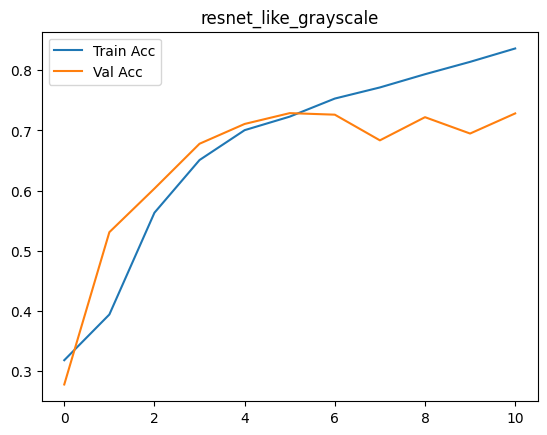

In [ ]:
model_name= 'resnet_like_grayscale'
plt.plot(gl_history[model_name].history['accuracy'])
plt.plot(gl_history[model_name].history['val_accuracy'])
plt.legend(['Train Acc','Val Acc'])
plt.title(model_name)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step  


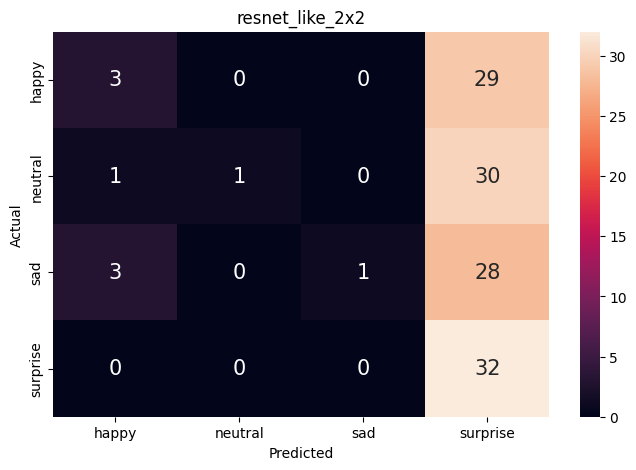

In [122]:
model_name = 'resnet_like_grayscale'
best_model = load_model(f'/content/drive/MyDrive/MIT_PE/trained_models/{model_name}.keras')
test_pred_logits = best_model.predict(datasets_data['Xtest'])
test_pred_labels = np.argmax(test_pred_logits, axis = -1)
cl_rep = classification_report(y_test,
                                test_pred_labels,
                                target_names=emotion_list,
                                output_dict=True
                                )
cm = confusion_matrix(y_test,
                        test_pred_labels)

plt.figure(figsize = (8, 5))
sns.heatmap(cm,
            xticklabels=emotion_list,
            yticklabels=emotion_list,
            annot = True,  fmt = '.0f',
            annot_kws={'size': 15})
plt.title(model_name)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [ ]:
df_models, df_model = create_dfs(model_name,
                                gl_clrep[model_name],
                                df_models)
df_model

happy    neutral        sad   surprise  \
Model                 Metric                                                  
resnet_like_grayscale precision   0.428571   1.000000   1.000000   0.268908   
                      recall      0.093750   0.031250   0.031250   1.000000   
                      f1-score    0.153846   0.060606   0.060606   0.423841   
                      support    32.000000  32.000000  32.000000  32.000000   

                                 accuracy   macro avg  weighted avg  
Model                 Metric                                         
resnet_like_grayscale precision  0.289062    0.674370      0.674370  
                      recall     0.289062    0.289062      0.289062  
                      f1-score   0.289062    0.174725      0.174725  
                      support    0.289062  128.000000    128.000000

## **ResNet-like GrayScale model with 5 Conv Blocks**

In [73]:
model_name = get_model_name('resnet_like_5_grayscale')
model_config_local = {
                    'model_name':model_name,
                    'input_shape':(48, 48, 1),
                    'kernel_size':(2,2),
                    'lr':0.001,
                    'epochs':100,
                    'steps_per_epoch':500,
                    'validation_steps':150,
                    'cl_w': None,
                    'aug': False,
                    'bn': False,
                    'dropout':False,
                    'opt':'Adam',
                    'callback_list':['checkpoint','early_stopping','reduce_learningrate']
                    }

with open(f"/content/drive/MyDrive/MIT_PE/model_configs/{model_name}.json", 'w') as fp:
    json.dump(model_config_local, fp)

In [74]:
np.random.seed(42)
import random
random.seed(42)
tf.random.set_seed(42)

print(f'>>>> Model name: {model_name}')

checkpoint = ModelCheckpoint(f"/content/drive/MyDrive/MIT_PE/trained_models/{model_name}.keras",
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True,
                             mode='max')

early_stopping = EarlyStopping(monitor = 'val_loss',
                              min_delta = 0,
                              patience = 5,
                              verbose = 1,
                              restore_best_weights = True
                              )

reduce_learningrate = ReduceLROnPlateau(monitor = 'val_loss',
                                        factor = 0.1,
                                        patience = 5,
                                        verbose = 1,
                                        min_delta = 0.0001)

callback_dict = {"checkpoint":checkpoint,
                 "early_stopping":early_stopping,
                 "reduce_learningrate":reduce_learningrate}

callback_list = [callback_dict[item] for item in model_config_local['callback_list']]

gl_models[model_name] = res_cnn_5(
                                input_shape = model_config_local['input_shape'],
                                kernel_size = model_config_local['kernel_size'],
                                aug = model_config_local['aug']
                               )

gl_models[model_name].compile(loss="categorical_crossentropy",
                              optimizer=opt_dict[model_config_local['opt']](learning_rate=model_config_local['lr']),
                              metrics=["accuracy"])

gl_history[model_name] = gl_models[model_name] .fit(train_set_bw_over,
                                                    steps_per_epoch=model_config_local['steps_per_epoch'],
                                                    epochs=model_config_local['epochs'],
                                                    validation_data=validation_set,
                                                    validation_steps=model_config_local['validation_steps'],
                                                    callbacks=callback_list,
                                                    class_weight=model_config_local['cl_w']
                                                    )

>>>> Model name: resnet_like_5_grayscale
Epoch 1/100
498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.3425 - loss: 1.3392

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 1: val_accuracy improved from -inf to 0.54688, saving model to /content/drive/MyDrive/MIT_PE/trained_models/resnet_like_5_grayscale.keras
500/500 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - accuracy: 0.3427 - loss: 1.3388 - val_accuracy: 0.5469 - val_loss: 1.0517 - learning_rate: 0.0010
Epoch 2/100
494/500 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5402 - loss: 1.0444
Epoch 2: val_accuracy improved from 0.54688 to 0.57062, saving model to /content/drive/MyDrive/MIT_PE/trained_models/resnet_like_5_grayscale.keras
500/500 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - accuracy: 0.5404 - loss: 1.0440 - val_accuracy: 0.5706 - val_loss: 0.9457 - learning_rate: 0.0010
Epoch 3/100
497/500 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6228 - loss: 0.8749
Epoch 3: val_accuracy improved from 0.57062 to 0.62250, saving model to /content/drive/MyDrive/MIT_PE/trained_models/resnet_like_5_grayscale.keras
500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.6229 - loss: 0.8748 - val_accuracy: 0.6225 

Text(0.5, 1.0, 'resnet_like_5_grayscale')

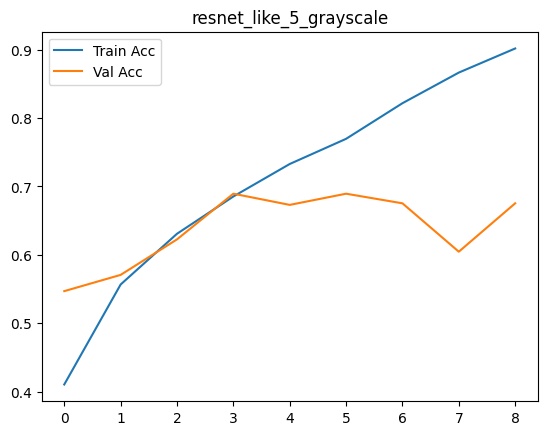

In [75]:
plt.plot(gl_history[model_name].history['accuracy'])
plt.plot(gl_history[model_name].history['val_accuracy'])
plt.legend(['Train Acc','Val Acc'])
plt.title(model_name)

In [90]:
best_model = load_model(f'/content/drive/MyDrive/MIT_PE/trained_models/{model_name}.keras')
test_pred_logits = best_model.predict(datasets_data['Xtest'])

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step


In [91]:
test_pred_labels = np.argmax(test_pred_logits, axis = -1)
cl_rep = classification_report(y_test,
                                test_pred_labels,
                                target_names=emotion_list,
                                output_dict=True
                                )

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [94]:
  cm = confusion_matrix(y_test,
                        test_pred_labels)

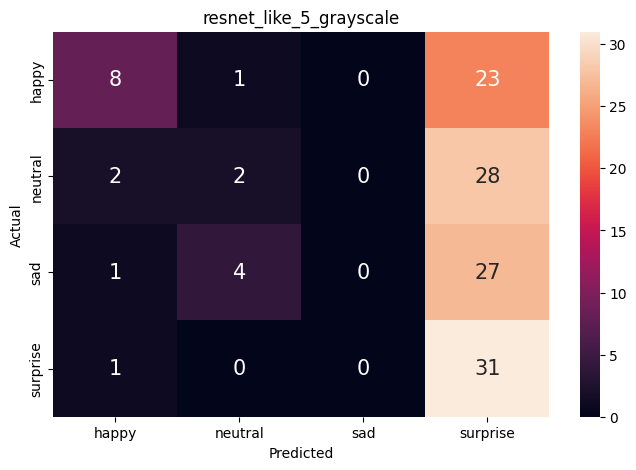

In [88]:
plt.figure(figsize = (8, 5))
sns.heatmap(cm,
            xticklabels=emotion_list,
            yticklabels=emotion_list,
            annot = True,  fmt = '.0f',
            annot_kws={'size': 15})
plt.title(model_name)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [89]:
df_models, df_model = create_dfs(model_name,
                                pd.DataFrame(cl_rep),
                                df_models)
df_model

happy    neutral   sad   surprise  \
Model                   Metric                                             
resnet_like_5_grayscale precision   0.666667   0.285714   0.0   0.284404   
                        recall      0.250000   0.062500   0.0   0.968750   
                        f1-score    0.363636   0.102564   0.0   0.439716   
                        support    32.000000  32.000000  32.0  32.000000   

                                   accuracy   macro avg  weighted avg  
Model                   Metric                                         
resnet_like_5_grayscale precision  0.320312    0.309196      0.309196  
                        recall     0.320312    0.320312      0.320312  
                        f1-score   0.320312    0.226479      0.226479  
                        support    0.320312  128.000000    128.000000

In [52]:
save_learning_data(model_name,
                   gl_history[model_name],
                   gl_clrep[model_name],
                   gl_cm[model_name]
                  )

backend.clear_session()

## **ResNet-like RGB model with 5 Conv Blocks**

In [62]:
model_name = get_model_name('resnet_like_5')
model_config_local = {
                    'model_name':model_name,
                    'input_shape':(48, 48, 3),
                    'kernel_size':(3,3),
                    'lr':0.001,
                    'epochs':100,
                    'steps_per_epoch':500,
                    'validation_steps':150,
                    'cl_w': None,
                    'aug': False,
                    'bn': False,
                    'dropout':False,
                    'opt':'Adam',
                    'callback_list':['checkpoint','early_stopping','reduce_learningrate']
                    }

with open(f"/content/drive/MyDrive/MIT_PE/model_configs/{model_name}.json", 'w') as fp:
    json.dump(model_config_local, fp)

In [68]:
np.random.seed(42)
import random
random.seed(42)
tf.random.set_seed(42)

print(f'>>>> Model name: {model_name}')

checkpoint = ModelCheckpoint(f"/content/drive/MyDrive/MIT_PE/trained_models/{model_name}.keras",
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True,
                             mode='max')

early_stopping = EarlyStopping(monitor = 'val_loss',
                              min_delta = 0,
                              patience = 5,
                              verbose = 1,
                              restore_best_weights = True
                              )

reduce_learningrate = ReduceLROnPlateau(monitor = 'val_loss',
                                        factor = 0.1,
                                        patience = 5,
                                        verbose = 1,
                                        min_delta = 0.0001)

callback_dict = {"checkpoint":checkpoint,
                 "early_stopping":early_stopping,
                 "reduce_learningrate":reduce_learningrate}

callback_list = [callback_dict[item] for item in model_config_local['callback_list']]

gl_models[model_name] = res_cnn_5(
                                input_shape = model_config_local['input_shape'],
                                kernel_size = model_config_local['kernel_size'],
                                aug = model_config_local['aug']
                               )

gl_models[model_name].compile(loss="categorical_crossentropy",
                              optimizer=opt_dict[model_config_local['opt']](learning_rate=model_config_local['lr']),
                              metrics=["accuracy"])

gl_history[model_name] = gl_models[model_name] .fit(train_set_rgb_over,
                                                    steps_per_epoch=model_config_local['steps_per_epoch'],
                                                    epochs=model_config_local['epochs'],
                                                    validation_data=validation_set_rgb,
                                                    validation_steps=model_config_local['validation_steps'],
                                                    callbacks=callback_list,
                                                    class_weight=model_config_local['cl_w']
                                                    )

>>>> Model name: resnet_like_5
Epoch 1/100
497/500 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.3406 - loss: 1.3576

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 1: val_accuracy improved from -inf to 0.50896, saving model to /content/drive/MyDrive/MIT_PE/trained_models/resnet_like_5.keras
500/500 ━━━━━━━━━━━━━━━━━━━━ 30s 27ms/step - accuracy: 0.3410 - loss: 1.3569 - val_accuracy: 0.5090 - val_loss: 1.0710 - learning_rate: 0.0010
Epoch 2/100
495/500 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5610 - loss: 0.9965
Epoch 2: val_accuracy improved from 0.50896 to 0.58757, saving model to /content/drive/MyDrive/MIT_PE/trained_models/resnet_like_5.keras
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.5612 - loss: 0.9962 - val_accuracy: 0.5876 - val_loss: 0.9829 - learning_rate: 0.0010
Epoch 3/100
496/500 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6472 - loss: 0.8227
Epoch 3: val_accuracy improved from 0.58757 to 0.66917, saving model to /content/drive/MyDrive/MIT_PE/trained_models/resnet_like_5.keras
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.6472 - loss: 0.8227 - val_accuracy: 0.6692 - val_loss: 0.7951 - learning_r

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


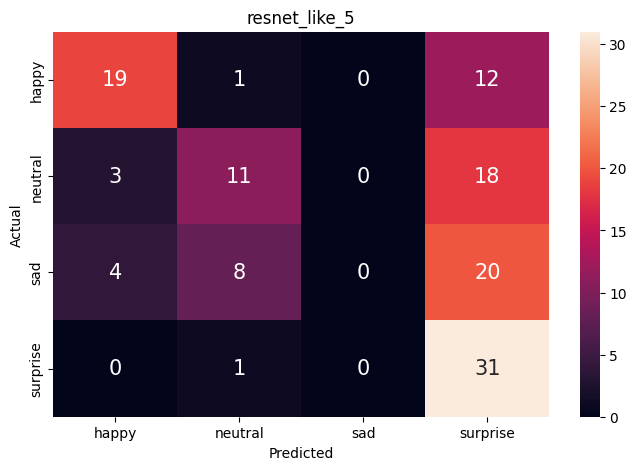

In [96]:
model_name = 'resnet_like_5'
best_model = load_model(f'/content/drive/MyDrive/MIT_PE/trained_models/{model_name}.keras')
test_pred_logits = best_model.predict(datasets_rgb['Xtest'])
test_pred_labels = np.argmax(test_pred_logits, axis = -1)
cl_rep = classification_report(y_test,
                                test_pred_labels,
                                target_names=emotion_list,
                                output_dict=True
                                )
cm = confusion_matrix(y_test,
                        test_pred_labels)
plt.figure(figsize = (8, 5))
sns.heatmap(cm,
            xticklabels=emotion_list,
            yticklabels=emotion_list,
            annot = True,  fmt = '.0f',
            annot_kws={'size': 15})
plt.title(model_name)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [97]:
df_models, df_model = create_dfs(model_name,
                                pd.DataFrame(cl_rep),
                                df_models)
df_model

happy    neutral   sad   surprise  accuracy  \
Model         Metric                                                       
resnet_like_5 precision   0.730769   0.523810   0.0   0.382716  0.476562   
              recall      0.593750   0.343750   0.0   0.968750  0.476562   
              f1-score    0.655172   0.415094   0.0   0.548673  0.476562   
              support    32.000000  32.000000  32.0  32.000000  0.476562   

                          macro avg  weighted avg  
Model         Metric                               
resnet_like_5 precision    0.409324      0.409324  
              recall       0.476562      0.476562  
              f1-score     0.404735      0.404735  
              support    128.000000    128.000000

In [ ]:
save_learning_data(model_name,
                   gl_history[model_name],
                   gl_clrep[model_name],
                   gl_cm[model_name]
                  )

backend.clear_session()

In [42]:
gl_models['resnet_like_5'].summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 48, 48, 3)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 48, 48, 32)     │            896 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 48, 48, 32)     │          9,248 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 24, 24, 32)     │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 24, 24, 32)     │            128 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 24, 24, 32)     │              0 │ max_pooling2d[0][0],   │
│                           │                        │                │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 24, 24, 64)     │         18,496 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 24, 24, 64)     │         36,928 │ conv2d_3[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 12, 12, 64)     │              0 │ conv2d_4[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 12, 12, 64)     │          2,112 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, 12, 12, 64)     │              0 │ max_pooling2d_1[0][0], │
│                           │                        │                │ conv2d_5[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 12, 12, 128)    │         73,856 │ add_1[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 12, 12, 128)    │        147,584 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 12, 12, 128)    │          8,320 │ add_1[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_2 (Add)               │ (None, 12, 12, 128)    │              0 │ conv2d_7[0][0],        │
│                           │                        │                │ conv2d_8[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 12, 12, 256)    │        295,168 │ add_2[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_10 (Conv2D)        │ (None, 12, 12, 256)    │        590,080 │ conv2d_9[0][0]         │
├──────────────────────

 Total params: 14,668,334 (55.96 MB)

 Trainable params: 4,889,444 (18.65 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 9,778,890 (37.30 MB)

## **ResNet-like RGB model**

### **Compiling and Training the Model**

In [ ]:
model_name = get_model_name('resnet_like')
model_config_local = {
                    'model_name':model_name,
                    'input_shape':(48, 48, 3),
                    'kernel_size':(3,3),
                    'lr':0.001,
                    'epochs':100,
                    'steps_per_epoch':500,
                    'validation_steps':150,
                    'cl_w': None,
                    'aug': False,
                    'bn': False,
                    'dropout':False,
                    'opt':'Adam',
                    'callback_list':['checkpoint','early_stopping','reduce_learningrate']
                    }

with open(f"/content/drive/MyDrive/MIT_PE/model_configs/{model_name}.json", 'w') as fp:
    json.dump(model_config_local, fp)

In [ ]:
np.random.seed(42)
import random
random.seed(42)
tf.random.set_seed(42)

print(f'>>>> Model name: {model_name}')

checkpoint = ModelCheckpoint(f"/content/drive/MyDrive/MIT_PE/trained_models/{model_name}.keras",
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True,
                             mode='max')

early_stopping = EarlyStopping(monitor = 'val_loss',
                              min_delta = 0,
                              patience = 5,
                              verbose = 1,
                              restore_best_weights = True
                              )

reduce_learningrate = ReduceLROnPlateau(monitor = 'val_loss',
                                        factor = 0.1,
                                        patience = 5,
                                        verbose = 1,
                                        min_delta = 0.0001)

callback_dict = {"checkpoint":checkpoint,
                 "early_stopping":early_stopping,
                 "reduce_learningrate":reduce_learningrate}

callback_list = [callback_dict[item] for item in model_config_local['callback_list']]

gl_models[model_name] = res_cnn(
                                input_shape = model_config_local['input_shape'],
                                kernel_size = model_config_local['kernel_size'],
                                aug = model_config_local['aug']
                               )

gl_models[model_name].compile(loss="categorical_crossentropy",
                              optimizer=opt_dict[model_config_local['opt']](learning_rate=model_config_local['lr']),
                              metrics=["accuracy"])

gl_history[model_name] = gl_models[model_name] .fit(train_set_rgb_over,
                                                    steps_per_epoch=model_config_local['steps_per_epoch'],
                                                    epochs=model_config_local['epochs'],
                                                    validation_data=validation_set_rgb,
                                                    validation_steps=model_config_local['validation_steps'],
                                                    callbacks=callback_list,
                                                    class_weight=model_config_local['cl_w']
                                                    )

>>>> Model name: resnet_like
Epoch 1/100
495/500 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.2823 - loss: 1.3775

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 1: val_accuracy improved from -inf to 0.24958, saving model to /content/drive/MyDrive/MIT_PE/trained_models/resnet_like.keras
500/500 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.2826 - loss: 1.3773 - val_accuracy: 0.2496 - val_loss: 1.4257 - learning_rate: 0.0010
Epoch 2/100
497/500 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3703 - loss: 1.3015
Epoch 2: val_accuracy improved from 0.24958 to 0.43503, saving model to /content/drive/MyDrive/MIT_PE/trained_models/resnet_like.keras
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.3705 - loss: 1.3011 - val_accuracy: 0.4350 - val_loss: 1.1880 - learning_rate: 0.0010
Epoch 3/100
498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5465 - loss: 1.0421
Epoch 3: val_accuracy improved from 0.43503 to 0.65521, saving model to /content/drive/MyDrive/MIT_PE/trained_models/resnet_like.keras
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.5466 - loss: 1.0418 - val_accuracy: 0.6552 - val_loss: 0.8460 - learning_rate: 0.00

Text(0.5, 1.0, 'resnet_like')

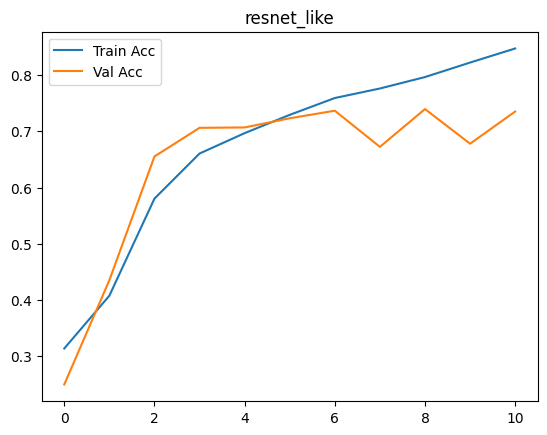

In [ ]:
model_name = 'resnet_like'

filehandler = open(f"/content/drive/MyDrive/MIT_PE/model_results/{model_name}.pickle","rb")
gl_history[model_name] = pickle.load(filehandler)
filehandler.close()

plt.plot(gl_history[model_name]['acc'])
plt.plot(gl_history[model_name]['val_acc'])

#plt.plot(gl_history[model_name].history['accuracy'])
#plt.plot(gl_history[model_name].history['val_accuracy'])
plt.legend(['Train Acc','Val Acc'])
plt.title(model_name)

In [ ]:
val_acc = np.array(gl_history[model_name]['val_acc'])
max_ind = np.argmax(val_acc)
print('Max training accuracy for the ResNet-like RGB model',gl_history[model_name]['acc'][max_ind])
print('Max validation accuracy for the ResNet-like RGB model',gl_history[model_name]['val_acc'][max_ind])

Max training accuracy for the ResNet-like RGB model 0.7965218424797058
Max validation accuracy for the ResNet-like RGB model 0.7395833134651184


### **Evaluating the Model on the Test Set**

**Observations and Insights:__**

### **Plotting the Confusion Matrix for the chosen final model**

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step  


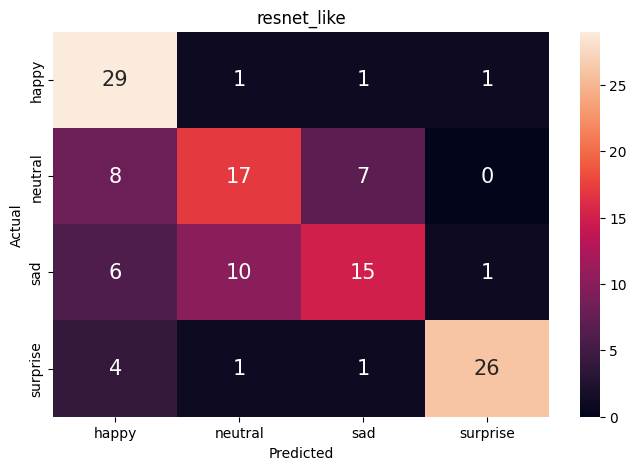

In [53]:
model_name = 'resnet_like'
gl_clrep[model_name], gl_cm[model_name] = compute_test_stats(model_name,
                                                             datasets_rgb,
                                                             y_test)

In [31]:
df_models, df_model = create_dfs(model_name,
                                gl_clrep[model_name],
                                df_models)
df_model

happy    neutral        sad   surprise  accuracy  \
Model       Metric                                                            
resnet_like precision   0.617021   0.586207   0.625000   0.928571  0.679688   
            recall      0.906250   0.531250   0.468750   0.812500  0.679688   
            f1-score    0.734177   0.557377   0.535714   0.866667  0.679688   
            support    32.000000  32.000000  32.000000  32.000000  0.679688   

                        macro avg  weighted avg  
Model       Metric                               
resnet_like precision    0.689200      0.689200  
            recall       0.679688      0.679688  
            f1-score     0.673484      0.673484  
            support    128.000000    128.000000

In [54]:
model_name = 'resnet_like'
resnet_like_model = load_model(f'/content/drive/MyDrive/MIT_PE/trained_models/{model_name}.keras')
resnet_like_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 48, 48, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_18 (Conv2D)        │ (None, 48, 48, 32)     │            896 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_19 (Conv2D)        │ (None, 48, 48, 32)     │          9,248 │ conv2d_18[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_4           │ (None, 24, 24, 32)     │              0 │ conv2d_19[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_20 (Conv2D)        │ (None, 24, 24, 32)     │            128 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_6 (Add)               │ (None, 24, 24, 32)     │              0 │ max_pooling2d_4[0][0], │
│                           │                        │                │ conv2d_20[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_21 (Conv2D)        │ (None, 24, 24, 64)     │         18,496 │ add_6[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_22 (Conv2D)        │ (None, 24, 24, 64)     │         36,928 │ conv2d_21[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_5           │ (None, 12, 12, 64)     │              0 │ conv2d_22[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_23 (Conv2D)        │ (None, 12, 12, 64)     │          2,112 │ add_6[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_7 (Add)               │ (None, 12, 12, 64)     │              0 │ max_pooling2d_5[0][0], │
│                           │                        │                │ conv2d_23[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_24 (Conv2D)        │ (None, 12, 12, 128)    │         73,856 │ add_7[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_25 (Conv2D)        │ (None, 12, 12, 128)    │        147,584 │ conv2d_24[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_26 (Conv2D)        │ (None, 12, 12, 128)    │          8,320 │ add_7[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_8 (Add)               │ (None, 12, 12, 128)    │              0 │ conv2d_25[0][0],       │
│                           │                        │                │ conv2d_26[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 128)            │              0 │ add_8[0][0]            │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├──────────────────────

 Total params: 894,254 (3.41 MB)

 Trainable params: 298,084 (1.14 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 596,170 (2.27 MB)

In [ ]:
save_learning_data(model_name,
                   gl_history[model_name],
                   gl_clrep[model_name],
                   gl_cm[model_name]
                  )

backend.clear_session()

**Observations and Insights:__**

In the above section several deep CNNs were tested.

We started with defining 3 and 5 conv block resnet-like models.

Then we tested these models using GrayScale and RGB inputs.

The results are presented in the tables below.

In [98]:
model_names = [
               {'model':'resnet_like_grayscale','rgb':False},
               {'model':'resnet_like_5_grayscale','rgb':False},
               {'model':'resnet_like_5','rgb':True},
               {'model':'resnet_like','rgb':True},
               ]

In [101]:
res_models_def = pd.DataFrame()

for item in model_names:
  model_name_ = item['model']
  rgb = item['rgb']
  print(f'>>>> Model {model_name_}')
  gl_clrep, gl_cm = compute_test_stats(model_name_,
                                      datasets_rgb if rgb else datasets_data,
                                      y_test,
                                      show_cm=False
                                      )
  res_models_def, df_model = create_dfs(model_name_,
                                  gl_clrep,
                                  res_models_def)
  #df_model

>>>> Model resnet_like_grayscale
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  
>>>> Model resnet_like_5_grayscale
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step  


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


>>>> Model resnet_like_5
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
>>>> Model resnet_like


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step  


In [104]:
resnet_model_list = ['resnet_like_grayscale',
                     'resnet_like_5_grayscale',
                     'resnet_like_5',
                     'resnet_like']
res_df = res_models_def.loc[resnet_model_list]
res_df = res_df.drop_duplicates()
res_df

happy    neutral        sad   surprise  \
Model                   Metric                                                  
resnet_like_grayscale   precision   0.428571   1.000000   1.000000   0.268908   
                        recall      0.093750   0.031250   0.031250   1.000000   
                        f1-score    0.153846   0.060606   0.060606   0.423841   
                        support    32.000000  32.000000  32.000000  32.000000   
resnet_like_5_grayscale precision   0.666667   0.285714   0.000000   0.284404   
                        recall      0.250000   0.062500   0.000000   0.968750   
                        f1-score    0.363636   0.102564   0.000000   0.439716   
                        support    32.000000  32.000000  32.000000  32.000000   
resnet_like_5           precision   0.730769   0.523810   0.000000   0.382716   
                        recall      0.593750   0.343750   0.000000   0.968750   
                        f1-score    0.655172   0.415094   0.000000   0.548673   
                        support    32.000000  32.000000  32.000000  32.000000   
resnet_like             precision   0.617021   0.586207   0.625000   0.928571   
                        recall      0.906250   0.531250   0.468750   0.812500   
                        f1-score    0.734177   0.557377   0.535714   0.866667   
                        support    32.000000  32.000000  32.000000  32.000000   

                                   accuracy   macro avg  weighted avg  
Model                   Metric                                         
resnet_like_grayscale   precision  0.289062    0.674370      0.674370  
                        recall     0.289062    0.289062      0.289062  
                        f1-score   0.289062    0.174725      0.174725  
                        support    0.289062  128.000000    128.000000  
resnet_like_5_grayscale precision  0.320312    0.309196      0.309196  
                        recall     0.320312    0.320312      0.320312  
                        f1-score   0.320312    0.226479      0.226479  
                        support    0.320312  128.000000    128.000000  
resnet_like_5           precision  0.476562    0.409324      0.409324  
                        recall     0.476562    0.476562      0.476562  
                        f1-score   0.476562    0.404735      0.404735  
                        support    0.476562  128.000000    128.000000  
resnet_like             precision  0.679688    0.689200      0.689200  
                        recall     0.679688    0.679688      0.679688  
                        f1-score   0.679688    0.673484      0.673484  
                        support    0.679688  128.000000    128.000000

Looking at the above table, we can infer that for ResNet-like model with 3 blocks and RBG input, the weighted average (weighted avg) values for precision, recall and f1-score as well as test accuracy (accuracy) are the highest among ResNet-like models.

**Next we will try to improve ResNet-like model with 3 conv blocks by changing optimizer, activation functions**

## **Resnet-like model RGB Silu actication and Adamax**

### **Compiling and Training the Model**

In [ ]:
np.random.seed(42)
import random
random.seed(42)
tf.random.set_seed(42)

model_name = get_model_name('resnet_like_silu_adamax_32')

print(f'>>>> Model name: {model_name}')

checkpoint = ModelCheckpoint(f"/content/drive/MyDrive/MIT_PE/trained_models/{model_name}.keras",
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True,
                             mode='max')

early_stopping = EarlyStopping(monitor = 'val_loss',
                              min_delta = 0,
                              patience = 10,
                              verbose = 1,
                              restore_best_weights = True
                              )

reduce_learningrate = ReduceLROnPlateau(monitor = 'val_loss',
                                        factor = 0.1,
                                        patience = 5,
                                        verbose = 1,
                                        min_delta = 0.0001)

callback_dict = {"checkpoint":checkpoint,
                 "early_stopping":early_stopping,
                 "reduce_learningrate":reduce_learningrate}


mode_config_local = {
                    'batch_size':32,
                    'activation':'silu',
                    'model_name':model_name,
                    'input_shape':(48, 48, 3),
                    'kernel_size':(3,3),
                    'lr':0.001,
                    'epochs':100,
                    'steps_per_epoch':500,
                    'validation_steps':150,
                    'cl_w': None,
                    'aug': False,
                    'bn': False,
                    'dropout':False,
                    'opt':'Adamax',
                    'callback_list':['checkpoint','early_stopping','reduce_learningrate']
                    }

with open(f"/content/drive/MyDrive/MIT_PE/model_configs/{model_name}.json", 'w') as fp:
    json.dump(mode_config_local, fp)


callback_list = [callback_dict[item] for item in mode_config_local['callback_list']]

gl_models[model_name] = res_cnn(
                                input_shape = mode_config_local['input_shape'],
                                kernel_size = mode_config_local['kernel_size'],
                                activation = mode_config_local['activation'],
                                aug = mode_config_local['aug']
                               )

gl_models[model_name].compile(loss="categorical_crossentropy",
                              optimizer=opt_dict[mode_config_local['opt']](learning_rate=mode_config_local['lr']),
                              metrics=["accuracy"])

gl_history[model_name] = gl_models[model_name] .fit(train_set_rgb_over,
                                                    steps_per_epoch=mode_config_local['steps_per_epoch'],
                                                    epochs=mode_config_local['epochs'],
                                                    validation_data=validation_set_rgb,
                                                    validation_steps=mode_config_local['validation_steps'],
                                                    callbacks=callback_list,
                                                    class_weight=mode_config_local['cl_w']
                                                    )

>>>> Model name: resnet_like_silu_adamax_32
Epoch 1/100
493/500 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.2925 - loss: 1.3717

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 1: val_accuracy improved from -inf to 0.25729, saving model to /content/drive/MyDrive/MIT_PE/trained_models/resnet_like_silu_adamax_32.keras
500/500 ━━━━━━━━━━━━━━━━━━━━ 15s 17ms/step - accuracy: 0.2928 - loss: 1.3715 - val_accuracy: 0.2573 - val_loss: 1.3715 - learning_rate: 0.0010
Epoch 2/100
498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.3391 - loss: 1.3375
Epoch 2: val_accuracy improved from 0.25729 to 0.34463, saving model to /content/drive/MyDrive/MIT_PE/trained_models/resnet_like_silu_adamax_32.keras
500/500 ━━━━━━━━━━━━━━━━━━━━ 16s 15ms/step - accuracy: 0.3391 - loss: 1.3374 - val_accuracy: 0.3446 - val_loss: 1.3102 - learning_rate: 0.0010
Epoch 3/100
493/500 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3692 - loss: 1.3025
Epoch 3: val_accuracy improved from 0.34463 to 0.41292, saving model to /content/drive/MyDrive/MIT_PE/trained_models/resnet_like_silu_adamax_32.keras
500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.3693 - loss: 1.3024 - val_accuracy:

Text(0.5, 1.0, 'resnet_like_silu_adamax_32')

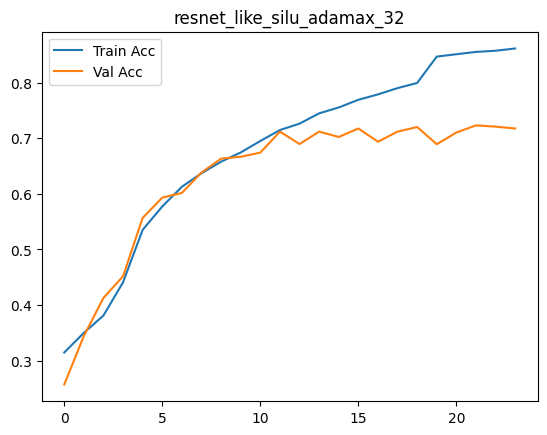

In [ ]:
plt.plot(gl_history[model_name].history['accuracy'])
plt.plot(gl_history[model_name].history['val_accuracy'])
plt.legend(['Train Acc','Val Acc'])
plt.title(model_name)

### **Evaluating the Model on the Test Set**

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Logits [1. 0. 0. 0.] should sum up to 1.0: True


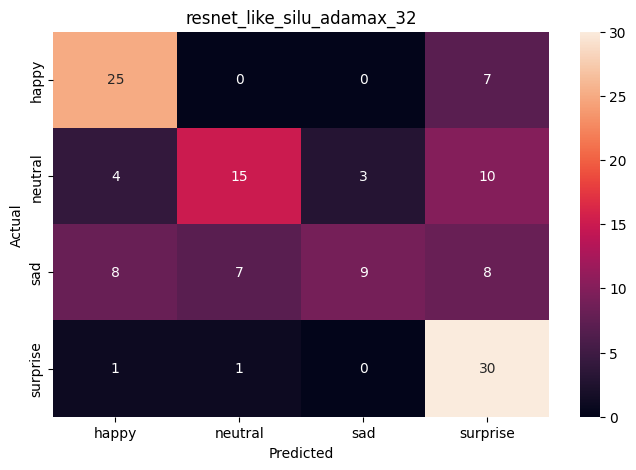

In [ ]:
gl_clrep[model_name], gl_cm[model_name] = compute_test_stats(model_name,
                                                             datasets_rgb,
                                                             y_test)

In [ ]:
df_models, df_model = create_dfs(model_name,
                                gl_clrep[model_name],
                                df_models)
df_model

happy    neutral        sad  \
Model                      Metric                                       
resnet_like_silu_adamax_32 precision   0.657895   0.652174   0.750000   
                           recall      0.781250   0.468750   0.281250   
                           f1-score    0.714286   0.545455   0.409091   
                           support    32.000000  32.000000  32.000000   

                                       surprise  accuracy   macro avg  \
Model                      Metric                                       
resnet_like_silu_adamax_32 precision   0.545455  0.617188    0.651381   
                           recall      0.937500  0.617188    0.617188   
                           f1-score    0.689655  0.617188    0.589622   
                           support    32.000000  0.617188  128.000000   

                                      weighted avg  
Model                      Metric                   
resnet_like_silu_adamax_32 precision      0.651381  
                           recall         0.617188  
                           f1-score       0.589622  
                           support      128.000000

In [ ]:
save_learning_data(model_name,
                   gl_history[model_name],
                   gl_clrep[model_name],
                   gl_cm[model_name]
                  )

backend.clear_session()

## **Resnet like RBG Silu activation**

In [ ]:
np.random.seed(42)
import random
random.seed(42)
tf.random.set_seed(42)

model_name = get_model_name('resnet_like_silu_adam_32')

print(f'>>>> Model name: {model_name}')

checkpoint = ModelCheckpoint(f"/content/drive/MyDrive/MIT_PE/trained_models/{model_name}.keras",
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True,
                             mode='max')

early_stopping = EarlyStopping(monitor = 'val_loss',
                              min_delta = 0,
                              patience = 10,
                              verbose = 1,
                              restore_best_weights = True
                              )

reduce_learningrate = ReduceLROnPlateau(monitor = 'val_loss',
                                        factor = 0.1,
                                        patience = 5,
                                        verbose = 1,
                                        min_delta = 0.0001)

callback_dict = {"checkpoint":checkpoint,
                 "early_stopping":early_stopping,
                 "reduce_learningrate":reduce_learningrate}


mode_config_local = {
                    'batch_size':32,
                    'activation':'silu',
                    'model_name':model_name,
                    'input_shape':(48, 48, 3),
                    'kernel_size':(3,3),
                    'lr':0.001,
                    'epochs':100,
                    'steps_per_epoch':500,
                    'validation_steps':150,
                    'cl_w': None,
                    'aug': False,
                    'bn': False,
                    'dropout':False,
                    'opt':'Adam',
                    'callback_list':['checkpoint','early_stopping','reduce_learningrate']
                    }

with open(f"/content/drive/MyDrive/MIT_PE/model_configs/{model_name}.json", 'w') as fp:
    json.dump(mode_config_local, fp)


callback_list = [callback_dict[item] for item in mode_config_local['callback_list']]

gl_models[model_name] = res_cnn(
                                input_shape = mode_config_local['input_shape'],
                                kernel_size = mode_config_local['kernel_size'],
                                activation = mode_config_local['activation'],
                                aug = mode_config_local['aug']
                               )

gl_models[model_name].compile(loss="categorical_crossentropy",
                              optimizer=opt_dict[mode_config_local['opt']](learning_rate=mode_config_local['lr']),
                              metrics=["accuracy"])

gl_history[model_name] = gl_models[model_name] .fit(train_set_rgb_over,
                                                    steps_per_epoch=mode_config_local['steps_per_epoch'],
                                                    epochs=mode_config_local['epochs'],
                                                    validation_data=validation_set_rgb,
                                                    validation_steps=mode_config_local['validation_steps'],
                                                    callbacks=callback_list,
                                                    class_weight=mode_config_local['cl_w']
                                                    )

>>>> Model name: resnet_like_silu_adam_32
Epoch 1/100
494/500 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2919 - loss: 1.3757

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 1: val_accuracy improved from -inf to 0.33062, saving model to /content/drive/MyDrive/MIT_PE/trained_models/resnet_like_silu_adam_32.keras
500/500 ━━━━━━━━━━━━━━━━━━━━ 22s 21ms/step - accuracy: 0.2922 - loss: 1.3755 - val_accuracy: 0.3306 - val_loss: 1.3132 - learning_rate: 0.0010
Epoch 2/100
493/500 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.3642 - loss: 1.3118
Epoch 2: val_accuracy improved from 0.33062 to 0.55932, saving model to /content/drive/MyDrive/MIT_PE/trained_models/resnet_like_silu_adam_32.keras
500/500 ━━━━━━━━━━━━━━━━━━━━ 19s 27ms/step - accuracy: 0.3646 - loss: 1.3114 - val_accuracy: 0.5593 - val_loss: 1.1583 - learning_rate: 0.0010
Epoch 3/100
494/500 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5047 - loss: 1.1289
Epoch 3: val_accuracy improved from 0.55932 to 0.58708, saving model to /content/drive/MyDrive/MIT_PE/trained_models/resnet_like_silu_adam_32.keras
500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - accuracy: 0.5051 - loss: 1.1283 - val_accuracy: 0.58

Text(0.5, 1.0, 'resnet_like_silu_adam_32')

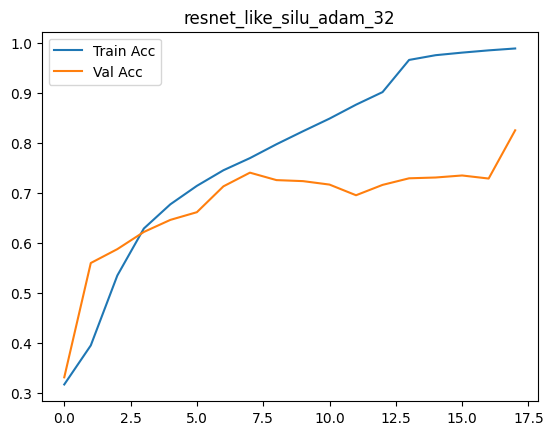

In [ ]:
plt.plot(gl_history[model_name].history['accuracy'])
plt.plot(gl_history[model_name].history['val_accuracy'])
plt.legend(['Train Acc','Val Acc'])
plt.title(model_name)

### **Evaluating the Model on the Test Set**

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step  
Logits [1. 0. 0. 0.] should sum up to 1.0: True


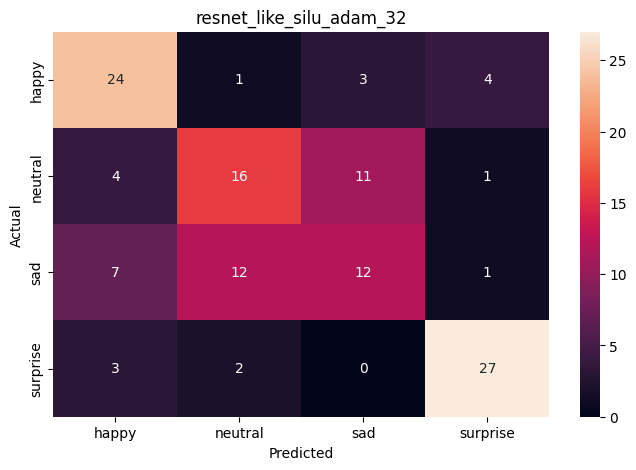

In [ ]:
gl_clrep[model_name], gl_cm[model_name] = compute_test_stats(model_name,
                                                             datasets_rgb,
                                                             y_test)

In [ ]:
df_models, df_model = create_dfs(model_name,
                                gl_clrep[model_name],
                                df_models)
df_model

happy    neutral        sad  \
Model                    Metric                                       
resnet_like_silu_adam_32 precision   0.631579   0.516129   0.461538   
                         recall      0.750000   0.500000   0.375000   
                         f1-score    0.685714   0.507937   0.413793   
                         support    32.000000  32.000000  32.000000   

                                     surprise  accuracy   macro avg  \
Model                    Metric                                       
resnet_like_silu_adam_32 precision   0.818182  0.617188    0.606857   
                         recall      0.843750  0.617188    0.617188   
                         f1-score    0.830769  0.617188    0.609553   
                         support    32.000000  0.617188  128.000000   

                                    weighted avg  
Model                    Metric                   
resnet_like_silu_adam_32 precision      0.606857  
                         recall         0.617188  
                         f1-score       0.609553  
                         support      128.000000

In [ ]:
save_learning_data(model_name,
                   gl_history[model_name],
                   gl_clrep[model_name],
                   gl_cm[model_name]
                  )

backend.clear_session()

**ResNet-like 3 conv block model variations results:**

In [106]:
model_names = [
               {'model':'resnet_like','rgb':True},
               {'model':'resnet_like_silu_adamax_32','rgb':True},
               {'model':'resnet_like_silu_adam_32','rgb':True},
               ]

res_models_df = pd.DataFrame()

for item in model_names:
  model_name_ = item['model']
  rgb = item['rgb']
  print(f'>>>> Model {model_name_}')
  gl_clrep, gl_cm = compute_test_stats(model_name_,
                                      datasets_rgb if rgb else datasets_data,
                                      y_test,
                                      show_cm=False
                                      )
  res_models_df, df_model = create_dfs(model_name_,
                                  gl_clrep,
                                  res_models_df)

resnet_model_list = ['resnet_like',
                     'resnet_like_silu_adamax_32',
                     'resnet_like_silu_adam_32']
res_df = res_models_df.loc[resnet_model_list]
res_df = res_models_df.drop_duplicates()
res_df

>>>> Model resnet_like
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
>>>> Model resnet_like_silu_adamax_32
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
>>>> Model resnet_like_silu_adam_32
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step  


happy    neutral        sad  \
Model                      Metric                                       
resnet_like                precision   0.617021   0.586207   0.625000   
                           recall      0.906250   0.531250   0.468750   
                           f1-score    0.734177   0.557377   0.535714   
                           support    32.000000  32.000000  32.000000   
resnet_like_silu_adamax_32 precision   0.657895   0.652174   0.750000   
                           recall      0.781250   0.468750   0.281250   
                           f1-score    0.714286   0.545455   0.409091   
                           support    32.000000  32.000000  32.000000   
resnet_like_silu_adam_32   precision   0.631579   0.516129   0.461538   
                           recall      0.750000   0.500000   0.375000   
                           f1-score    0.685714   0.507937   0.413793   

                                       surprise  accuracy   macro avg  \
Model                      Metric                                       
resnet_like                precision   0.928571  0.679688    0.689200   
                           recall      0.812500  0.679688    0.679688   
                           f1-score    0.866667  0.679688    0.673484   
                           support    32.000000  0.679688  128.000000   
resnet_like_silu_adamax_32 precision   0.545455  0.617188    0.651381   
                           recall      0.937500  0.617188    0.617188   
                           f1-score    0.689655  0.617188    0.589622   
                           support    32.000000  0.617188  128.000000   
resnet_like_silu_adam_32   precision   0.818182  0.617188    0.606857   
                           recall      0.843750  0.617188    0.617188   
                           f1-score    0.830769  0.617188    0.609553   

                                      weighted avg  
Model                      Metric                   
resnet_like                precision      0.689200  
                           recall         0.679688  
                           f1-score       0.673484  
                           support      128.000000  
resnet_like_silu_adamax_32 precision      0.651381  
                           recall         0.617188  
                           f1-score       0.589622  
                           support      128.000000  
resnet_like_silu_adam_32   precision      0.606857  
                           recall         0.617188  
                           f1-score       0.609553

**Observations and Insights:__**<br>
According to the above table, it was not possible to improve ResNet-like model with 3 conv blocks by changing optimizer, activation functions.

Therefore the best model is

## **ResNet-like RGB 3 convd blocks model**

In [110]:
model_name

'resnet_like_5'

In [111]:
model_name = 'resnet_like'
filehandler = open(f"/content/drive/MyDrive/MIT_PE/model_results/{model_name}.pickle","rb")
learning_data = pickle.load(filehandler)
filehandler.close()

In [112]:
val_acc = np.array(learning_data['val_acc'])
max_ind = np.argmax(val_acc)
print(f'Best epoch is {max_ind}')
print('Training accuracy model for the ResNet-like RGB model',learning_data['acc'][max_ind])
print('Max validation accuracy for the ResNet-like RGB model',learning_data['val_acc'][max_ind])

Best epoch is 8
Training accuracy model for the ResNet-like RGB model 0.7965218424797058
Max validation accuracy for the ResNet-like RGB model 0.7395833134651184


### **Evaluating the Model on the Test Set**

**Observations and Insights:__**

This model exhibits the besr performance among all tested models.

The weighted avg for precision, recall and f1-score are 0.689, 0.679 and 0.673, respectively.

The test accuracy is 0.679.

Training accuracy for the best model is 0.796
Max validation accuracy for the best model is 0.739.
the best model was achieved on epoch 8.

In [ ]:
df_models, df_model = create_dfs(model_name,
                                gl_clrep[model_name],
                                df_models)
df_model

happy    neutral        sad   surprise  accuracy  \
Model       Metric                                                            
resnet_like precision   0.617021   0.586207   0.625000   0.928571  0.679688   
            recall      0.906250   0.531250   0.468750   0.812500  0.679688   
            f1-score    0.734177   0.557377   0.535714   0.866667  0.679688   
            support    32.000000  32.000000  32.000000  32.000000  0.679688   

                        macro avg  weighted avg  
Model       Metric                               
resnet_like precision    0.689200      0.689200  
            recall       0.679688      0.679688  
            f1-score     0.673484      0.673484  
            support    128.000000    128.000000

### **Plotting the Confusion Matrix for the chosen final model**

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step  


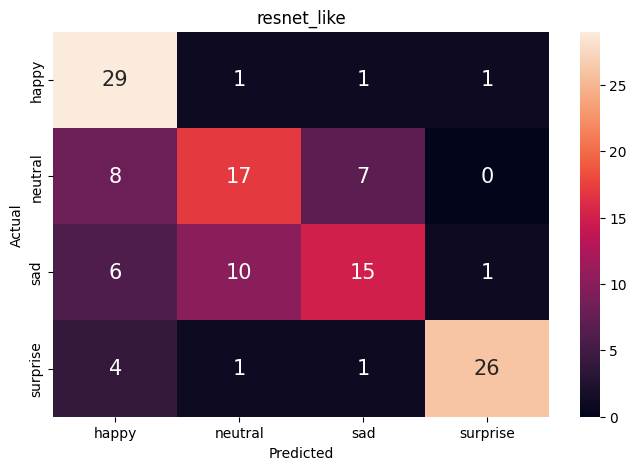

In [55]:
model_name = 'resnet_like'
gl_clrep[model_name], gl_cm[model_name] = compute_test_stats(model_name,
                                                             datasets_rgb,
                                                             y_test)

In [32]:
best_model = load_model(f'/content/drive/MyDrive/MIT_PE/trained_models/{model_name}.keras')
best_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 48, 48, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_18 (Conv2D)        │ (None, 48, 48, 32)     │            896 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_19 (Conv2D)        │ (None, 48, 48, 32)     │          9,248 │ conv2d_18[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_4           │ (None, 24, 24, 32)     │              0 │ conv2d_19[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_20 (Conv2D)        │ (None, 24, 24, 32)     │            128 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_6 (Add)               │ (None, 24, 24, 32)     │              0 │ max_pooling2d_4[0][0], │
│                           │                        │                │ conv2d_20[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_21 (Conv2D)        │ (None, 24, 24, 64)     │         18,496 │ add_6[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_22 (Conv2D)        │ (None, 24, 24, 64)     │         36,928 │ conv2d_21[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_5           │ (None, 12, 12, 64)     │              0 │ conv2d_22[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_23 (Conv2D)        │ (None, 12, 12, 64)     │          2,112 │ add_6[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_7 (Add)               │ (None, 12, 12, 64)     │              0 │ max_pooling2d_5[0][0], │
│                           │                        │                │ conv2d_23[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_24 (Conv2D)        │ (None, 12, 12, 128)    │         73,856 │ add_7[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_25 (Conv2D)        │ (None, 12, 12, 128)    │        147,584 │ conv2d_24[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_26 (Conv2D)        │ (None, 12, 12, 128)    │          8,320 │ add_7[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_8 (Add)               │ (None, 12, 12, 128)    │              0 │ conv2d_25[0][0],       │
│                           │                        │                │ conv2d_26[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 128)            │              0 │ add_8[0][0]            │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├──────────────────────

 Total params: 894,254 (3.41 MB)

 Trainable params: 298,084 (1.14 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 596,170 (2.27 MB)

## **Conclusion:____________**

During these experiments, we have tested various CNN architectures including CNNs with feedfoward flow of processing as well as architectures with skip connections.

Through a large number of experiment we could figure out parameters to apply to the final complex architecture.

For the final round of testing, we have tested 4 models based on ResNet-like architecture, i.e., models with 3 vs. 5 conv blocks and Grayscale vs. RBG input.

The best model is ResNet-like 5 conv block RGB model.  

In [51]:
model_names_short_list = ['simple_cnn_grayscale',
               'simple_cnn_rgb',
               'simple_cnn_rgb_2x2_under',
               'simple_cnn_rgb_2x2_over',
               'larger_cnn_rgb',
               'vgg16_tl',
               'vgg16_tl_trainable',
               'resnetV2_tl',
               'resnetV2_tl_trainable',
               'efficientnet_tl',
               'resnet_like'
               ]

In [44]:
model_names = [{'model':'simple_cnn_grayscale','rgb':False},
               {'model':'simple_cnn_rgb','rgb':True},
               {'model':'simple_cnn_rgb_filter3x3','rgb':True},
               {'model':'simple_cnn_rgb_2x2_under','rgb':True},
               {'model':'simple_cnn_rgb_2x2_over','rgb':True},
               {'model':'larger_cnn_rgb','rgb':True},
               {'model':'vgg16_tl','rgb':True},
               {'model':'vgg16_tl_trainable','rgb':True},
               {'model':'resnetV2_tl','rgb':True},
               {'model':'resnetV2_tl_trainable','rgb':True},
               {'model':'efficientnet_tl','rgb':True},
               {'model':'resnet_like','rgb':True},
               ]

In [49]:
for item in model_names:
  model_name = item['model']
  rgb = item['rgb']
  print(f'>>>> Model {model_name}')
  gl_clrep, gl_cm = compute_test_stats(model_name,
                                      datasets_rgb if rgb else datasets_data,
                                      y_test,
                                      show_cm=False
                                      )
  df_models, df_model = create_dfs(model_name,
                                  gl_clrep,
                                  df_models)

>>>> Model simple_cnn_grayscale
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step
>>>> Model simple_cnn_rgb
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step
>>>> Model simple_cnn_rgb_filter3x3
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step
>>>> Model simple_cnn_rgb_2x2_under
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step
>>>> Model simple_cnn_rgb_2x2_over
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step
>>>> Model larger_cnn_rgb
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step
>>>> Model vgg16_tl
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step
>>>> Model vgg16_tl_trainable
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 931ms/step
>>>> Model resnetV2_tl
4/4 ━━━━━━━━━━━━━━━━━━━━ 23s 3s/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


>>>> Model resnetV2_tl_trainable
4/4 ━━━━━━━━━━━━━━━━━━━━ 23s 3s/step
>>>> Model efficientnet_tl
4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 777ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


>>>> Model resnet_like
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 159ms/step


In [52]:
pd.set_option("display.max_rows", None)

In [58]:
prec_list = []
recall_list = []
f1_list = []
test_acc_list = []
for model_name in model_names_short_list:
  try:
    recall_list.append(df_models.loc[(model_name,'recall')]['weighted avg'].values[0])
  except:
    recall_list.append(0.0)

  prec_list.append(df_models.loc[(model_name,'precision')]['weighted avg'].values[0])
  f1_list.append(df_models.loc[(model_name,'f1-score')]['weighted avg'].values[0])
  test_acc_list.append(df_models.loc[(model_name,'precision')]['accuracy'].values[0])

data_dict = {
             'model name':  model_names_short_list,
             'precision':  prec_list,
             'recall':  recall_list,
             'f1-score':  f1_list,
             'test acc':  test_acc_list,
            }

df_results = pd.DataFrame(data_dict)


<ipython-input-58-102170e20cdd>:7: PerformanceWarning: indexing past lexsort depth may impact performance.
  recall_list.append(df_models.loc[(model_name,'recall')]['weighted avg'].values[0])
<ipython-input-58-102170e20cdd>:11: PerformanceWarning: indexing past lexsort depth may impact performance.
  prec_list.append(df_models.loc[(model_name,'precision')]['weighted avg'].values[0])
<ipython-input-58-102170e20cdd>:12: PerformanceWarning: indexing past lexsort depth may impact performance.
  f1_list.append(df_models.loc[(model_name,'f1-score')]['weighted avg'].values[0])
<ipython-input-58-102170e20cdd>:13: PerformanceWarning: indexing past lexsort depth may impact performance.
  test_acc_list.append(df_models.loc[(model_name,'precision')]['accuracy'].values[0])


In [62]:
print('Weighted average values for precision, recall and f1-score metrics + test accuracy for each model')
df_results

Weighted average values for precision, recall and f1-score metrics + test accuracy for each model


model name  precision    recall  f1-score  test acc
0       simple_cnn_grayscale   0.433609  0.468750  0.443772  0.468750
1             simple_cnn_rgb   0.543023  0.539062  0.519088  0.539062
2   simple_cnn_rgb_2x2_under   0.470770  0.484375  0.415837  0.484375
3    simple_cnn_rgb_2x2_over   0.581464  0.585938  0.580455  0.585938
4             larger_cnn_rgb   0.523568  0.531250  0.503369  0.531250
5                   vgg16_tl   0.347253  0.304688  0.298498  0.304688
6         vgg16_tl_trainable   0.634939  0.609375  0.601130  0.609375
7                resnetV2_tl   0.312992  0.257812  0.115780  0.257812
8      resnetV2_tl_trainable   0.127091  0.203125  0.129640  0.203125
9            efficientnet_tl   0.063492  0.000000  0.101266  0.250000
10               resnet_like   0.689200  0.679688  0.673484  0.679688

In the table above, we have summirized metrics for 11 selected models, which are the key points in the overall research.

The data from the table above are presented in the chart format below.

<Figure size 1000x600 with 0 Axes>

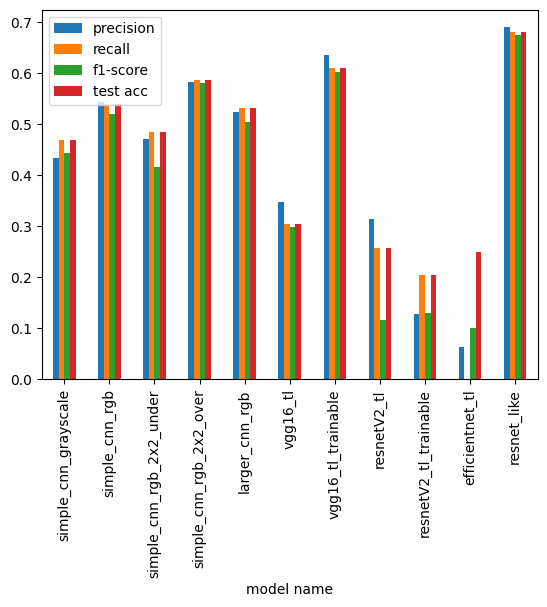

In [60]:
plt.figure(figsize=(10,6))
ax = df_results.plot(x="model name", y=["precision", "recall", "f1-score","test acc"], kind="bar", rot=0)
plt.xticks(rotation=90)
plt.legend(loc='upper left')
plt.show()

### **Insights**

### **Refined insights**:
- What are the most meaningful insights from the data relevant to the problem?

**Conclusion** <br>
- Data are grayscale images
- Data are unbalanced: there is uneven describution of date across classes in Validation dataset. For Train dataset, surprise class is undersampled by 21% in comparison with other three classes


### **Comparison of various techniques and their relative performance**:
- How do different techniques perform? Which one is performing relatively better? Is there scope to improve the performance further?

**Conclusion**<br>
Techniques to find a good model<br>
- Check RBG vs. GrayScale input: RBG input models show higher performance
- Under/Over sample Training Dataset:  Oversampling training dataset has a positive effect
- Vary batch size: model trained using batch size of 32 has the best performance
- Vary kernel size: model trained using kernel size 2x2  has the better performance when using kernel size 3x3
- Add regularization to eliminate overfitting: did not work in a good way, model performance dropped
- Data augmentation: did not provide any performance improvement
- Use different CNN models of different depth
- Build CNN by increasing or decreasing number of filters in each following layer: increasing number of filters had obvious positive effect
- Apply transfer learning using partial training (only classifier) or complete re-training: complete retraining has improvement effect for VGG16 model, but not for other models
- Appy skip connections: resulted in essential improvement


### **Proposal for the final solution design**:
- What model do you propose to be adopted? Why is this the best solution to adopt?

**Conclusion**<br>
For the final model, only techniques which resulted in positive effect were selected:

- RGB input
- Oversampled training dataset
- Batch size 32
- No regularization by regularizers
- No data augmentation
- Number of filters is increasing as we go deeper down the layers
- No transfer learning
- Use skip connections
